# The Full Data Science Process with the Electric Vehicle Market

With the increasing push for more sustainable solutions to living, the electric vehicle market has been growing at a rapid rate throughout the past few years. OEM's are releasing new electric vehicle models every year leading to a wider variety of options available to customers. Furthermore, the shift towards electrification may have left manufacturers with a difficult decision with regards to sell price of new models, especially with the incorporation of new technology such as batteries, battery recharge methods and more powerful electric motors. This project aims to acquire specification data on electric vehicle models currently in the market, clean, store and analyse this data; moreover, a neural network machine learning model will be trained to predict the selling price. The idea behind this project was to create a tool whereby vehicle manufacturers can enter electric vehicle specification data of a new model to understand what price they may be able achieve. Furthermore, this type of insight may be able to help manufacturers with managing cost of tooling, costs of sourcing parts from global OES suppliers and other costs associated with mass production of new vehicle models.


Now with the context of the project set it is worth discussing the data science content. The majority of this project is written in the python programming language and aims to detail the entire data science process as shown below:


- Electric vehicle specification data is scraped from https://www.evspecifications.com/ using the selenium library in python. Furthermore, an api is used to collate data on exchange rates because the pricing data from the website is in multiple currencies and must be standardised. The api url: https://api.exchangerate.host/timeseries

- The data is cleaned using the pandas library in python. Lots of the data is inconsistent between models on the website, hence a large portion of this section is addressing missing data. If there is too much missing data in a given column then it is removed; however, the strategy employed when filling in missing data is to group the data and use mean values of the groups

- The cleaned data is then stored in a MySQL server database hosted on Amazon Web Services Relation Database platform (AWS RDS). This is to allow quick querying when moving forward with the project

- Data analysis is conducted on the dataset by looking at the pricing distribution; categorical variables vs price; continuous variables vs price and other visualisations such as a correlation heat map. A dashboard is created using Micrsoft Power BI to visualise insight on the dataset. The link to the dashboard can be found here: https://app.powerbi.com/view?r=eyJrIjoiYzcwYTZiNWQtYWFkNS00Mjk5LTljMDQtNGFjODVlMzRjNWZjIiwidCI6IjRkMWZhZjhhLTliNGYtNDExNS1iYWY4LWYzMTA2MjdmYzFmNyIsImMiOjh9 alternatively it can be found in the script or on the application web page

- The TensorFlow Python package is used to build a neural net machine learning model that is trained on the dataset to predict vehicle price. The dataset has to be pre-processed before being input to the model such as converting categorical variables to dummy variables.

- Flask library in python is used to deploy the machine learning model in a web applicaton. A website is created so that the model can be embedded in the webpage along with the power bi dashboard. The HTML file can be found on my Github page. 

- Lastly the model is deployed using AWS elastic bean stalk platform so that anyone online can use the model



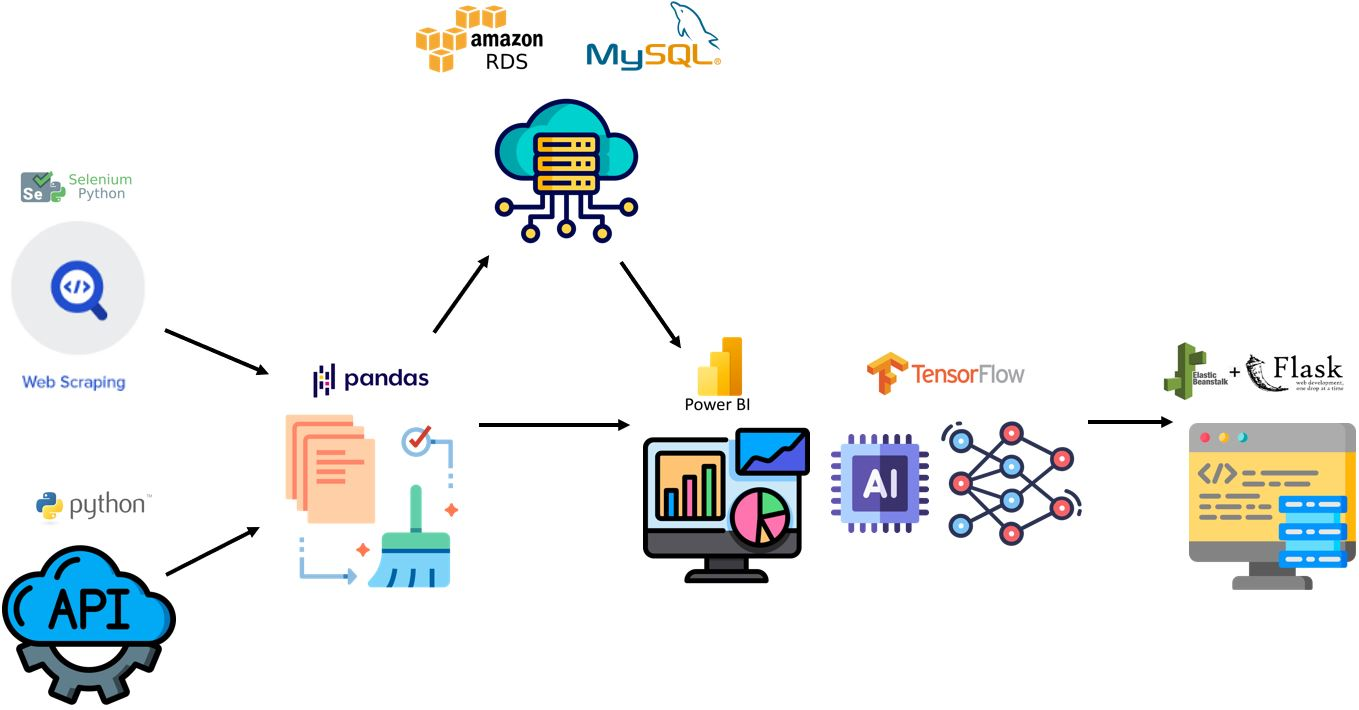


# Code Contents

- Import Libraries
- Web Scraping with Selenium
- Cleaning the Data in Pandas
- Data Engineering. Storing data in an SQL database hosted on AWS
- Data Analysis
- Preparing the Dataset for a Machine Learning Model
- Building the Artificial Neural Network Model
- Evaluate Model Performance
- Appendix

# Import Libraries

In [1]:
# import neccessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import StaleElementReferenceException
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import pickle
from tabulate import tabulate
import pymysql
from sqlalchemy import create_engine
import string
import requests
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from flask import Flask

# Web Scraping with Selenium

## Activate the web driver

In [ ]:
# url is an electric vehicle specification website
# intended to be a structured database for all new electric car models
driver_path = r'C:\Python_Projects\chromedriver.exe'
url = 'https://www.evspecifications.com/'

service = Service("C:\Python_Projects\chromedriver.exe")

# specify which browser
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

# go to url
driver.get(url)

In [ ]:
# accept cookies
driver.find_element(by='id', value='cookie_consent_accept').click()

## Create an empty nested dicitonary

On the website which we are extracting the data from, the specifications reported are not consistent across each model. Hence, it is neccessary to iterate through each model page on the website to see all the possible specifications that are listed.

Once all of the specifications have been extracted we can then go about populating the dicitonary with the specification data.

In [ ]:
# extract all the brands on the home webpage
brands = []

# find parent class with all brand name links under
parent = driver.find_element(By.CLASS_NAME, 'brand-listing-container-frontpage')

# now iterate through the parent class and extract all brands
for brand in parent.find_elements(By.TAG_NAME, 'a'):
    brands.append(brand.text)

# create an empty dicitonary ready to populate with all features you want to extract from the website
nested_dict_features = {}

# specifiying feature list we want to extract
features = [
    'Brand, model, trim, price', 'Body style, dimensions, volumes, weights.', 'Electric motor', 'Second electric motor',
    'Performance', 'Energy class', 'Steering', 'Transmission', 'Suspension',
    'Brakes', 'Battery'
]


# iterate through each brand
for brand in brands:
    driver.find_element(By.LINK_TEXT, brand).click()
    
    # extract html links for all models within a specific brand
    # save in a variable
    model_links = []
    for model_list in driver.find_elements(By.CLASS_NAME, 'model-listing-container-80'):
        for model in model_list.find_elements(By.TAG_NAME, 'h3'):
            model_links.append(model.find_element(By.TAG_NAME, 'a').get_attribute('href'))
    
    # iterate through each model and extract data
    for link in model_links:
                
        driver.find_element(By.XPATH, '//a[@href="'+link+'"]').click()
        
        # select the html div with all specs in
        div = driver.find_element(By.XPATH, "//div[@style='width: 100%; margin-top: 20px;']")

        # iterate through each table and table header
        # create a nested dictionary
        # each inner dictionary represents a header and corresponding table
        for (header, table) in zip(div.find_elements(By.TAG_NAME, 'header'), div.find_elements(By.TAG_NAME, 'table')[:-1]):
            key = header.text.split('\n')[0]

            if key.lower() in [feature.lower() for feature in features]:

                if key.lower() not in [x.lower() for x in nested_dict_features.keys()]:
                    nested_dict_features[key] = {}

                else:
                    pass

                for row in table.find_elements(By.TAG_NAME, 'tr'):

                    try:
                        feature = row.find_elements(By.TAG_NAME, 'td')[0].text

                        if '\n' in feature:
                            subcategory_key = feature.split('\n')[0]
                            if subcategory_key.lower() not in [x.lower() for x in nested_dict_features[key].keys()]:
                                nested_dict_features[key][subcategory_key.lower()] = []
                            else:
                                continue

                        else:
                            if feature.lower() not in [x.lower() for x in nested_dict_features[key].keys()]:
                                nested_dict_features[key][feature.lower()] = []
                            else:
                                continue


                    except IndexError:
                        continue

            elif key.lower() == 'driving range':

                if key.lower() not in [x.lower() for x in nested_dict_features.keys()]:
                    nested_dict_features[key] = {}

                else:
                    pass

                for row in table.find_elements(By.TAG_NAME, 'tr'):

                    try:
                        feature = row.find_elements(By.TAG_NAME, 'td')[0].text

                        # before 2019 we will select EPA driving range test
                        if int(driver.find_element(By.TAG_NAME, 'h1').text.split()[0]) < 2019:

                            if feature.lower() == 'epa (electric car range and efficiency)':

                                if feature.lower() not in [x.lower() for x in nested_dict_features[key].keys()]:
                                    nested_dict_features[key][feature.lower()] = []
                                    break
                                else:
                                    break

                            else:
                                continue


                        else:
                            # 2019 and after we will select wltp driving range test
                            if feature.lower() == 'wltp (worldwide harmonized light vehicles test procedure)':

                                if feature.lower() not in [x.lower() for x in nested_dict_features[key].keys()]:
                                    nested_dict_features[key][feature.lower()] = []
                                    break
                                else:
                                    break

                            else:
                                continue

                    except IndexError:
                        continue


            elif key.lower() == 'energy efficiency':

                if key.lower() not in [x.lower() for x in nested_dict_features.keys()]:
                    nested_dict_features[key] = {}

                else:
                    pass

                for row in table.find_elements(By.TAG_NAME, 'tr'):

                    try:
                        feature = row.find_elements(By.TAG_NAME, 'td')[0].text

                        # before 2019 we will select EPA driving range test
                        if int(driver.find_element(By.TAG_NAME, 'h1').text.split()[0]) < 2019:

                            if (feature.lower() == 'epa (electric car range and efficiency)') and (row.find_elements(By.TAG_NAME, 'td')[1].text.lower() == 'combined'):

                                if feature.lower() not in [x.lower() for x in nested_dict_features[key].keys()]:
                                    nested_dict_features[key][feature.lower()] = []
                                    break
                                else:
                                    break

                            else:
                                continue

                        else:
                            # 2019 and after we will select wltp driving range test
                            if (feature.lower() == 'wltp (worldwide harmonized light vehicles test procedure)') and (row.find_elements(By.TAG_NAME, 'td')[1].text.lower() == 'combined'):

                                if feature.lower() not in [x.lower() for x in nested_dict_features[key].keys()]:
                                    nested_dict_features[key][feature.lower()] = []
                                    break
                                else:
                                    break

                            else:
                                continue

                    except IndexError:
                        continue                
        
        driver.back()
    driver.back()

In [ ]:
# saving nested dictionary because it took long to get
save_file = open("ev_nested_dict_features.pkl", "wb")
pickle.dump(nested_dict_features, save_file)
save_file.close()

In [ ]:
# loading the nested dictionary
load_file = open("ev_nested_dict_features.pkl", "rb")
nested_dict_features = pickle.load(load_file)

In [ ]:
nested_dict_features

## Populate the nested dictionary for each model

In [ ]:
# extract all the brands on the home webpage
brands = []

# find parent class with all brand name links under
parent = driver.find_element(By.CLASS_NAME, 'brand-listing-container-frontpage')

# now iterate through the parent class and extract all brands
for brand in parent.find_elements(By.TAG_NAME, 'a'):
    brands.append(brand.text)

# create an empty dicitonary ready to populate with all features you want to extract from the website
nested_dict = nested_dict_features.copy()

# specifiying feature list we want to extract
features = [
    'Brand, model, trim, price', 'Body style, dimensions, volumes, weights.', 'Electric motor', 'Second electric motor',
    'Performance', 'Energy class', 'Steering', 'Transmission', 'Suspension',
    'Brakes', 'Battery'
]

counter = 0

# iterate through each brand
for brand in brands:
    driver.find_element(By.LINK_TEXT, brand).click()
    
    # extract html links for all models within a specific brand
    # save in a variable
    model_links = []
    for model_list in driver.find_elements(By.CLASS_NAME, 'model-listing-container-80'):
        for model in model_list.find_elements(By.TAG_NAME, 'h3'):
            model_links.append(model.find_element(By.TAG_NAME, 'a').get_attribute('href'))
    
    # iterate through each model and extract data
    for link in model_links:
        
        counter +=1
        
        driver.find_element(By.XPATH, '//a[@href="'+link+'"]').click()
        
        # select the html div with all specs in
        div = driver.find_element(By.XPATH, "//div[@style='width: 100%; margin-top: 20px;']")

        # iterate through each table and table header
        # create a nested dictionary
        # each inner dictionary represents a header and corresponding table
        for (header, table) in zip(div.find_elements(By.TAG_NAME, 'header'), div.find_elements(By.TAG_NAME, 'table')[:-1]):
            key = header.text.split('\n')[0]

            if key.lower() in [feature.lower() for feature in features]:

                if key.lower() not in [x.lower() for x in nested_dict.keys()]:
                    nested_dict[key] = {}

                else:
                    pass

                for row in table.find_elements(By.TAG_NAME, 'tr'):

                    try:
                        feature = row.find_elements(By.TAG_NAME, 'td')[0].text
                        value = row.find_elements(By.TAG_NAME, 'td')[1].text #this will need to be changed for certain sections

                        if '\n' in feature:
                            subcategory_key = feature.split('\n')[0]
                            if subcategory_key.lower() not in [x.lower() for x in nested_dict[key].keys()]:
                                nested_dict[key][subcategory_key.lower()] = []
                                nested_dict[key][subcategory_key.lower()].append(value)
                            else:
                                nested_dict[key][subcategory_key.lower()].append(value)

                        else:
                            if feature.lower() not in [x.lower() for x in nested_dict[key].keys()]:
                                nested_dict[key][feature.lower()] = []
                                nested_dict[key][feature.lower()].append(value)
                            else:
                                nested_dict[key][feature.lower()].append(value)


                    except IndexError:
                        continue

            elif key.lower() == 'driving range':

                if key.lower() not in [x.lower() for x in nested_dict.keys()]:
                    nested_dict[key] = {}

                else:
                    pass

                for row in table.find_elements(By.TAG_NAME, 'tr'):

                    try:
                        feature = row.find_elements(By.TAG_NAME, 'td')[0].text

                        if (feature.lower() == 'wltp (worldwide harmonized light vehicles test procedure)') or (feature.lower() == 'epa (electric car range and efficiency)'):
                            value = row.find_elements(By.TAG_NAME, 'td')[1].text

                            if feature.lower() not in [x.lower() for x in nested_dict[key].keys()]:
                                nested_dict[key][feature.lower()] = []
                                nested_dict[key][feature.lower()].append(value)
                                break
                            else:
                                nested_dict[key][feature.lower()].append(value)
                                break

                        else:
                            continue

                    except IndexError:
                        continue


            elif key.lower() == 'energy efficiency':

                if key.lower() not in [x.lower() for x in nested_dict.keys()]:
                    nested_dict[key] = {}

                else:
                    pass

                for row in table.find_elements(By.TAG_NAME, 'tr'):

                    try:
                        feature = row.find_elements(By.TAG_NAME, 'td')[0].text

                        if ((feature.lower() == 'wltp (worldwide harmonized light vehicles test procedure)') and (row.find_elements(By.TAG_NAME, 'td')[1].text.lower() == 'combined')) or ((feature.lower() == 'epa (electric car range and efficiency)') and (row.find_elements(By.TAG_NAME, 'td')[1].text.lower() == 'combined')):
                            value = row.find_elements(By.TAG_NAME, 'td')[2].text

                            if feature.lower() not in [x.lower() for x in nested_dict[key].keys()]:
                                nested_dict[key][feature.lower()] = []
                                nested_dict[key][feature.lower()].append(value)
                                break
                            else:
                                nested_dict[key][feature.lower()].append(value)
                                break

                        else:
                            continue

                    except IndexError:
                        continue                
        
        # need to append zeros to the dictionary if there is no information for a given specification feature
        for outer_key in nested_dict.keys():
            for inner_key, value in nested_dict[outer_key].items():
                if len(value) == counter:
                    continue
                else:
                    nested_dict[outer_key][inner_key].append(0)
        
        driver.back()
    driver.back()

In [ ]:
# saving nested dictionary because it took long to get
save_file = open("ev_nested_dict.pkl", "wb")
pickle.dump(nested_dict, save_file)
save_file.close()

In [2]:
# loading the nested dictionary
load_file = open("ev_nested_dict.pkl", "rb")
nested_dict = pickle.load(load_file)

In [3]:
# convert the nested dictionary into a multi-index dataframe where multi-index is on the columns
reformed_dict = {}
for outerkey, innerdict in nested_dict.items():
    for innerkey, values in innerdict.items():
        reformed_dict[(outerkey, innerkey)] = values

reformed_dict

df_raw = pd.DataFrame(reformed_dict)

In [ ]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [ ]:
# save the dataframe 
df_raw.to_csv(r'C:\Users\EDavey\OneDrive - MSX International Limited\Documents\ev_spec_data - RAW.csv')

# Cleaning the data in pandas

We need to standardise the indicator of missing values in the dataframe. The majority of missing data is denoted by a 0, however there is some missing data denoted by '-'. Hence, we will standardise to 0.

In [4]:
# make a copy of raw_df
df = df_raw.copy()

# replace '-'
df.replace('-', 0, inplace=True)

+-------------+---------+---------------+
|             |   Count |   Percentages |
|-------------+---------+---------------|
| series      |     336 |            80 |
| model alias |     288 |            68 |
| price       |     204 |            48 |
| trim        |      53 |            13 |
| market      |      28 |             7 |
| brand       |       0 |             0 |
| model       |       0 |             0 |
| model year  |       0 |             0 |
+-------------+---------+---------------+


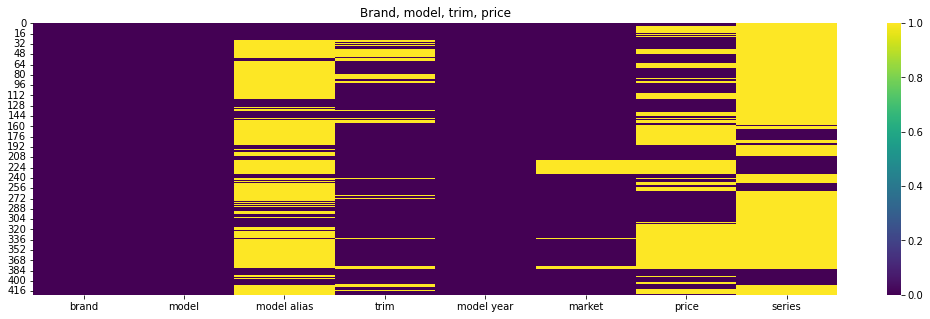

+---------------------------+---------+---------------+
|                           |   Count |   Percentages |
|---------------------------+---------+---------------|
| total volume              |     351 |            83 |
| maximum clearance         |     339 |            80 |
| passenger volume          |     336 |            80 |
| minimum clearance         |     334 |            79 |
| secondary trunk volume    |     275 |            65 |
| width with folded mirrors |     228 |            54 |
| clearance                 |     169 |            40 |
| rear legroom              |     158 |            37 |
| front legroom             |     157 |            37 |
| rear hip room             |     142 |            34 |
| front hip room            |     142 |            34 |
| payload                   |     130 |            31 |
| additional information    |     123 |            29 |
| rear shoulder room        |     118 |            28 |
| front shoulder room       |     113 |         

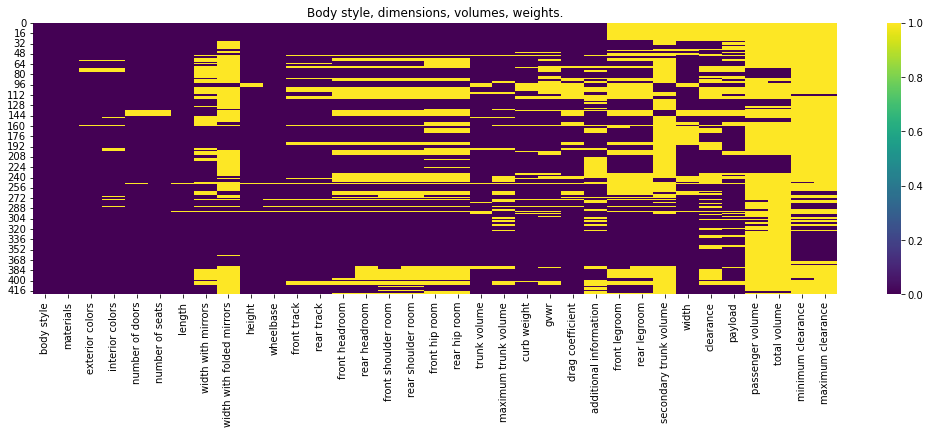

+------------------------+---------+---------------+
|                        |   Count |   Percentages |
|------------------------+---------+---------------|
| maximum torque rpm     |     362 |            86 |
| model                  |     321 |            76 |
| voltage                |     283 |            67 |
| maximum power rpm      |     262 |            62 |
| driving modes          |     244 |            58 |
| manufacturer           |     198 |            47 |
| additional information |     190 |            45 |
| torque                 |      79 |            19 |
| power                  |      57 |            14 |
| regenerative braking   |      56 |            13 |
| electric motor type    |      28 |             7 |
| location of the motor  |      15 |             4 |
+------------------------+---------+---------------+


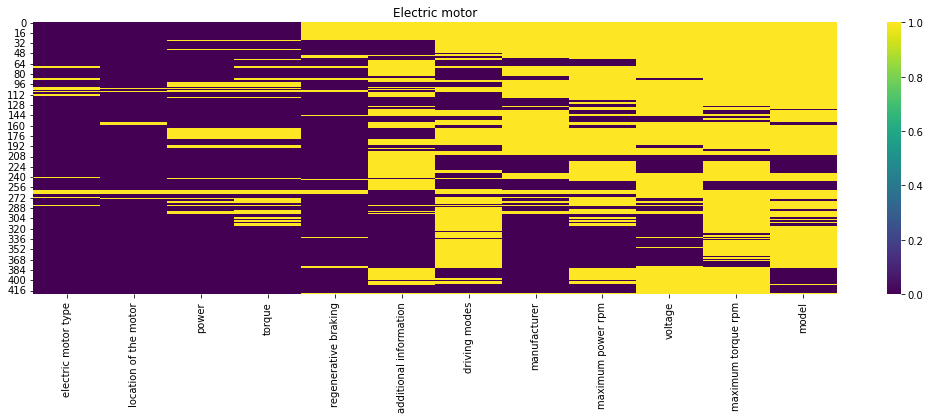

+----------------------+---------+---------------+
|                      |   Count |   Percentages |
|----------------------+---------+---------------|
| maximum torque rpm   |     420 |           100 |
| model                |     411 |            97 |
| driving modes        |     399 |            95 |
| voltage              |     381 |            90 |
| maximum power rpm    |     369 |            87 |
| manufacturer         |     346 |            82 |
| additional features  |     322 |            76 |
| torque               |     312 |            74 |
| power                |     297 |            70 |
| motor type           |     256 |            61 |
| regenerative braking |     258 |            61 |
| location             |     253 |            60 |
+----------------------+---------+---------------+


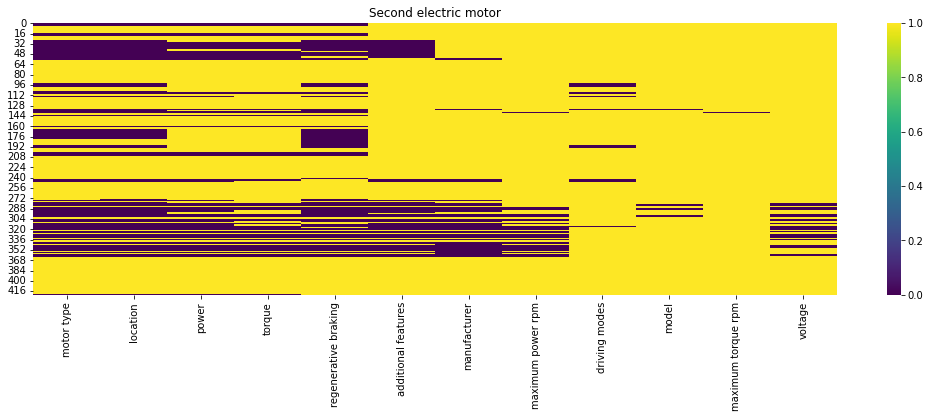

+----------------------------------+---------+---------------+
|                                  |   Count |   Percentages |
|----------------------------------+---------+---------------|
| acceleration from 80 to 120 km/h |     409 |            97 |
| additional information           |     371 |            88 |
| acceleration from 0 to 60 mph    |     238 |            56 |
| acceleration from 0 to 100 km/h  |      73 |            17 |
| top speed                        |      22 |             5 |
+----------------------------------+---------+---------------+


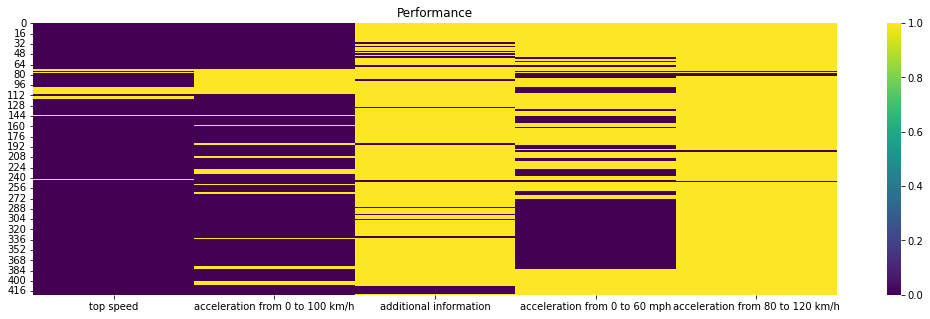

+-----------------------------------------------------------+---------+---------------+
|                                                           |   Count |   Percentages |
|-----------------------------------------------------------+---------+---------------|
| wltp (worldwide harmonized light vehicles test procedure) |     259 |            61 |
| epa (electric car range and efficiency)                   |     190 |            45 |
+-----------------------------------------------------------+---------+---------------+


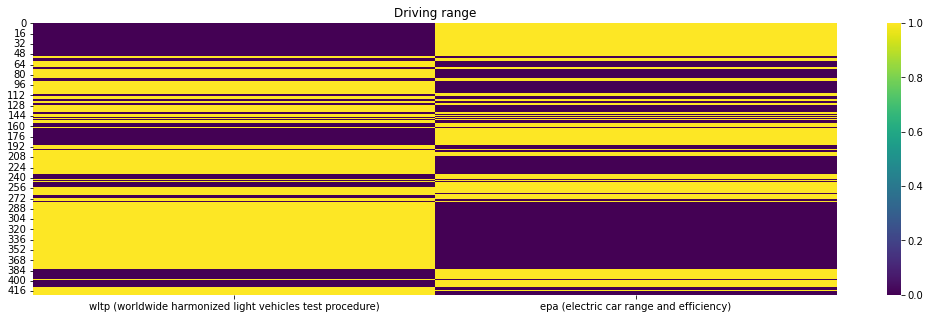

+-----------------------------------------------------------+---------+---------------+
|                                                           |   Count |   Percentages |
|-----------------------------------------------------------+---------+---------------|
| wltp (worldwide harmonized light vehicles test procedure) |     267 |            63 |
| epa (electric car range and efficiency)                   |     230 |            55 |
+-----------------------------------------------------------+---------+---------------+


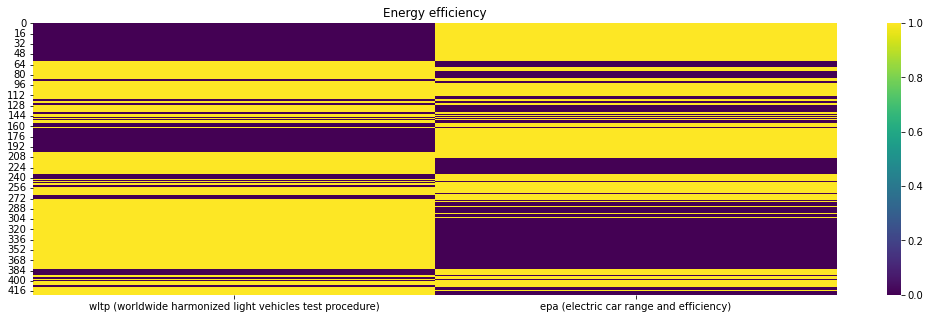

+--------------+---------+---------------+
|              |   Count |   Percentages |
|--------------+---------+---------------|
| energy class |     132 |            31 |
+--------------+---------+---------------+


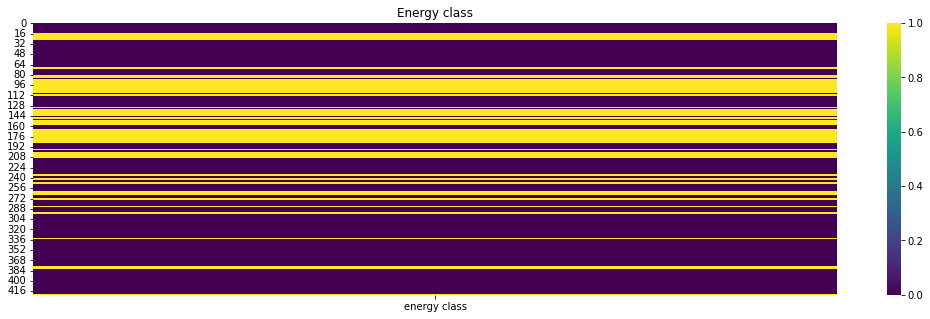

+----------------------------+---------+---------------+
|                            |   Count |   Percentages |
|----------------------------+---------+---------------|
| additional information     |     329 |            78 |
| lock-to-lock turns         |     258 |            61 |
| turning circle             |      60 |            14 |
| type of power steering     |       9 |             2 |
| type of steering mechanism |       4 |             1 |
+----------------------------+---------+---------------+


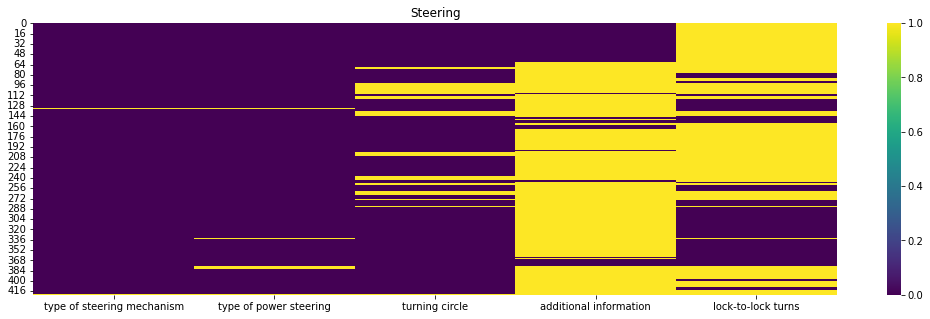

+------------------------------------------+---------+---------------+
|                                          |   Count |   Percentages |
|------------------------------------------+---------+---------------|
| additional information                   |     351 |            83 |
| axle ratio of the second electric motor. |     335 |            79 |
| axle ratio                               |     191 |            45 |
| type of transmission                     |       5 |             1 |
| drivetrain                               |       5 |             1 |
+------------------------------------------+---------+---------------+


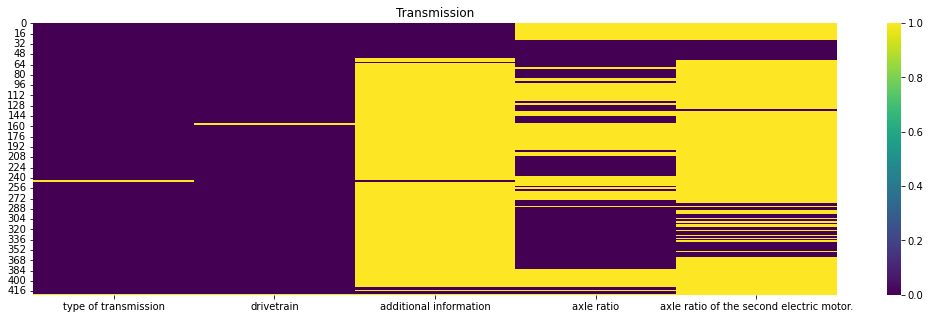

+------------------------+---------+---------------+
|                        |   Count |   Percentages |
|------------------------+---------+---------------|
| additional information |     364 |            86 |
| front suspension       |      33 |             8 |
| rear suspension        |      33 |             8 |
+------------------------+---------+---------------+


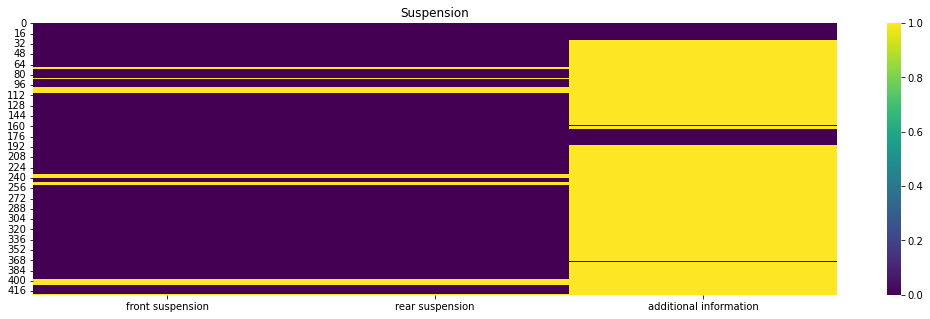

+------------------------+---------+---------------+
|                        |   Count |   Percentages |
|------------------------+---------+---------------|
| additional information |     201 |            48 |
| rear brakes            |      67 |            16 |
| front brakes           |      64 |            15 |
+------------------------+---------+---------------+


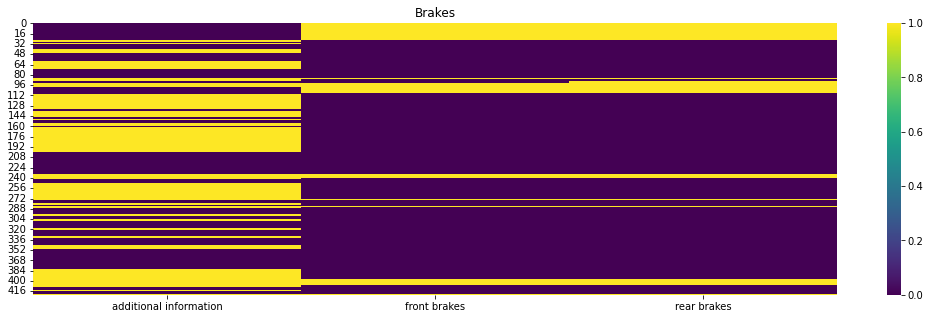

+------------------------------+---------+---------------+
|                              |   Count |   Percentages |
|------------------------------+---------+---------------|
| volume                       |     365 |            86 |
| energy density               |     291 |            69 |
| model                        |     277 |            66 |
| maximum ambient temperature  |     277 |            66 |
| minimum ambient temperature  |     256 |            61 |
| weight                       |     206 |            49 |
| number of modules            |     147 |            35 |
| additional information       |     131 |            31 |
| number of cells              |     125 |            30 |
| manufacturer                 |     113 |            27 |
| voltage                      |      82 |            19 |
| cooling                      |      47 |            11 |
| location                     |      24 |             6 |
| type of rechargeable battery |      20 |             5

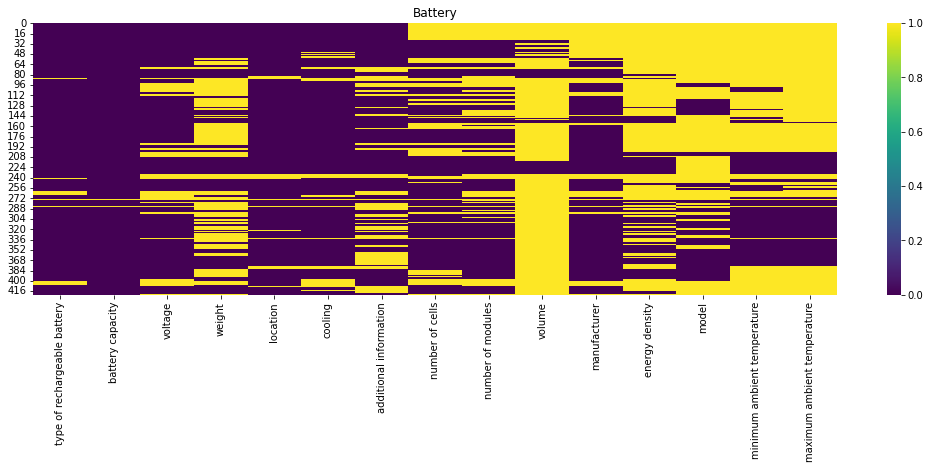

In [5]:
# identify how much missing data there is across each sub_key features
# yellow indicates missing data
for key in nested_dict.keys():
    df_i = pd.DataFrame(nested_dict[key])
    counts = []
    percentages = []
    for sub_key in nested_dict[key].keys():
        counts.append(len(df_i[df_i[sub_key]==0]))
        percentages.append(round(len(df_i[df_i[sub_key]==0]) / len(df_i) * 100))
    df_percent = pd.DataFrame(index=nested_dict[key].keys())
    df_percent['Count'] = counts
    df_percent['Percentages'] = percentages
    df_percent.sort_values('Percentages', ascending=False, inplace=True)
    print(tabulate(df_percent, headers='keys', tablefmt='psql'))
    plt.figure(figsize=[18,5])
    plt.title(key)
    sns.heatmap(df_i==0, cbar=True, cmap='viridis')
    plt.show()

## Brand, model, trim, price

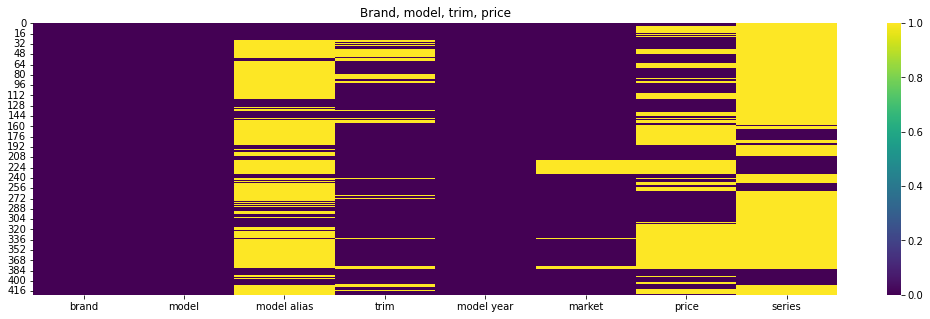

,Feature,Count,Percentage
7,series,336,80
2,model alias,288,68
6,price,204,48
3,trim,53,13
5,market,28,7
0,brand,0,0
1,model,0,0
4,model year,0,0


In [6]:
# create dataframe to input number of missing values and percentages
df_missing = pd.DataFrame(columns=['Feature'], data=nested_dict['Brand, model, trim, price'].keys())
df_i = pd.DataFrame(nested_dict['Brand, model, trim, price'])

# create a plot first to visualise missing data in the sub dictionary
plt.figure(figsize=[18,5])
plt.title('Brand, model, trim, price')
sns.heatmap(df_i==0, cbar=True, cmap='viridis')
plt.show()

# populate the dataframe
df_missing['Count'] = df_missing['Feature'].apply(lambda x: len(df_i[df_i[x]==0]))
df_missing['Percentage'] = df_missing['Count'].apply(lambda x: round(x/len(df_i)*100))
df_missing.sort_values('Percentage', ascending=False, inplace=True)
df_missing

Features to be removed are:
- series
- model alias
- trim

These features will be removed because there is too much missing data. Generally if more than 20% of the data is missing the featrues will be removed; however, if the feature is of key importance then the information will be gathered from elsewhere. A prime example of this is the price feature...46% of the data is missing, however this is of key importance because this is what the model will be predicting.

Trim has 169 unique values, which is more than half of the total number of rows in the data. Hence, this will not provide a good prediction for price due to the large variation of values.

In [7]:
# convert model year to number
df.loc[:, ('Brand, model, trim, price', 'model year')] = df['Brand, model, trim, price']['model year'].astype('int')

In [8]:
# remove series and model alias
df.drop(('Brand, model, trim, price', 'series'), axis=1, inplace=True)
df.drop(('Brand, model, trim, price', 'model alias'), axis=1, inplace=True)

In [9]:
# look at trim value counts and number of unique values
print("Number of unique values in the column: {}\n".format(df['Brand, model, trim, price']['trim'].nunique()))
print(df['Brand, model, trim, price']['trim'].value_counts(dropna=False))

Number of unique values in the column: 214

0                 53
SV                 9
SL                 9
Long Range AWD     7
S                  7
                  ..
250                1
300 Extra Long     1
300 Long           1
250 Extra Long     1
P8 AWD             1
Name: trim, Length: 214, dtype: int64


In [10]:
# drop the trim column
df.drop(('Brand, model, trim, price', 'trim'), axis=1, inplace=True)

In [11]:
# remaining columns with missing data are price, trim and market
# look at the rows with missing data for trim
# also look at the value counts for the trim column across the enitre dataframe
print(df['Brand, model, trim, price']['market'].value_counts(dropna=False))

df[df['Brand, model, trim, price']['market']==0]

North America, Europe                      102
Global                                      78
Europe                                      76
North America                               56
0                                           28
North America, Europe, South Korea          26
North America, Europe, China, Australia     21
North America, Europe, China                12
Europe, South Korea, India                   7
China                                        6
Europe, Australia                            2
North America, South America, Europe         2
North America, China                         2
North America, Japan                         1
Europe, South Korea                          1
Europe, China, Australia                     1
North America, South Korea                   1
Name: market, dtype: int64


Brand, model, trim, price                                              \
                        brand               model model year market price   
51                       Audi           Q4 e-tron       2019      0     0   
212                    Nissan                Leaf       2018      0     0   
213                    Nissan                Leaf       2018      0     0   
214                    Nissan                Leaf       2018      0     0   
215                    Nissan                Leaf       2017      0     0   
216                    Nissan                Leaf       2017      0     0   
217                    Nissan                Leaf       2017      0     0   
218                    Nissan                Leaf       2016      0     0   
219                    Nissan                Leaf       2016      0     0   
220                    Nissan                Leaf       2016      0     0   
221                    Nissan                Leaf       2015      0     0   
222                    Nissan                Leaf       2015      0     0   
223                    Nissan                Leaf       2015      0     0   
224                    Nissan                Leaf       2014      0     0   
225                    Nissan                Leaf       2014      0     0   
226                    Nissan                Leaf       2014      0     0   
227                    Nissan                Leaf       2013      0     0   
228                    Nissan                Leaf       2013      0     0   
229                    Nissan                Leaf       2013      0     0   
230                    Nissan                Leaf       2012      0     0   
231                    Nissan                Leaf       2012      0     0   
232                    Nissan                Leaf       2011      0     0   
233                    Nissan                Leaf       2011      0     0   
334                     Tesla        Roadster 3.0       2016      0     0   
378                     Tesla        Roadster 2.5       2010      0     0   
379                     Tesla  Roadster Sport 2.0       2009      0     0   
380                     Tesla        Roadster 2.0       2009      0     0   
381                     Tesla        Roadster 1.5       2008      0     0   

    Body style, dimensions, volumes, weights.            \
                                   body style materials   
51                Sport utility vehicle (SUV)         0   
212                                 Hatchback     Steel   
213                                 Hatchback     Steel   
214                                 Hatchback     Steel   
215                                 Hatchback     Steel   
216                                 Hatchback     Steel   
217                                 Hatchback     Steel   
218                                 Hatchback     Steel   
219                                 Hatchback     Steel   
220                                 Hatchback     Steel   
221                                 Hatchback     Steel   
222                                 Hatchback     Steel   
223                                 Hatchback     Steel   
224                                 Hatchback     Steel   
225                                 Hatchback     Steel   
226                                 Hatchback     Steel   
227                                 Hatchback     Steel   
228                                 Hatchback     Steel   
229                                 Hatchback     Steel   
230                                 Hatchback     Steel   
231                                 Hatchback     Steel   
232                                 Hatchback     Steel   
233                                 Hatchback     Steel   
334                                 Cabriolet         0   
378                                 Cabriolet         0   
379                                 Cabriolet         0   
380                                 Cabri

In [12]:
# the three models in question are...
# Audi Q4 e-tron
# Nissan leaf
# Tesla Roadster
# the markets of these models can be googled and added to the dataframe
def market_assign(brand, market):
    if market == 0 and brand == 'Audi':
        result = 'North America, Europe'
    elif market == 0 and brand == 'Nissan':
        result = 'North America, Europe, China, Australia, Japan'
    elif market == 0 and brand == 'Tesla':
        result = 'North America, Europe, Australia'
    else:
        result = market
    
    return result

In [13]:
# assign the results the market column
df.loc[:, ('Brand, model, trim, price', 'market')] = df['Brand, model, trim, price'][['brand', 'market']].apply(lambda x: market_assign(x[0], x[1]), axis=1)

<AxesSubplot:>

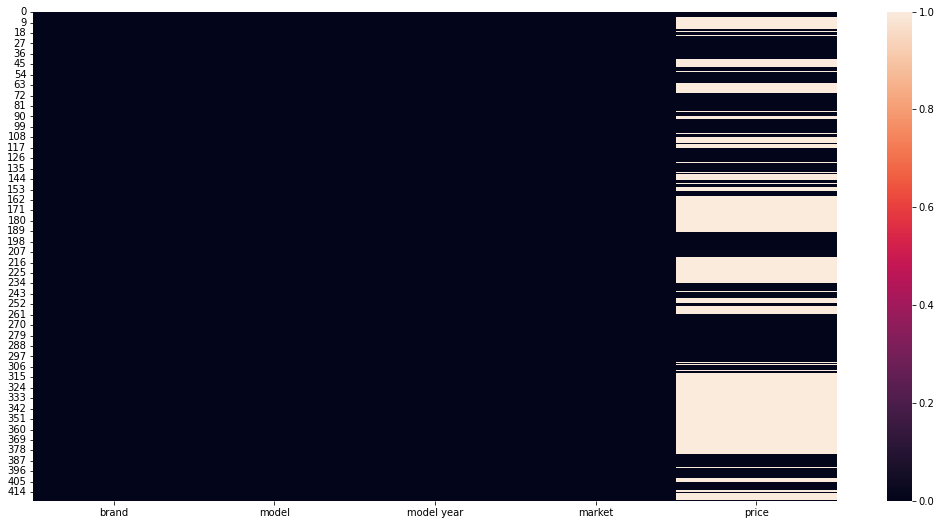

In [14]:
plt.figure(figsize=[18,9])
sns.heatmap(df['Brand, model, trim, price']==0)

## Body style, dimensions, volumes, weights

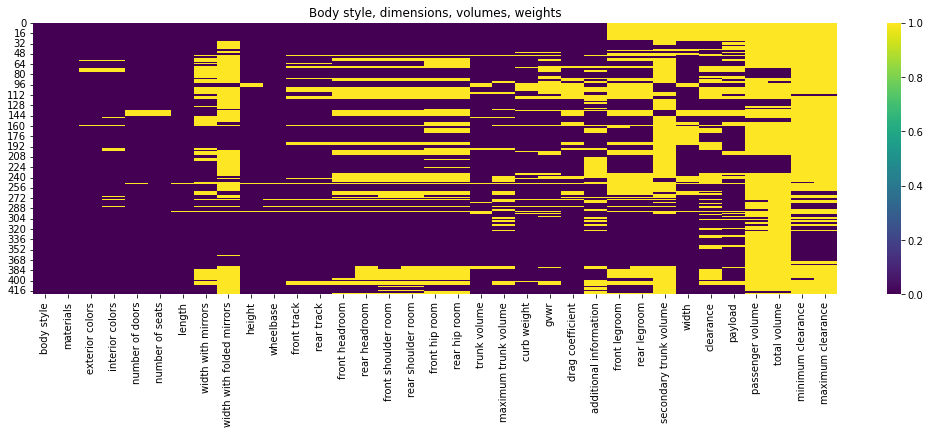

,Feature,Count,Percentage
32,total volume,351,83
34,maximum clearance,339,80
31,passenger volume,336,80
33,minimum clearance,334,79
27,secondary trunk volume,275,65
8,width with folded mirrors,228,54
29,clearance,169,40
26,rear legroom,158,37
25,front legroom,157,37
18,rear hip room,142,34


In [15]:
# create dataframe to input number of missing values and percentages
df_missing = pd.DataFrame(columns=['Feature'], data=nested_dict['Body style, dimensions, volumes, weights.'].keys())
df_i = pd.DataFrame(nested_dict['Body style, dimensions, volumes, weights.'])

# create a plot first to visualise missing data in the sub dictionary
plt.figure(figsize=[18,5])
plt.title('Body style, dimensions, volumes, weights')
sns.heatmap(df_i==0, cbar=True, cmap='viridis')
plt.show()

# populate the dataframe
df_missing['Count'] = df_missing['Feature'].apply(lambda x: len(df_i[df_i[x]==0]))
df_missing['Percentage'] = df_missing['Count'].apply(lambda x: round(x/len(df_i)*100))
df_missing.sort_values('Percentage', ascending=False, inplace=True)
df_missing

A lot of features will be removed from this specification section seeing as a lot of the data is missing. All features with more than 20% of data missing will be removed.

The missing data for all numeric features will be populated using the mean of the corresponding body style, for example SUV, Coupe, Hatchback etc.

However, the numeric columns are not of the int data type and must be addressed.

In [16]:
# drop all features that have more than 20% data missing
for feature in df_missing[df_missing['Percentage'] > 20]['Feature'].to_list():
    df.drop(('Body style, dimensions, volumes, weights.', feature), axis=1, inplace=True)

In [17]:
# all numerical columns are of type object because they have units in the data entries
# need to extract the numbers from these entries
# first start by defining which features this applies to
# also define what units we want to extract because there are multiple for each entry
cols = ['length', 'height',
       'wheelbase', 'front track', 'rear track', 'trunk volume',
       'maximum trunk volume', 'curb weight', 'gvwr']

units = ['millimeters', 'liters', 'kilograms']

# define function that extracts correct section
def unit_selector(data):
    if data == 0:
        return data
    else:
        for section in data.split('\n'):
            if any([unit in section for unit in units]):
                return section
            else:
                continue

In [18]:
# apply the function to all columns of interest
for column in cols:
    df.loc[:, ('Body style, dimensions, volumes, weights.', column)] = df['Body style, dimensions, volumes, weights.'][column].apply(lambda x: unit_selector(x))
    df.loc[:, ('Body style, dimensions, volumes, weights.', column)] = df['Body style, dimensions, volumes, weights.'][column].apply(lambda x: x.split()[0] if (x != 0) else x)

# now do the same for single drag coefficient column
df.loc[:, ('Body style, dimensions, volumes, weights.', 'drag coefficient')] = df['Body style, dimensions, volumes, weights.']['drag coefficient'].apply(lambda x: x.split()[0] if (x != 0) else x)

In [19]:
# convert numeric columns to type 'int' or 'float'
for col in cols:
    df.loc[:, ('Body style, dimensions, volumes, weights.', col)] = df['Body style, dimensions, volumes, weights.'][col].apply(pd.to_numeric)

# don't forget to convert drag coefficient as well
df.loc[:, ('Body style, dimensions, volumes, weights.', 'drag coefficient')] = df['Body style, dimensions, volumes, weights.']['drag coefficient'].apply(pd.to_numeric)

### Filling missing data based on mean of respective body style

In [20]:
# we will fill in all the missing data for the numerical features by using the mean of the respective body style grouping


# create a group by function
group = df['Body style, dimensions, volumes, weights.'].groupby('body style').mean()
group.loc['Minivan', 'front track'] = 1650
group.loc['Minivan', 'rear track'] = 1650


# need to define a function to do this
def data_filler(body_style, data, feature):
    
    if data != 0:
        return data
    elif data == 0:
        return group.loc[body_style, feature]

In [21]:
cols = ['length', 'height',
       'wheelbase', 'front track', 'rear track', 'trunk volume',
       'maximum trunk volume', 'curb weight', 'gvwr']

# call the function for all the numeric columns
for col in cols:
    df.loc[:, ('Body style, dimensions, volumes, weights.', col)] = df['Body style, dimensions, volumes, weights.'][['body style', col]].apply(lambda x: data_filler(x[0], x[1], col), axis=1)

# don't forget to call for drag coefficient
df.loc[:, ('Body style, dimensions, volumes, weights.', 'drag coefficient')] = df['Body style, dimensions, volumes, weights.'][['body style', 'drag coefficient']].apply(lambda x: data_filler(x[0], x[1], 'drag coefficient'), axis=1)

<AxesSubplot:>

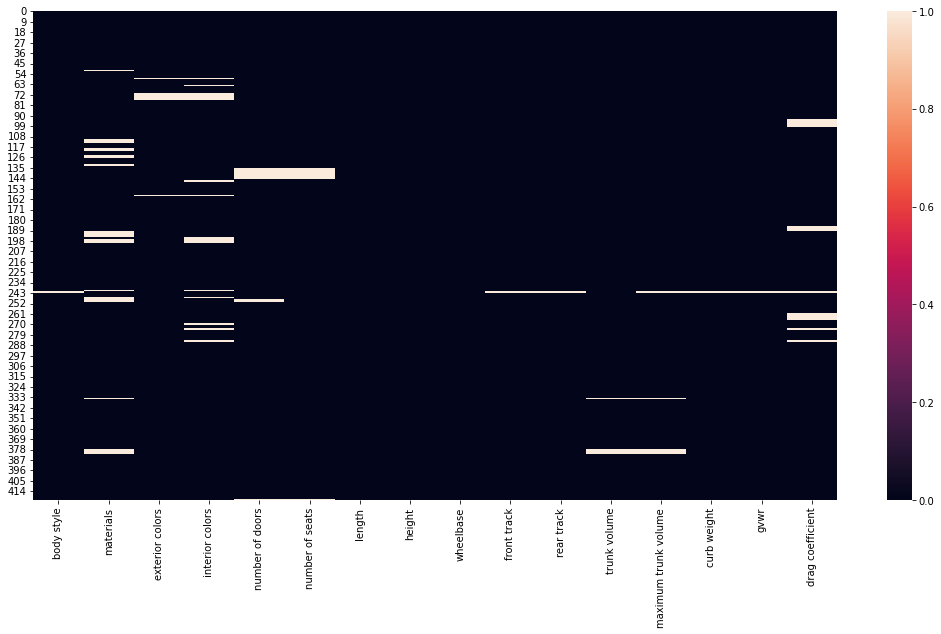

In [22]:
plt.figure(figsize=[18,9])
sns.heatmap(df['Body style, dimensions, volumes, weights.']==0)

There is still missing data in the numeric columns, this is because the group by still returned 0...meaning there is no data across the entire body style. Hence, a simple google search will have to be done for the respective body style or model in order to fill in the missing data.

This next section will be filling in the remaining feature columns.

### 'trunk volume', 'maximum trunk volume'

In [23]:
# filling in the missing data in the 'trunk volume' feature column
# average cabriolet boot volume is 320
df.loc[:, ('Body style, dimensions, volumes, weights.', 'trunk volume')] = df['Body style, dimensions, volumes, weights.'][['body style', 'trunk volume']].apply(lambda x: 320 if (x[0]=='Cabriolet') else x[1], axis=1)

# missing data in 'maximum trunk volume'
# we do not need two features detailing trunk volume, one will be sufficient. Hence, mac trunk volume will be dropped
df.drop(('Body style, dimensions, volumes, weights.', 'maximum trunk volume'), axis=1, inplace=True)

### Row 150: 'Polestar 2' model

In [24]:
# the Polestar 2 model has excessive missing data, so this will be filled in individually
# locate the index of the row with the polestar model
polestar_index = df.index[df['Body style, dimensions, volumes, weights.']['body style'].eq(0)]


# change body style to hatchback
df.loc[polestar_index, ('Body style, dimensions, volumes, weights.', 'body style')] = 'Hatchback'

# change the front track to 1602mm
df.loc[polestar_index, ('Body style, dimensions, volumes, weights.', 'front track')] = 1602

# change the rear track to 1601mm
df.loc[polestar_index, ('Body style, dimensions, volumes, weights.', 'rear track')] = 1601

# change the curb weight to 2123kg
df.loc[polestar_index, ('Body style, dimensions, volumes, weights.', 'curb weight')] = 2123

# change gvwr to 2600kg
df.loc[polestar_index, ('Body style, dimensions, volumes, weights.', 'gvwr')] = 2600

# change theh drag coefficient to 0.278
df.loc[polestar_index, ('Body style, dimensions, volumes, weights.', 'drag coefficient')] = 0.278

### 'interior colours', 'exterior colours'

In [25]:
# we are not overly concerned about the vehicle interior and exterior colours
# drop both of these features
df.drop(('Body style, dimensions, volumes, weights.', 'interior colors'), axis=1, inplace=True)
df.drop(('Body style, dimensions, volumes, weights.', 'exterior colors'), axis=1, inplace=True)

### 'drag coefficient'

In [26]:
# need to address gaps in drag coefficient
# all the missing results are for pick-up trucks
# average pick-up truck drag coefficient is 0.51
df.loc[:, ('Body style, dimensions, volumes, weights.', 'drag coefficient')] = df['Body style, dimensions, volumes, weights.'][['body style', 'drag coefficient']].apply(lambda x: 0.51 if (x[0]=='Pick-up' and x[1]==0) else (0.6 if (x[0]=='Minivan') and (x[1]==0) else x[1]), axis=1)

### 'number of doors', 'number of seats'

In [27]:
# need to strip the columns to ensure there are no spaces before or after any data entries

# number of doors
df.loc[:, ('Body style, dimensions, volumes, weights.', 'number of doors')] = df['Body style, dimensions, volumes, weights.']['number of doors'].str.strip()

# number of seats
df.loc[:, ('Body style, dimensions, volumes, weights.', 'number of seats')] = df['Body style, dimensions, volumes, weights.']['number of seats'].str.strip()

In [28]:
# all missing data for number of doors and number of seats are for SUV's and Hatchbacks
# both these model types will have 5 doors and 5 seats so that is what will be entered in the missing data

# number of doors
df.loc[:, ('Body style, dimensions, volumes, weights.', 'number of doors')] = df['Body style, dimensions, volumes, weights.']['number of doors'].apply(lambda x: '5' if (x==0) else x,)

# number of seats
df.loc[:, ('Body style, dimensions, volumes, weights.', 'number of seats')] = df['Body style, dimensions, volumes, weights.']['number of seats'].apply(lambda x: '5' if (x==0) else x,)

### 'materials

In [29]:
# materials will just be filled with the most common category for the feature column
# look at the value counts of the materials column
df['Body style, dimensions, volumes, weights.']['materials'].value_counts(dropna=False)

Steel\nAluminium                                                         105
Steel                                                                     90
Aluminium\nhigh-strength boron steel                                      57
0                                                                         30
Steal\nAluminium                                                          27
Mild steel\nHigh-strength steel\nUltra-high-strength steel\nAluminium     23
Extruded aluminium with boron steel                                       21
Aluminium\nHigh tensile strength steel                                     9
Carbon fiber reinforced polymer\nAluminium                                 9
Steel\nAluminium Alloy                                                     8
Steel\nCarbon-fiber                                                        7
Steel\nCarbon-fiber\nAluminium                                             6
Advanced High-Strength Steel\nHigh Tensile Steel                           6

In [30]:
# fill in the missing data with Steel and Aluminium
df.loc[:, ('Body style, dimensions, volumes, weights.', 'materials')] = df['Body style, dimensions, volumes, weights.']['materials'].replace(0, df['Body style, dimensions, volumes, weights.']['materials'].value_counts(dropna=False).index[0])

<AxesSubplot:>

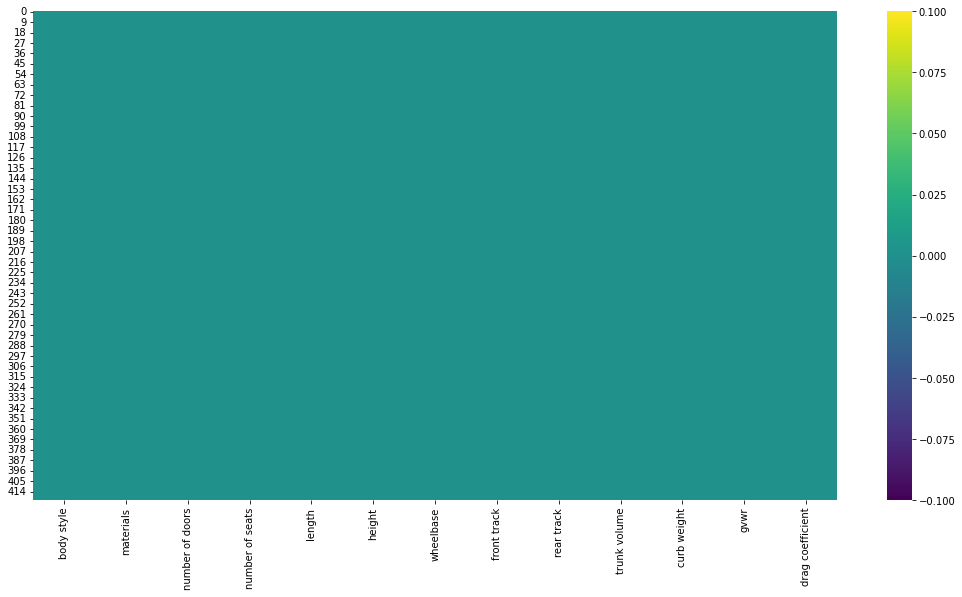

In [31]:
plt.figure(figsize=[18,9])
sns.heatmap(df['Body style, dimensions, volumes, weights.']==0, cmap='viridis')

In [32]:
df

Brand, model, trim, price                                             \
                        brand                           model model year   
0                        Audi  Q4 Sportback e-tron 50 quattro       2022   
1                        Audi  Q4 Sportback e-tron 50 quattro       2022   
2                        Audi  Q4 Sportback e-tron 50 quattro       2022   
3                        Audi  Q4 Sportback e-tron 50 quattro       2022   
4                        Audi  Q4 Sportback e-tron 50 quattro       2022   
..                        ...                             ...        ...   
417                Volkswagen                          e-Golf       2016   
418                Volkswagen                          e-Golf       2015   
419                Volkswagen                          e-Golf       2015   
420                Volkswagen                          e-Golf       2014   
421                     Volvo                   XC40 Recharge       2021   

                                                            \
                    market                           price   
0                   Global  EUR 43,900 (Germany, Jan 2022)   
1                   Global  EUR 43,900 (Germany, Jan 2022)   
2                   Global  EUR 43,900 (Germany, Jan 2022)   
3                   Global  EUR 43,900 (Germany, Jan 2022)   
4                   Global  EUR 43,900 (Germany, Jan 2022)   
..                     ...                             ...   
417  North America, Europe                               0   
418  North America, Europe                               0   
419  North America, Europe                               0   
420                 Europe                               0   
421  North America, Europe       EUR 62,000 (DE, Mar 2020)   

    Body style, dimensions, volumes, weights.                    \
                                   body style         materials   
0                 Sport utility vehicle (SUV)             Steel   
1                 Sport utility vehicle (SUV)             Steel   
2                 Sport utility vehicle (SUV)             Steel   
3                 Sport utility vehicle (SUV)             Steel   
4                 Sport utility vehicle (SUV)             Steel   
..                                        ...               ...   
417                                 Hatchback             Steel   
418                                 Hatchback             Steel   
419                                 Hatchback             Steel   
420                                 Hatchback             Steel   
421               Sport utility vehicle (SUV)  Steel\nAluminium   

                                                  ...  \
    number of doors number of seats       length  ...   
0                 5               5  4588.000000  ...   
1                 5               5  4588.000000  ...   
2                 5               5  4588.000000  ...   
3                 5               5  4588.000000  ...   
4                 5               5  4588.000000  ...   
..              ...             ...          ...  ...   
417               4               5  4270.000000  ...   
418               4               5  4270.000000  ...   
419               4               5  4270.000000  ...   
420               4               4  4254.000000  ...   
421             NaN             NaN  4605.129412  ...   

                                        Battery                            \
                                        cooling    additional information   
0    Water-based coolant circulation\nHeat pipe   Net capacity - 76.6 kWh   
1    Water-based coolant circulation\nHeat pipe   Net capacity - 76.6 kWh   
2    Water-based coolant circulation\nHeat pipe   Net capacity - 76.6 kWh   
3    Water-based coolant circulation\nHeat pipe   Net capacity - 76.6 kWh   
4    Water-based coolant circulation\nHeat pipe   Net capacity - 76.6 kWh   
..                                          ...        

## Electric motor

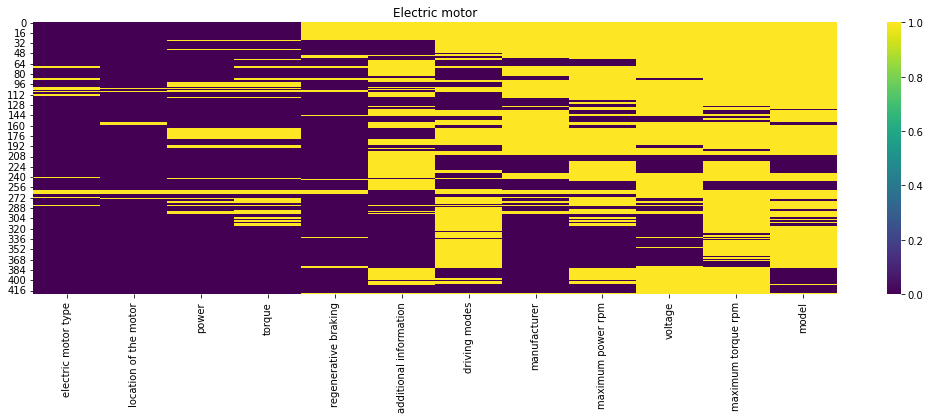

,Feature,Count,Percentage
10,maximum torque rpm,362,86
11,model,321,76
9,voltage,283,67
8,maximum power rpm,262,62
6,driving modes,244,58
7,manufacturer,198,47
5,additional information,190,45
3,torque,79,19
2,power,57,14
4,regenerative braking,56,13


In [33]:
# create dataframe to input number of missing values and percentages
df_missing = pd.DataFrame(columns=['Feature'], data=nested_dict['Electric motor'].keys())
df_i = pd.DataFrame(nested_dict['Electric motor'])

# create a plot first to visualise missing data in the sub dictionary
plt.figure(figsize=[18,5])
plt.title('Electric motor')
sns.heatmap(df_i==0, cbar=True, cmap='viridis')
plt.show()

# populate the dataframe
df_missing['Count'] = df_missing['Feature'].apply(lambda x: len(df_i[df_i[x]==0]))
df_missing['Percentage'] = df_missing['Count'].apply(lambda x: round(x/len(df_i)*100))
df_missing.sort_values('Percentage', ascending=False, inplace=True)
df_missing

In [34]:
# removing columns with more than 20% of data missing
for feature in df_missing[df_missing['Percentage'] > 20]['Feature'].to_list():
    df.drop(('Electric motor', feature), axis=1, inplace=True)

<AxesSubplot:>

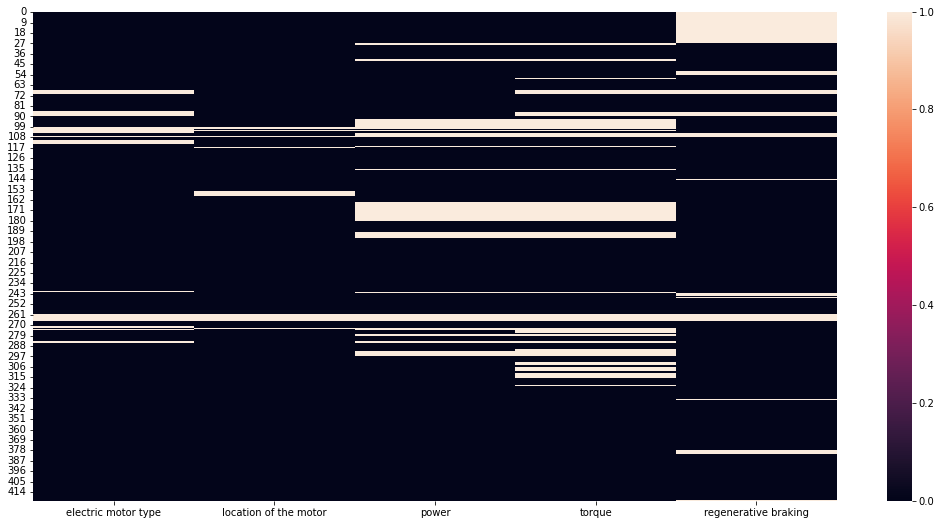

In [35]:
plt.figure(figsize=[18,9])
sns.heatmap(df['Electric motor']==0)

In [36]:
# need to convert 'power' and 'torque' columns to numerical
# already made a function 'unit_selector'
# need to redefine units variable
units = ['kilowatts', 'newton meters']
cols = ['power', 'torque']

try:
    for col in cols:
        df.loc[:, ('Electric motor', col)] = df['Electric motor'][col].apply(lambda x: unit_selector(x))
        df.loc[:, ('Electric motor', col)] = df['Electric motor'][col].apply(lambda x: x.split()[0] if (x != 0) else x)
        df.loc[:, ('Electric motor', col)] = df['Electric motor'][col].apply(pd.to_numeric)
except AttributeError:
    None

### 'electric motor type'

finding the most common electric motor type based on model year and body style

In [37]:
# create a sub_df which computes the most common electric motor type for the model year and body style
sub_df = df.loc[:, (['Brand, model, trim, price', 'Body style, dimensions, volumes, weights.', 'Electric motor'], ['model year', 'body style', 'electric motor type'])]
sub_df.columns = sub_df.columns.get_level_values(1)
sub_df = sub_df.groupby(['model year', 'body style']).agg(lambda x: x.value_counts(dropna=False).index[0]).reset_index()
sub_df

,model year,body style,electric motor type
0,2008,Cabriolet,AC induction/asynchronous
1,2009,Cabriolet,AC induction/asynchronous
2,2010,Cabriolet,AC induction/asynchronous
3,2011,Hatchback,Permanent magnet synchronous
4,2012,Hatchback,Permanent magnet synchronous
5,2012,Sedan,AC induction/asynchronous
6,2013,Hatchback,Permanent magnet synchronous
7,2013,Sedan,AC induction/asynchronous
8,2014,Hatchback,Permanent magnet synchronous
9,2014,Sedan,AC induction/asynchronous


In [38]:
# define function that locates the model year and body style and returns the most common battery type
def motor_filler(model_year, body_style, data):
    if data==0:
        return sub_df[(sub_df['model year']==model_year) & (sub_df['body style']==body_style)]['electric motor type'].to_list()[0]
    else:
        return data


# call function
df.loc[:, ('Electric motor', 'electric motor type')] = df.loc[:, (['Brand, model, trim, price', 'Body style, dimensions, volumes, weights.', 'Electric motor'], ['model year', 'body style', 'electric motor type'])].apply(lambda x: motor_filler(x[0], x[1], x[2]), axis=1)

In [39]:
# both rivian and tesla pick-up truck data is missing for electric motor type
# a google search showed they both utilise 'Permanent magnet synchronous' for some of the motors, so this is what will be chosen
df.loc[:, ('Electric motor', 'electric motor type')] = df['Electric motor']['electric motor type'].replace(0, 'Permanent magnet synchronous')

### 'power', 'torque'

In [40]:
# fill in the missing data by looking the mean of the respective electric motor type
group = df['Electric motor'].groupby('electric motor type').mean()
group

,power,torque
electric motor type,,
AC induction/asynchronous,186.713376,335.394904
AC synchronous,119.461538,296.923077
Brushless DC,130.333333,304.166667
Permanent magnet synchronous,108.350000,257.145455
Switched reluctance,199.500000,0.000000


In [41]:
# fill in the data
cols = ['power', 'torque']

# define function
def power_torque_filler(electric_motor, feature, data):
    if data == 0:
        if (electric_motor=='Switched reluctance') and (feature=='torque'):
            # switched reluctance has no data so fill in with mean of entire torque column
            return df['Electric motor']['torque'].mean()
        else:
            return group.loc[electric_motor, feature]
    else:
        return data


for col in cols:
    df.loc[:, ('Electric motor', col)] = df['Electric motor'][['electric motor type', col]].apply(lambda x: power_torque_filler(x[0],col,x[1]), axis=1) 

### 'regenerative braking'

In [42]:
# look at the value counts
df['Electric motor']['regenerative braking'].value_counts(dropna=False)

Yes    366
0       56
Name: regenerative braking, dtype: int64

In [43]:
# regenerative braking column only contains 'yes' values and rows with missing data
# drop the regenerative braking column
df.drop(('Electric motor', 'regenerative braking'), axis=1, inplace=True)

### 'location of the motor'

In [44]:
# look at the value counts
df['Electric motor']['location of the motor'].value_counts(dropna=False)

Rear     258
Front    149
0         15
Name: location of the motor, dtype: int64

In [45]:
# missing data will be filled in by looking at the most common for each body style
sub_df = df.loc[:, (['Body style, dimensions, volumes, weights.', 'Electric motor'], ['body style', 'location of the motor'])]
sub_df.columns = sub_df.columns.get_level_values(1)
sub_df = sub_df.groupby(['body style']).agg(lambda x: x.value_counts(dropna=False).index[0])
sub_df

,location of the motor
body style,
Cabriolet,Rear
Coupe,Rear
Crossover,Front
Hatchback,Front
Minivan,Front
Pick-up,Rear
Sedan,Rear
Sport utility vehicle (SUV),Rear


In [46]:
# define function that will fill in the missing data
def location_filler(body_style, data):
    if data==0:
        if body_style == 'Pick-up':
            return 'Front & Rear'
        else:
            return sub_df.loc[body_style].to_list()[0]
    else:
        return data
    
    
# call the function
df.loc[:, ('Electric motor', 'location of the motor')] = df.loc[:, (['Body style, dimensions, volumes, weights.', 'Electric motor'], ['body style', 'location of the motor'])].apply(lambda x: location_filler(x[0], x[1]), axis=1)

<AxesSubplot:>

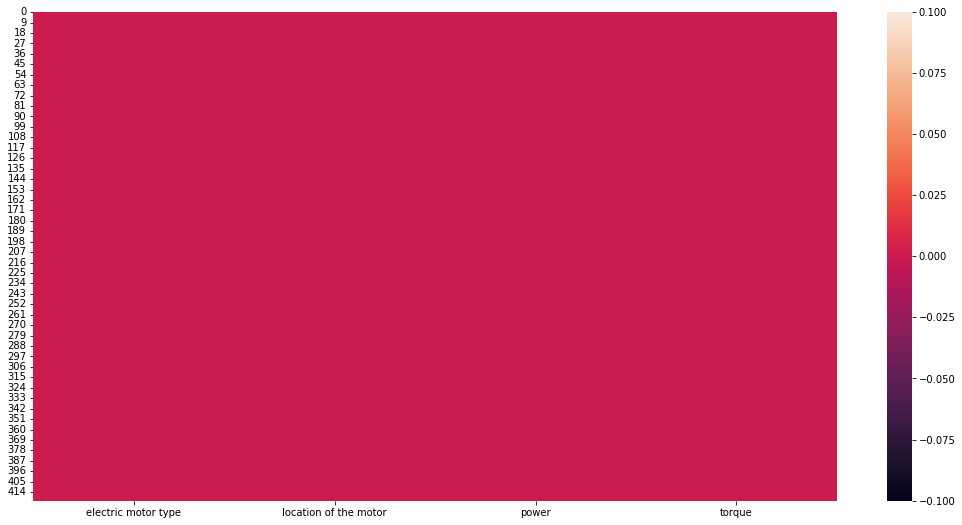

In [47]:
plt.figure(figsize=[18,9])
sns.heatmap(df['Electric motor']==0)

## Second electric motor

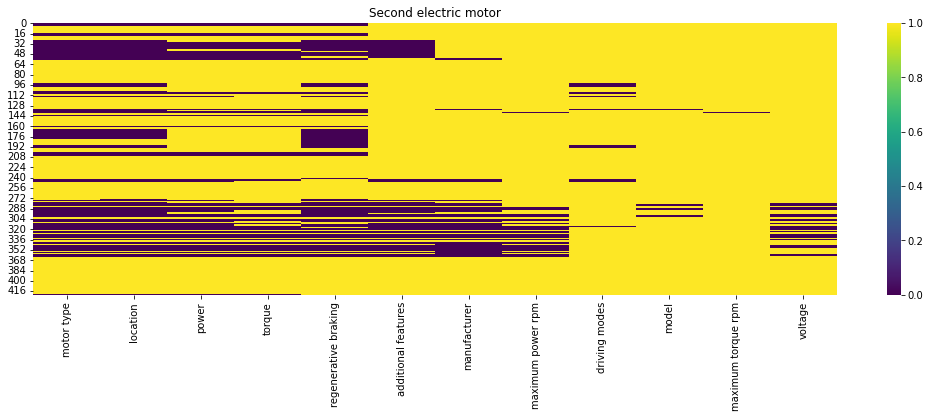

,Feature,Count,Percentage
10,maximum torque rpm,420,100
9,model,411,97
8,driving modes,399,95
11,voltage,381,90
7,maximum power rpm,369,87
6,manufacturer,346,82
5,additional features,322,76
3,torque,312,74
2,power,297,70
0,motor type,256,61


In [48]:
# create dataframe to input number of missing values and percentages
df_missing = pd.DataFrame(columns=['Feature'], data=nested_dict['Second electric motor'].keys())
df_i = pd.DataFrame(nested_dict['Second electric motor'])

# create a plot first to visualise missing data in the sub dictionary
plt.figure(figsize=[18,5])
plt.title('Second electric motor')
sns.heatmap(df_i==0, cbar=True, cmap='viridis')
plt.show()

# populate the dataframe
df_missing['Count'] = df_missing['Feature'].apply(lambda x: len(df_i[df_i[x]==0]))
df_missing['Percentage'] = df_missing['Count'].apply(lambda x: round(x/len(df_i)*100))
df_missing.sort_values('Percentage', ascending=False, inplace=True)
df_missing

There is too much missing data here under this category. Hence the entire category will be dropped.

In [49]:
# drop the entire outer column index
df.drop('Second electric motor', axis=1, level=0, inplace=True)

## Performance

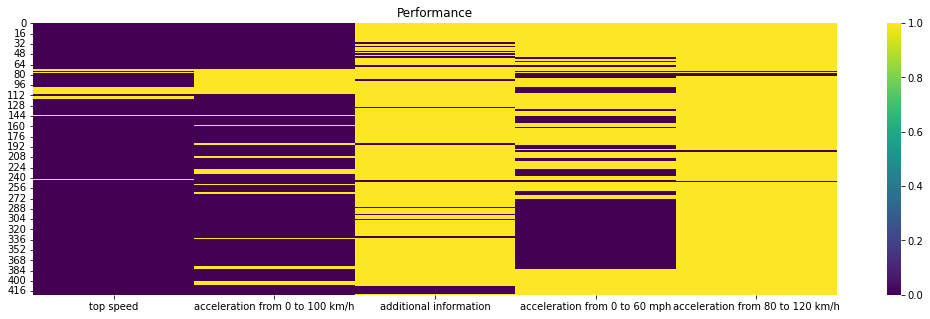

,Feature,Count,Percentage
4,acceleration from 80 to 120 km/h,409,97
2,additional information,371,88
3,acceleration from 0 to 60 mph,238,56
1,acceleration from 0 to 100 km/h,73,17
0,top speed,22,5


In [50]:
# create dataframe to input number of missing values and percentages
df_missing = pd.DataFrame(columns=['Feature'], data=nested_dict['Performance'].keys())
df_i = pd.DataFrame(nested_dict['Performance'])

# create a plot first to visualise missing data in the sub dictionary
plt.figure(figsize=[18,5])
plt.title('Performance')
sns.heatmap(df_i==0, cbar=True, cmap='viridis')
plt.show()

# populate the dataframe
df_missing['Count'] = df_missing['Feature'].apply(lambda x: len(df_i[df_i[x]==0]))
df_missing['Percentage'] = df_missing['Count'].apply(lambda x: round(x/len(df_i)*100))
df_missing.sort_values('Percentage', ascending=False, inplace=True)
df_missing

In [51]:
# drop any columns with more than 20% of the data missing
for feature in df_missing[df_missing['Percentage']>20]['Feature'].to_list():
    df.drop(('Performance', feature), axis=1, inplace=True)

<AxesSubplot:>

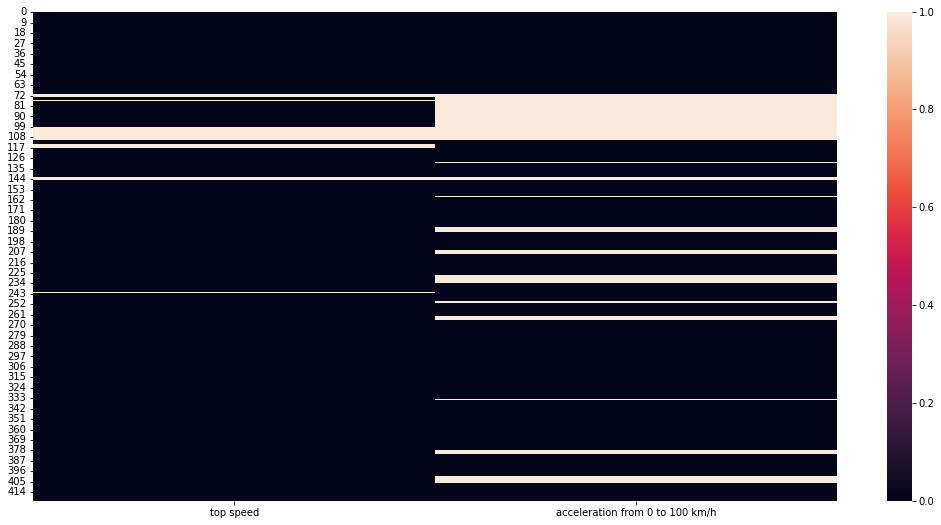

In [52]:
plt.figure(figsize=[18,9])
sns.heatmap(df['Performance']==0)

### 'top speed', 'acceleration from 0 to 100 km/h'

In [53]:
# need to extract the miles per hour from the top speed column
units = ['kilometers per hour']

# use unit selector function previously defined in the script
df.loc[:, ('Performance', 'top speed')] = df['Performance']['top speed'].apply(lambda x: unit_selector(x))


# extract the number from top speed and acceleration column
# top speed
df.loc[:, ('Performance', 'top speed')] = df['Performance']['top speed'].apply(lambda x: x.split()[0] if (x!=0) else x)
# acceleration
df.loc[:, ('Performance', 'acceleration from 0 to 100 km/h')] = df['Performance']['acceleration from 0 to 100 km/h'].apply(lambda x: x.split()[0] if (x!=0) else x)


# convert the columns to a numeric
# top speed
df.loc[:, ('Performance', 'top speed')] = pd.to_numeric(df['Performance']['top speed'])
# acceleration
df.loc[:, ('Performance', 'acceleration from 0 to 100 km/h')] = pd.to_numeric(df['Performance']['acceleration from 0 to 100 km/h'])

In [54]:
# data will be filled by mean of respective body style
# create a sub_df which is a grouped by body style
sub_df = df.loc[:, (['Body style, dimensions, volumes, weights.', 'Performance'], ['body style', 'top speed', 'acceleration from 0 to 100 km/h'])]
sub_df.columns = sub_df.columns.get_level_values(1)
sub_df = sub_df.groupby(['body style']).mean()
sub_df

,top speed,acceleration from 0 to 100 km/h
body style,,
Cabriolet,201.000000,0.000000
Coupe,199.166667,6.066667
Crossover,109.785714,9.092857
Hatchback,143.532258,6.939516
Minivan,140.000000,0.000000
Pick-up,190.312500,2.231250
Sedan,232.127711,4.416867
Sport utility vehicle (SUV),167.520588,6.052353


In [55]:
# minivan acceleration 0-100km/h will be taken as 8 seconds
sub_df.loc['Minivan', 'acceleration from 0 to 100 km/h'] = 8

In [56]:
# filling in missing data in top speed using sub_df
# define function
# cabriolet has no data for acceleration
# seeing as cabriolet are coupes but with a retractable roof, coupe acceleration data will be used for cabriolet
def performance_filler(body_style, feature, data):
    if data == 0:
        if (feature == 'acceleration from 0 to 100 km/h') and (body_style == 'Cabriolet'):
            return sub_df.loc['Coupe', feature]
        else:
            return sub_df.loc[body_style, feature]
    else:
        return data


# call function
cols = ['top speed', 'acceleration from 0 to 100 km/h']

for col in cols:
    df.loc[:, ('Performance', col)] = df.loc[:, (['Body style, dimensions, volumes, weights.', 'Performance'], ['body style', col])].apply(lambda x: performance_filler(x[0],col,x[1]), axis=1)

<AxesSubplot:>

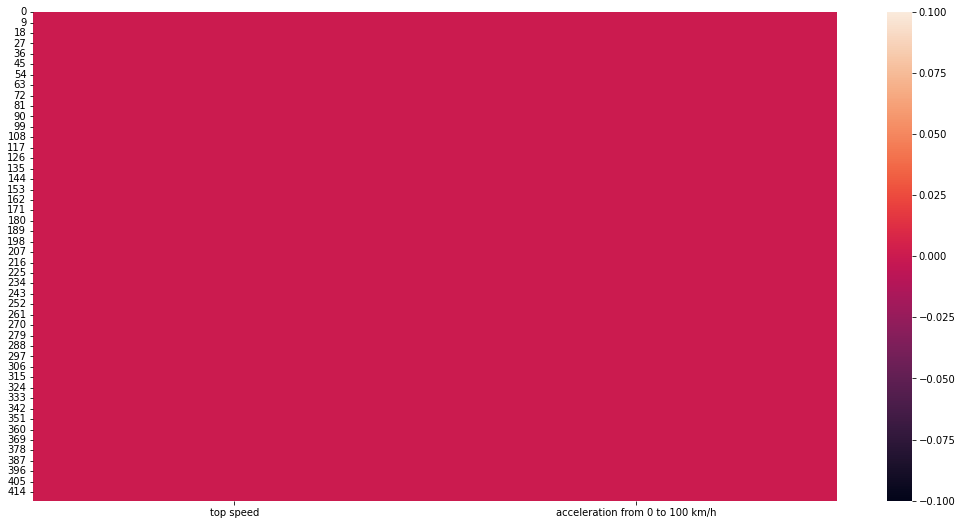

In [57]:
plt.figure(figsize=[18,9])
sns.heatmap(df['Performance']==0)

## Driving range

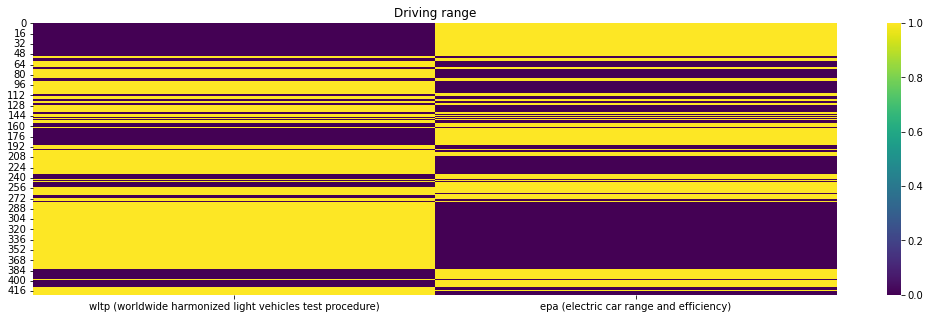

,Feature,Count,Percentage
0,wltp (worldwide harmonized light vehicles test...,259,61
1,epa (electric car range and efficiency),190,45


In [58]:
# create dataframe to input number of missing values and percentages
df_missing = pd.DataFrame(columns=['Feature'], data=nested_dict['Driving range'].keys())
df_i = pd.DataFrame(nested_dict['Driving range'])

# create a plot first to visualise missing data in the sub dictionary
plt.figure(figsize=[18,5])
plt.title('Driving range')
sns.heatmap(df_i==0, cbar=True, cmap='viridis')
plt.show()

# populate the dataframe
df_missing['Count'] = df_missing['Feature'].apply(lambda x: len(df_i[df_i[x]==0]))
df_missing['Percentage'] = df_missing['Count'].apply(lambda x: round(x/len(df_i)*100))
df_missing.sort_values('Percentage', ascending=False, inplace=True)
df_missing

In [59]:
# these two columns will be merged before continuing
# define a function to merge the two columns
def range_merger(wltp, epa):
    if wltp == 0:
        return epa
    elif epa == 0:
        return wltp
    elif (wltp==0) and (epa==0):
        return 0
    elif (wltp!=0) and (epa!=0):
        return wltp
    else:
        return 'there is another condition not convered'

try:
    # call the function
    df['Driving range', 'range (miles)'] = df['Driving range'].apply(lambda x: range_merger(x[0],x[1]), axis=1)

    # place the new column in the correct position in the multi-index
    # only know how to do this using 'sort_index'
    df = df.sort_index(axis=1)

    # reorder df so it is in the original order of outer keys
    df = df[list(nested_dict.keys())]

    # extract the miles from the column
    df.loc[:, ('Driving range', 'range (miles)')] = df['Driving range']['range (miles)'].apply(lambda x: x.split()[0] if (x!=0) else x)

    # convert column to a numeric
    df.loc[:, ('Driving range', 'range (miles)')] = pd.to_numeric(df['Driving range']['range (miles)'])
    
except AttributeError:
    None

# we can now drop the original columns
#df.drop(['wltp (worldwide harmonized light vehicles test procedure)', 'epa (electric car range and efficiency)'], axis=1, level=1, inplace=True)

In [60]:
# fill in the missing data based on the mean values of the respective body style
# create a grouped df
sub_df = df.loc[:, (['Body style, dimensions, volumes, weights.', 'Driving range'], ['body style', 'range (miles)'])]
sub_df.columns = sub_df.columns.get_level_values(1)
group = sub_df.groupby('body style').mean()
group

,range (miles)
body style,
Cabriolet,252.540000
Coupe,276.083333
Crossover,168.092857
Hatchback,148.112903
Minivan,214.350000
Pick-up,219.100000
Sedan,277.787952
Sport utility vehicle (SUV),231.864706


In [61]:
# now fill in the missing values
df.loc[:, ('Driving range', 'range (miles)')] = sub_df.apply(lambda x: group.loc[x[0]][0] if (x[1]==0) else x[1], axis=1)

<AxesSubplot:>

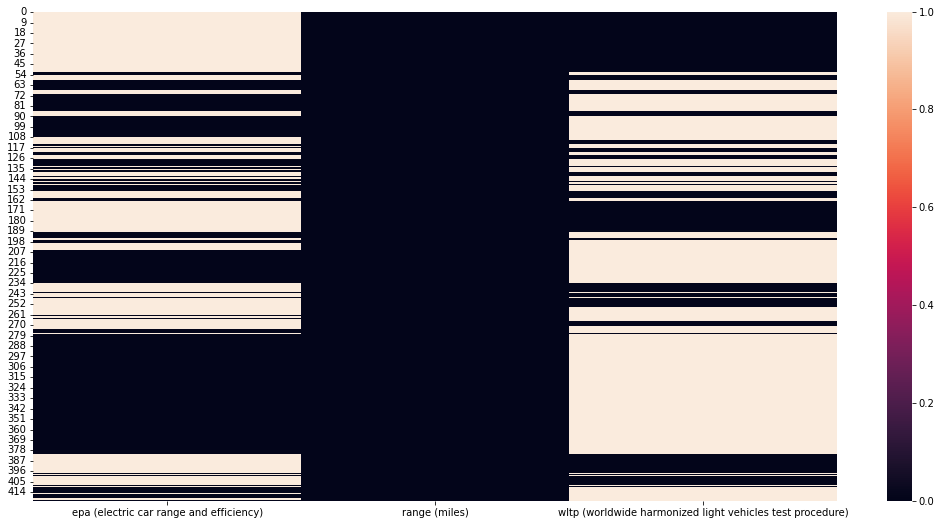

In [62]:
plt.figure(figsize=[18,9])
sns.heatmap(df['Driving range']==0)
# we cannot drop the other columns yet because it would also drop the columns in the next section before manipulation

## Energy efficiency

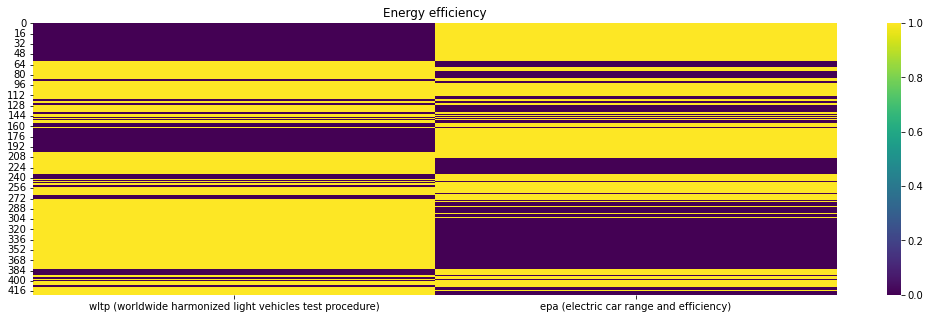

,Feature,Count,Percentage
0,wltp (worldwide harmonized light vehicles test...,267,63
1,epa (electric car range and efficiency),230,55


In [63]:
# create dataframe to input number of missing values and percentages
df_missing = pd.DataFrame(columns=['Feature'], data=nested_dict['Energy efficiency'].keys())
df_i = pd.DataFrame(nested_dict['Energy efficiency'])

# create a plot first to visualise missing data in the sub dictionary
plt.figure(figsize=[18,5])
plt.title('Energy efficiency')
sns.heatmap(df_i==0, cbar=True, cmap='viridis')
plt.show()

# populate the dataframe
df_missing['Count'] = df_missing['Feature'].apply(lambda x: len(df_i[df_i[x]==0]))
df_missing['Percentage'] = df_missing['Count'].apply(lambda x: round(x/len(df_i)*100))
df_missing.sort_values('Percentage', ascending=False, inplace=True)
df_missing

In [64]:
# need to combine to two columns
# can use the previously defined 'range_merger' function
df['Energy efficiency', 'efficiency (MPGe)'] = df['Energy efficiency'].apply(lambda x: range_merger(x[0], x[1]), axis=1)

# place the new column in the correct position in the multi-index
# only know how to do this using 'sort_index'
df = df.sort_index(axis=1)

# reorder df so it is in the original order of outer keys
df = df[list(nested_dict.keys())]

# make a temporary units column
df['Energy efficiency', 'units'] = df['Energy efficiency', 'efficiency (MPGe)'].apply(lambda x: " ".join(x.split()[1:]) if (x!=0) else x)
df = df.sort_index(axis=1)
df = df[list(nested_dict.keys())]

# now that the units column has been made we can extract the numbers from the new efficiency column
df.loc[:, ('Energy efficiency','efficiency (MPGe)')] = df['Energy efficiency', 'efficiency (MPGe)'].apply(lambda x: x.split()[0] if (x!=0) else x)

# convert the column to numeric
df.loc[:, ('Energy efficiency','efficiency (MPGe)')] = pd.to_numeric(df['Energy efficiency', 'efficiency (MPGe)'])

In [65]:
# need to standardise the units. We will convert all units to MPGe
# MPGe = 3370.5 / 1.609344 / kWh/100 km
# MPGe = 3370.5 / kwH/100 miles
# create a function to do this conversion
def efficiency_converter(unit, data):
    if data == 0:
        return data
    elif (data!=0) and ((unit=='kWh/100 km') or (unit=='Wh/km')):
        return (3370.5/1.609344/data)
    elif (data!=0) and (unit=='kWh/100 mi'):
        return (3370.5/data)
    elif unit=='MPGe':
        return data
    else:
        'There is another condition here'

In [66]:
# call the function
df.loc[:, ('Energy efficiency', 'efficiency (MPGe)')] = df['Energy efficiency'][['efficiency (MPGe)', 'units']].apply(lambda x: efficiency_converter(x[1], x[0]), axis=1)

In [67]:
# we can now drop wltp and epa columns from both the driving range and energy efficiency outer index
# we could not do this before because it would have dropped the columns in the energy efficiency section
# ...before we had done any manipulation
df.drop(['wltp (worldwide harmonized light vehicles test procedure)', 'epa (electric car range and efficiency)', 'units'], axis=1, level=1, inplace=True)

<AxesSubplot:>

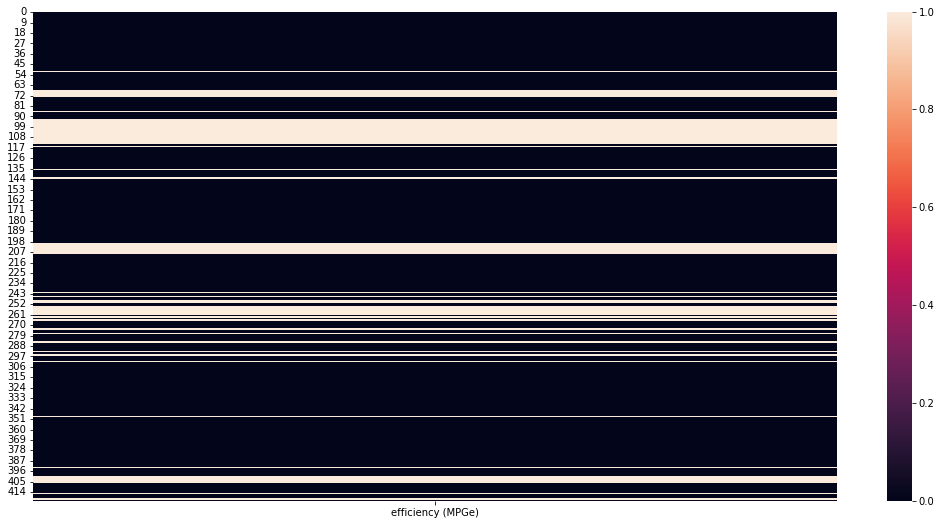

In [68]:
plt.figure(figsize=[18,9])
sns.heatmap(df['Energy efficiency']==0)

In [69]:
# we will fill in the MPGe based on the mean of the respective body style
sub_df = df.loc[:, (['Body style, dimensions, volumes, weights.', 'Energy efficiency'], ['body style', 'efficiency (MPGe)'])]
sub_df.columns = sub_df.columns.get_level_values(1)
group = sub_df.groupby('body style').mean()
group

,efficiency (MPGe)
body style,
Cabriolet,106.475000
Coupe,95.482314
Crossover,102.080449
Hatchback,97.583670
Minivan,78.668877
Pick-up,8.687779
Sedan,97.845853
Sport utility vehicle (SUV),88.246186


In [70]:
# fill in the missing data using the grouped dataframe
df.loc[:, ('Energy efficiency', 'efficiency (MPGe)')] = sub_df.apply(lambda x: group.loc[x[0]][0] if (x[1]==0) else x[1], axis=1)

<AxesSubplot:>

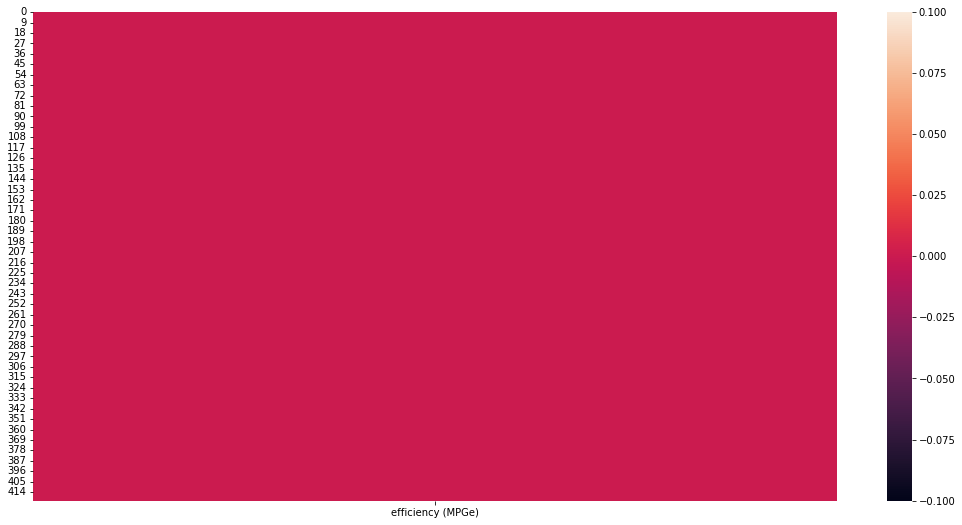

In [71]:
plt.figure(figsize=[18,9])
sns.heatmap(df['Energy efficiency']==0)

## Energy class

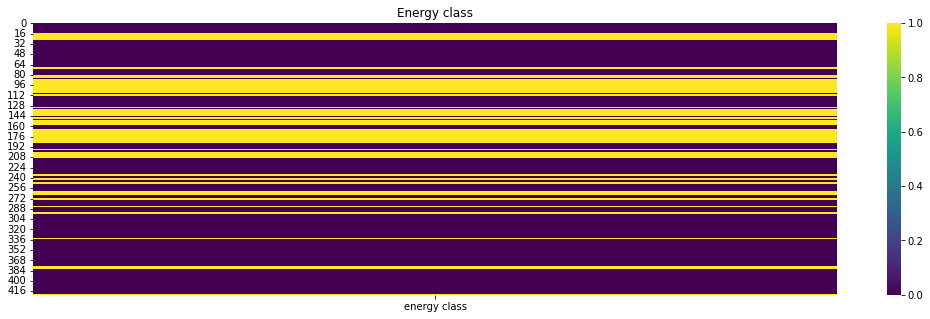

,Feature,Count,Percentage
0,energy class,132,31


In [72]:
# create dataframe to input number of missing values and percentages
df_missing = pd.DataFrame(columns=['Feature'], data=nested_dict['Energy class'].keys())
df_i = pd.DataFrame(nested_dict['Energy class'])

# create a plot first to visualise missing data in the sub dictionary
plt.figure(figsize=[18,5])
plt.title('Energy class')
sns.heatmap(df_i==0, cbar=True, cmap='viridis')
plt.show()

# populate the dataframe
df_missing['Count'] = df_missing['Feature'].apply(lambda x: len(df_i[df_i[x]==0]))
df_missing['Percentage'] = df_missing['Count'].apply(lambda x: round(x/len(df_i)*100))
df_missing.sort_values('Percentage', ascending=False, inplace=True)
df_missing

In [73]:
df['Energy class']['energy class'].value_counts(dropna=False)

0       132
A+      129
A       121
A+++     40
Name: energy class, dtype: int64

The energy class only contains two values; furthermore, efficiency is what determines energy class so we do not need another column which is based on another feature in the dataset. Hence, this section will be dropped.

In [74]:
# drop the energy class section
df.drop('Energy class', axis=1, level=0, inplace=True)

## Steering

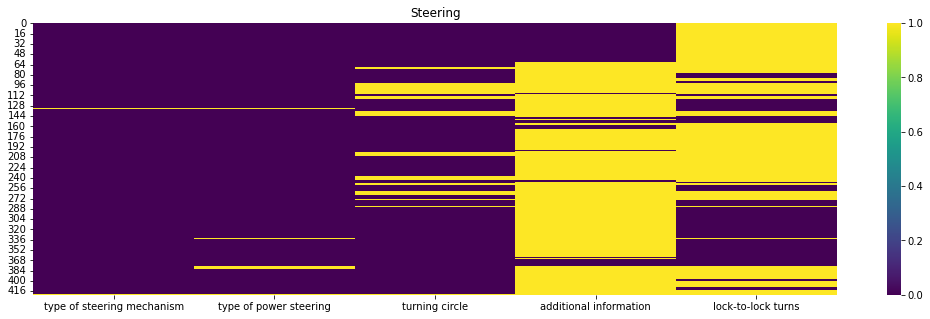

,Feature,Count,Percentage
3,additional information,329,78
4,lock-to-lock turns,258,61
2,turning circle,60,14
1,type of power steering,9,2
0,type of steering mechanism,4,1


In [75]:
# create dataframe to input number of missing values and percentages
df_missing = pd.DataFrame(columns=['Feature'], data=nested_dict['Steering'].keys())
df_i = pd.DataFrame(nested_dict['Steering'])

# create a plot first to visualise missing data in the sub dictionary
plt.figure(figsize=[18,5])
plt.title('Steering')
sns.heatmap(df_i==0, cbar=True, cmap='viridis')
plt.show()

# populate the dataframe
df_missing['Count'] = df_missing['Feature'].apply(lambda x: len(df_i[df_i[x]==0]))
df_missing['Percentage'] = df_missing['Count'].apply(lambda x: round(x/len(df_i)*100))
df_missing.sort_values('Percentage', ascending=False, inplace=True)
df_missing

In [76]:
# drop columns with a lot of missing data
for feature in df_missing[df_missing['Percentage']>20]['Feature'].to_list():
    df.drop(('Steering', feature), axis=1, inplace=True)

### 'type of power steering', 'type of steering mechanism'

In [77]:
df['Steering']['type of power steering'].value_counts(dropna=False)

Electronic    413
0               9
Name: type of power steering, dtype: int64

In [78]:
df['Steering']['type of steering mechanism'].value_counts(dropna=False)

Rack and pinion    418
0                    4
Name: type of steering mechanism, dtype: int64

In [79]:
# each feature only has a single category so this will not help when conducting predictions in the model
# hence both theses features will be dropped
df.drop(('Steering', 'type of steering mechanism'), axis=1, inplace=True)
df.drop(('Steering', 'type of power steering'), axis=1, inplace=True)

### 'turning circle'

In [80]:
# extract meters value from the column using the previously defined function
units = 'meters'

df.loc[:, ('Steering', 'turning circle')] = df['Steering']['turning circle'].apply(lambda x: unit_selector(x).split()[0] if (x!=0) else x)

# make the column a numeric
df.loc[:, ('Steering', 'turning circle')] = pd.to_numeric(df['Steering']['turning circle'])

# rename the column to include the units
df.rename(columns={'turning circle': 'turning circle (metres)'}, inplace=True)

In [81]:
# fill in the missing data by looking at the mean turning circle for each body style
sub_df = df.loc[:, (['Body style, dimensions, volumes, weights.', 'Steering'], ['body style', 'turning circle (metres)'])]
sub_df.columns = sub_df.columns.get_level_values(1)
group = sub_df.groupby('body style').mean()
group

,turning circle (metres)
body style,
Cabriolet,10.000000
Coupe,12.300000
Crossover,7.571429
Hatchback,9.698629
Minivan,11.400000
Pick-up,0.000000
Sedan,11.977229
Sport utility vehicle (SUV),9.126535


In [82]:
# still no data for pick-up trucks
# a google search showed the average pick-up truck turning circle is 14.5 metres
group.loc['Pick-up'] = 14.5
group

,turning circle (metres)
body style,
Cabriolet,10.000000
Coupe,12.300000
Crossover,7.571429
Hatchback,9.698629
Minivan,11.400000
Pick-up,14.500000
Sedan,11.977229
Sport utility vehicle (SUV),9.126535


In [83]:
# now fill in the missing data in the column
df.loc[:, ('Steering', 'turning circle (metres)')] = sub_df.apply(lambda x: group.loc[x[0]][0] if (x[1]==0) else x[1], axis=1)

<AxesSubplot:>

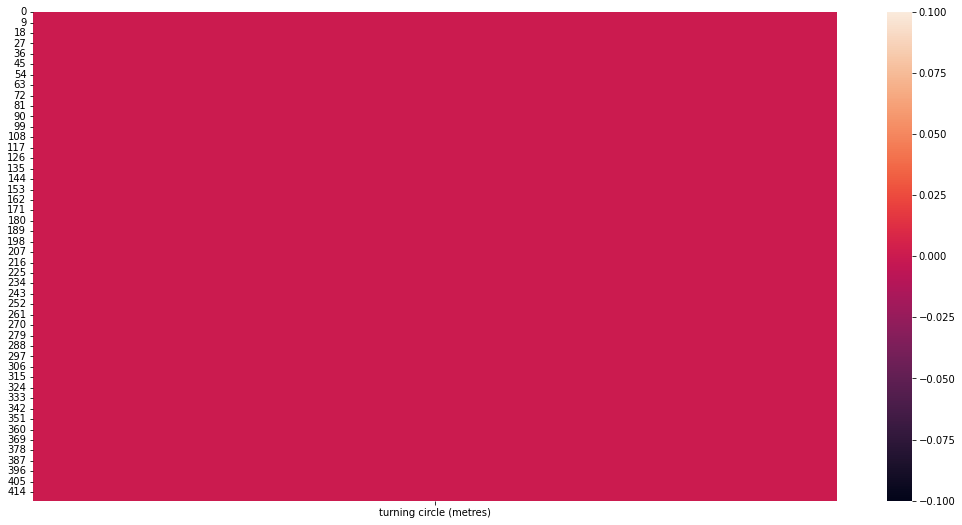

In [84]:
plt.figure(figsize=[18,9])
sns.heatmap(df['Steering']==0)

## Transmission

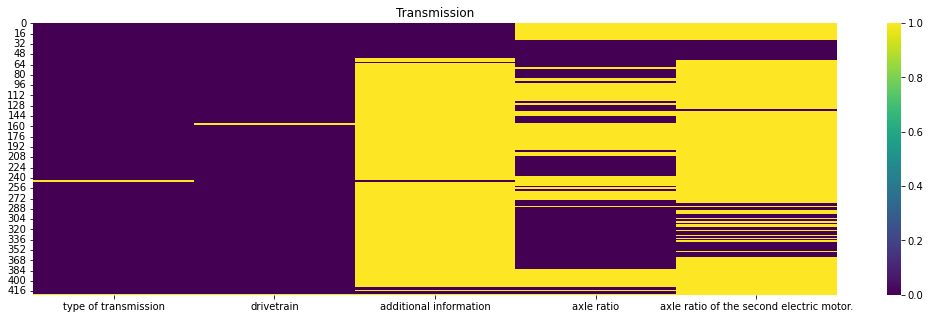

,Feature,Count,Percentage
2,additional information,351,83
4,axle ratio of the second electric motor.,335,79
3,axle ratio,191,45
0,type of transmission,5,1
1,drivetrain,5,1


In [85]:
# create dataframe to input number of missing values and percentages
df_missing = pd.DataFrame(columns=['Feature'], data=nested_dict['Transmission'].keys())
df_i = pd.DataFrame(nested_dict['Transmission'])

# create a plot first to visualise missing data in the sub dictionary
plt.figure(figsize=[18,5])
plt.title('Transmission')
sns.heatmap(df_i==0, cbar=True, cmap='viridis')
plt.show()

# populate the dataframe
df_missing['Count'] = df_missing['Feature'].apply(lambda x: len(df_i[df_i[x]==0]))
df_missing['Percentage'] = df_missing['Count'].apply(lambda x: round(x/len(df_i)*100))
df_missing.sort_values('Percentage', ascending=False, inplace=True)
df_missing

In [86]:
# drop 'axle ratio of the second electric motor.' column
# 'additional information' column would have already been dropped from a previos bit of code
df.drop(('Transmission', 'axle ratio of the second electric motor.'), axis=1, inplace=True)
df.drop(('Transmission', 'additional information'), axis=1, inplace=True)

In [87]:
# check the value counts for 'type of transmission'
df['Transmission']['type of transmission'].value_counts(dropna=False)

Automatic single-speed reduction gear    417
0                                          5
Name: type of transmission, dtype: int64

In [88]:
# there is only one type of transmission in the entire dataset, hence this can be dropped
df.drop(('Transmission', 'type of transmission'), axis=1, inplace=True)

### drivetrain

In [89]:
# check the value counts of the drivetrain
df['Transmission']['drivetrain'].value_counts(dropna=False)

All-wheel drive (AWD)         163
Front-wheel drive (FWD)       130
Rear-wheel drive (RWD)        113
Four-wheel drive (4WD/4x4)     11
0                               5
Name: drivetrain, dtype: int64

In [90]:
# where are the zero values
df.loc[:, (['Brand, model, trim, price', 'Body style, dimensions, volumes, weights.', 'Transmission'], ['brand', 'body style', 'drivetrain'])][df['Transmission']['drivetrain'].eq(0)]

,"Brand, model, trim, price","Body style, dimensions, volumes, weights.",Transmission
,brand,body style,drivetrain
155,Mazda,Sport utility vehicle (SUV),0
156,Mazda,Sport utility vehicle (SUV),0
157,Mazda,Sport utility vehicle (SUV),0
158,Mazda,Sport utility vehicle (SUV),0
421,Volvo,Sport utility vehicle (SUV),0


In [91]:
# what are the most common drivetrain types for SUV's
sub_df = df.loc[:, (['Body style, dimensions, volumes, weights.', 'Transmission'], ['body style', 'drivetrain'])]
sub_df.columns = sub_df.columns.get_level_values(1)
group = sub_df.groupby(['body style']).agg(lambda x: x.value_counts(dropna=False).index[0])
group

,drivetrain
body style,
Cabriolet,Rear-wheel drive (RWD)
Coupe,All-wheel drive (AWD)
Crossover,Front-wheel drive (FWD)
Hatchback,Front-wheel drive (FWD)
Minivan,Front-wheel drive (FWD)
Pick-up,All-wheel drive (AWD)
Sedan,All-wheel drive (AWD)
Sport utility vehicle (SUV),All-wheel drive (AWD)


In [92]:
# fill in missing data with most common drivetrain assembly for the respective body type
df.loc[:, ('Transmission', 'drivetrain')] = sub_df.apply(lambda x: group.loc[x[0]][0] if (x[1]==0) else x[1], axis=1)

### axle ratio

In [93]:
# need to convert axle ratio column to numeric
df.loc[:, ('Transmission', 'axle ratio')] = pd.to_numeric(df['Transmission']['axle ratio'])

In [94]:
# heavier vehicles have a higher optimum axle ratio
# body style will influence what the weight of the vehicle and hence the optimum axle ratio
# the missing data will be filled in based on body style
sub_df = df.loc[:, (['Body style, dimensions, volumes, weights.', 'Transmission'], ['body style', 'axle ratio'])]
sub_df.columns = sub_df.columns.get_level_values(1)
group = sub_df.groupby('body style').mean()
group

,axle ratio
body style,
Cabriolet,8.275200
Coupe,7.599000
Crossover,5.861429
Hatchback,4.118487
Minivan,0.000000
Pick-up,0.000000
Sedan,8.347398
Sport utility vehicle (SUV),3.483653


In [95]:
# google the average axle ratio for pick-up trucks which comes out at 3.55
group.loc['Pick-up'] = 3.55

# and the same for minivan
group.loc['Minivan'] = 3.8

In [96]:
# fill in the missing data with the grouped table
df.loc[:, ('Transmission', 'axle ratio')] = sub_df.apply(lambda x: group.loc[x[0]][0] if (x[1]==0) else x[1], axis=1)

<AxesSubplot:>

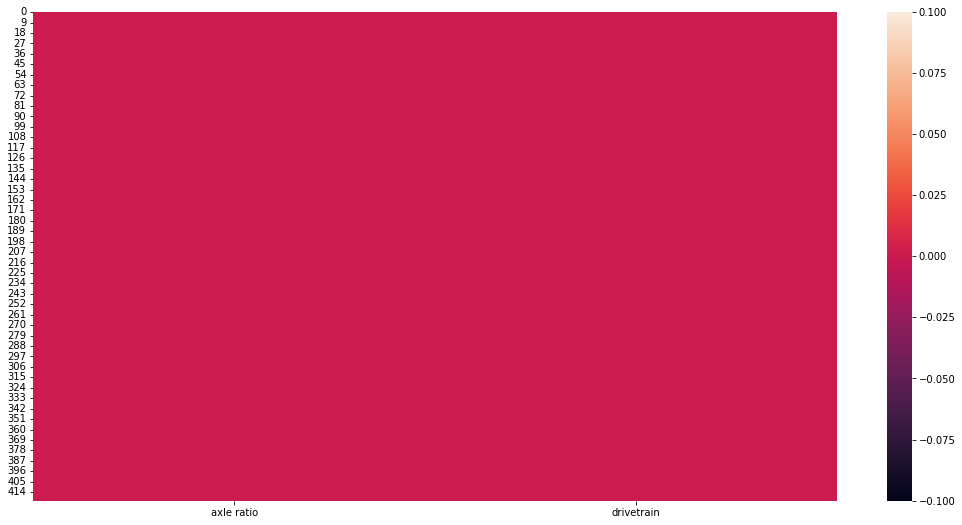

In [97]:
# check to see if there are any errors left
plt.figure(figsize=[18,9])
sns.heatmap(df['Transmission']==0)

## Suspension

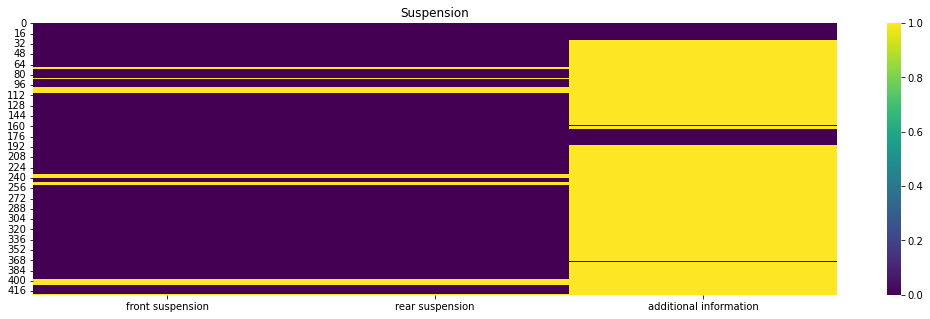

,Feature,Count,Percentage
2,additional information,364,86
0,front suspension,33,8
1,rear suspension,33,8


In [98]:
# create dataframe to input number of missing values and percentages
df_missing = pd.DataFrame(columns=['Feature'], data=nested_dict['Suspension'].keys())
df_i = pd.DataFrame(nested_dict['Suspension'])

# create a plot first to visualise missing data in the sub dictionary
plt.figure(figsize=[18,5])
plt.title('Suspension')
sns.heatmap(df_i==0, cbar=True, cmap='viridis')
plt.show()

# populate the dataframe
df_missing['Count'] = df_missing['Feature'].apply(lambda x: len(df_i[df_i[x]==0]))
df_missing['Percentage'] = df_missing['Count'].apply(lambda x: round(x/len(df_i)*100))
df_missing.sort_values('Percentage', ascending=False, inplace=True)
df_missing

In [99]:
# drop additional informaiton column
df.drop(('Suspension', 'additional information'), axis=1, inplace=True)

### Front supension

In [100]:
# how many unique values are there in the front suspension column
df['Suspension']['front suspension'].nunique()

63

In [101]:
# what is the format of the data
df.loc[:, ('Suspension', 'front suspension')].value_counts(dropna=False)

Independent\nMacPherson strut\nShock absorbers\nCoil springs (helical springs)                                                      33
0                                                                                                                                   33
Independent\nMacPherson strut\nCoil springs (helical springs)\nAnti-roll bar (stabilizer link / stabilizer bar)                     31
Independent\nDouble wishbone\nAnti-roll bar (stabilizer link / stabilizer bar)\nShock absorbers\nSmart Air Suspension (optional)    28
Independent\nMacPherson strut\nShock absorbers\nCoil springs (helical springs)\nAnti-roll bar (stabilizer link / stabilizer bar)    28
                                                                                                                                    ..
Independent\nMacPherson strut\nElectronic shock absorbers                                                                            1
Independent\nMacPherson strut\nAdaptive dampers        

The format of the data between each car model is not consistent. There are 55 unique values. Due to the high ratio between the number of unique values and the total number of vehicle models (330) this would not have such a significant effect on the model. Hence, it will not be used in the model and will be dropped.

In [102]:
# drop the front suspension column
df.drop(('Suspension', 'front suspension'), axis=1, inplace=True)

### rear suspension

In [103]:
# how many unique values are there in the front suspension column
df['Suspension']['rear suspension'].nunique()

65

In [104]:
# what is the format of the data
df.loc[:, ('Suspension', 'rear suspension')].value_counts(dropna=False)

0                                                                                                                              33
Independent\nMulti-link\nAnti-roll bar (stabilizer link / stabilizer bar)\nShock absorbers\nSmart Air Suspension (optional)    28
Independent\nFour-link\nCoil springs (helical springs                                                                          27
Independent\nMulti-link\nAnti-roll bar (stabilizer link / stabilizer bar)\nCoil springs (helical springs)\nShock absorbers     26
Torsion beam (twist beam / torsion bar)\nAnti-roll bar (stabilizer link / stabilizer bar)                                      21
                                                                                                                               ..
Independent\nMulti-link\nElectronic shock absorbers                                                                             1
Air springs\nPneumatic (air suspension)\nIndependent\nMulti-link\nAIRMATIC air suspension 

In [105]:
# drop the front suspension column
df.drop(('Suspension', 'rear suspension'), axis=1, inplace=True)

## Brakes

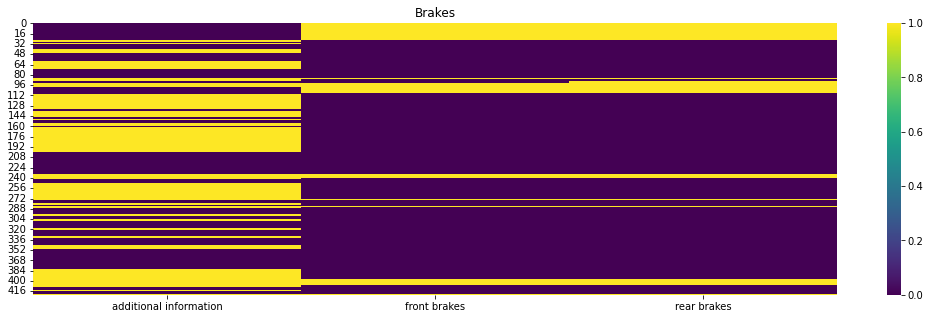

,Feature,Count,Percentage
0,additional information,201,48
2,rear brakes,67,16
1,front brakes,64,15


In [106]:
# create dataframe to input number of missing values and percentages
df_missing = pd.DataFrame(columns=['Feature'], data=nested_dict['Brakes'].keys())
df_i = pd.DataFrame(nested_dict['Brakes'])

# create a plot first to visualise missing data in the sub dictionary
plt.figure(figsize=[18,5])
plt.title('Brakes')
sns.heatmap(df_i==0, cbar=True, cmap='viridis')
plt.show()

# populate the dataframe
df_missing['Count'] = df_missing['Feature'].apply(lambda x: len(df_i[df_i[x]==0]))
df_missing['Percentage'] = df_missing['Count'].apply(lambda x: round(x/len(df_i)*100))
df_missing.sort_values('Percentage', ascending=False, inplace=True)
df_missing

In [107]:
# drop additional informaiton column
df.drop(('Brakes', 'additional information'), axis=1, inplace=True)

### rear brakes

In [108]:
# what are the unique values in the 'rear brakes' column
df['Brakes']['rear brakes'].value_counts(dropna=True)

Ventilated discs    182
Discs               137
0                    67
Drums                36
Name: rear brakes, dtype: int64

In [109]:
# see where the values for zero are
sub_df = df.loc[:, (['Body style, dimensions, volumes, weights.', 'Brand, model, trim, price', 'Brakes'], ['body style', 'rear brakes'])]
sub_df.columns = sub_df.columns.get_level_values(1)
sub_df[sub_df['rear brakes']==0]

,body style,rear brakes
0,Sport utility vehicle (SUV),0
1,Sport utility vehicle (SUV),0
2,Sport utility vehicle (SUV),0
3,Sport utility vehicle (SUV),0
4,Sport utility vehicle (SUV),0
...,...,...
403,Hatchback,0
404,Hatchback,0
405,Hatchback,0
406,Hatchback,0


In [110]:
# fill in the blanks with the corresponding body style
sub_df = df.loc[:, (['Body style, dimensions, volumes, weights.', 'Brand, model, trim, price', 'Brakes'], ['body style', 'rear brakes'])]
sub_df.columns = sub_df.columns.get_level_values(1)
sub_df
group = sub_df.groupby(['body style']).agg(lambda x: x.value_counts().index[0])
group.loc['Pick-up', 'rear brakes'] = 'Discs'
group

,rear brakes
body style,
Cabriolet,Ventilated discs
Coupe,Ventilated discs
Crossover,Discs
Hatchback,Discs
Minivan,Discs
Pick-up,Discs
Sedan,Ventilated discs
Sport utility vehicle (SUV),Ventilated discs


In [111]:
# swap 0 values in the data
df.loc[:, ('Brakes','rear brakes')] = sub_df[['body style', 'rear brakes']].apply(lambda x: group.loc[x[0], 'rear brakes'] if x[1]==0 else x[1], axis=1)

### front brakes

In [112]:
# what are the unique values in the 'rear brakes' column
df['Brakes']['front brakes'].value_counts(dropna=True)

Ventilated discs    327
0                    64
Discs                31
Name: front brakes, dtype: int64

In [113]:
# see where the values for zero are
sub_df = df.loc[:, (['Body style, dimensions, volumes, weights.', 'Brand, model, trim, price', 'Brakes'], ['body style', 'front brakes'])]
sub_df.columns = sub_df.columns.get_level_values(1)
sub_df[sub_df['front brakes']==0]

,body style,front brakes
0,Sport utility vehicle (SUV),0
1,Sport utility vehicle (SUV),0
2,Sport utility vehicle (SUV),0
3,Sport utility vehicle (SUV),0
4,Sport utility vehicle (SUV),0
...,...,...
403,Hatchback,0
404,Hatchback,0
405,Hatchback,0
406,Hatchback,0


In [114]:
# fill in the blanks with the corresponding body style
sub_df = df.loc[:, (['Body style, dimensions, volumes, weights.', 'Brand, model, trim, price', 'Brakes'], ['body style', 'front brakes'])]
sub_df.columns = sub_df.columns.get_level_values(1)
sub_df
group = sub_df.groupby(['body style']).agg(lambda x: x.value_counts().index[0])
group.loc['Pick-up', 'front brakes'] = 'Ventilated discs'
group

,front brakes
body style,
Cabriolet,Ventilated discs
Coupe,Ventilated discs
Crossover,Ventilated discs
Hatchback,Ventilated discs
Minivan,Ventilated discs
Pick-up,Ventilated discs
Sedan,Ventilated discs
Sport utility vehicle (SUV),Ventilated discs


In [115]:
# swap 0 values in the data
df.loc[:, ('Brakes','front brakes')] = sub_df[['body style', 'front brakes']].apply(lambda x: group.loc[x[0], 'front brakes'] if x[1]==0 else x[1], axis=1)

<AxesSubplot:>

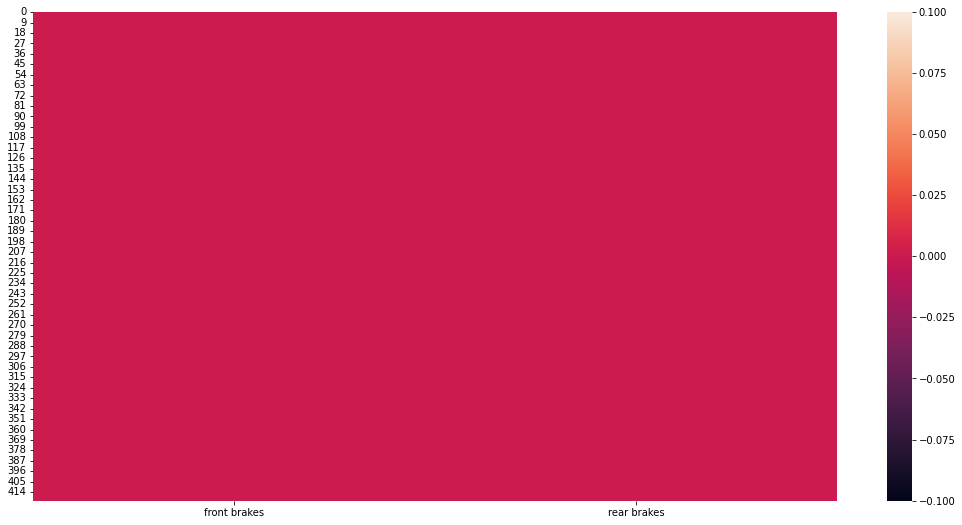

In [116]:
# see how many errors are left
plt.figure(figsize=[18,9])
sns.heatmap(df['Brakes']==0)

## Battery

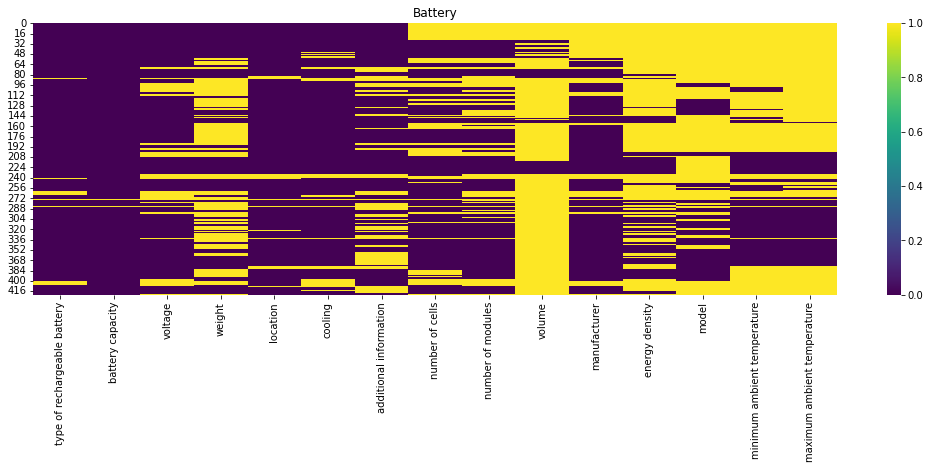

,Feature,Count,Percentage
9,volume,365,86
11,energy density,291,69
12,model,277,66
14,maximum ambient temperature,277,66
13,minimum ambient temperature,256,61
3,weight,206,49
8,number of modules,147,35
6,additional information,131,31
7,number of cells,125,30
10,manufacturer,113,27


In [117]:
# create dataframe to input number of missing values and percentages
df_missing = pd.DataFrame(columns=['Feature'], data=nested_dict['Battery'].keys())
df_i = pd.DataFrame(nested_dict['Battery'])

# create a plot first to visualise missing data in the sub dictionary
plt.figure(figsize=[18,5])
plt.title('Battery')
sns.heatmap(df_i==0, cbar=True, cmap='viridis')
plt.show()

# populate the dataframe
df_missing['Count'] = df_missing['Feature'].apply(lambda x: len(df_i[df_i[x]==0]))
df_missing['Percentage'] = df_missing['Count'].apply(lambda x: round(x/len(df_i)*100))
df_missing.sort_values('Percentage', ascending=False, inplace=True)
df_missing

In [118]:
# drop columns with too much missing data
for feature in df_missing[df_missing['Percentage']>35]['Feature'].to_list():
    df.drop(('Battery', feature), axis=1, inplace=True)

### Manufacturer

In [119]:
sub_df = df.loc[:, (['Brand, model, trim, price', 'Body style, dimensions, volumes, weights.', 'Electric motor', 'Battery'], ['model year', 'manufacturer'])]
sub_df.columns = sub_df.columns.get_level_values(1)
sub_df
group = sub_df.groupby(['model year']).agg(lambda x: x.value_counts().index[0])
group.reset_index(inplace=True)
group['model years'] = group['model year'].apply(lambda x: '2000-2010' if (x in np.arange(2000,2011)) else '2010+')
group = group.groupby(['model years']).agg(lambda x: x.value_counts().index[0])
group

# coupe and cabriolet similar designs have same battery
#group.loc['Coupe', 'manufacturer'] = 'Panasonic'
group

,model year,manufacturer
model years,,
2000-2010,2008,Panasonic
2010+,2011,Panasonic


In [120]:
sub_df.loc[:, 'model years'] = sub_df.loc[:, 'model year'].apply(lambda x: '2000-2010' if (x in np.arange(2000,2011)) else '2010+')
df.loc[:, ('Battery', 'manufacturer')] = sub_df[['manufacturer', 'model years']].apply(lambda x: group.loc[x[1], 'manufacturer'] if x[0]==0 else x[0], axis=1)

C:\Python_Projects\virtual_environment_jupyter_MSX\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


#### Now that the manufacturers have been fill in other missing battery data through grouping by manufacturer and aggregating by the mean

<AxesSubplot:>

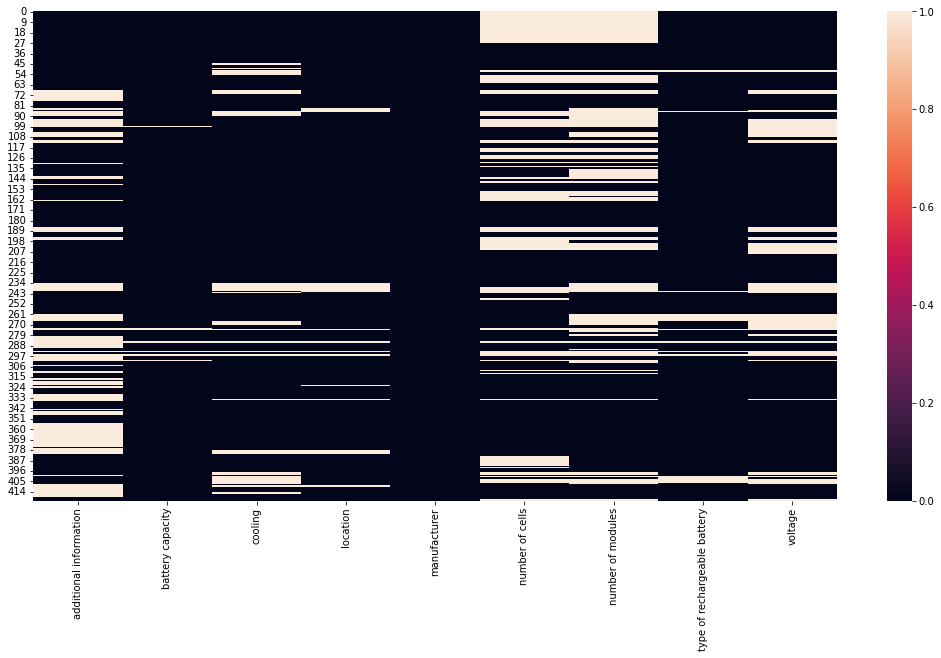

In [121]:
plt.figure(figsize=[18,9])
sns.heatmap(df['Battery']==0)

### Additional information

In [122]:
# the additional information column does not have a standard data form
# drop the additional information column
df.drop(('Battery', 'additional information'), axis=1, inplace=True)

### Numerical columns

In [123]:
# extract numbers from the necessary columns
# battery capacity
df.loc[:, ('Battery', 'battery capacity')] = df['Battery']['battery capacity'].apply(lambda x: str(x).split()[0])
#voltage
df.loc[:, ('Battery', 'voltage')] = df['Battery']['voltage'].apply(lambda x: str(x).split()[0])


# change column names to include units
df.rename(columns={'battery capacity': 'battery capacity (kWh)', 'voltage':'voltage (V)'}, inplace=True)

In [124]:
df.columns.get_level_values(1)

Index(['brand', 'market', 'model', 'model year', 'price', 'body style',
       'curb weight', 'drag coefficient', 'front track', 'gvwr', 'height',
       'length', 'materials', 'number of doors', 'number of seats',
       'rear track', 'trunk volume', 'wheelbase', 'electric motor type',
       'location of the motor', 'power', 'torque',
       'acceleration from 0 to 100 km/h', 'top speed', 'range (miles)',
       'efficiency (MPGe)', 'turning circle (metres)', 'axle ratio',
       'drivetrain', 'front brakes', 'rear brakes', 'battery capacity (kWh)',
       'cooling', 'location', 'manufacturer', 'number of cells',
       'number of modules', 'type of rechargeable battery', 'voltage (V)'],
      dtype='object')

In [125]:
df.loc[:, (['Body style, dimensions, volumes, weights.', 'Battery'], 'number of doors')]

,"Body style, dimensions, volumes, weights."
,number of doors
0,5
1,5
2,5
3,5
4,5
...,...
417,4
418,4
419,4


In [126]:
# change all number columns to numerical data types
num_cols = ['battery capacity (kWh)', 'number of cells', 'number of modules', 'voltage (V)']

for col in num_cols:
    # for battery
    df.loc[:, ('Battery', col)] = pd.to_numeric(df['Battery'][col])
    
# num_cols = ['number of doors', 'number of seats']

# for col in num_cols:
#     # for Body style, dimensions, volumes, weights. etc etc
#     df.loc[:, ('Body style, dimensions, volumes, weights.', col)] = pd.to_numeric(df['Body style, dimensions, volumes, weights.'][col])

In [127]:
# create two group by df's
# group by manufacturer
# group by body style
sub_df = df.loc[:, (['Body style, dimensions, volumes, weights.', 'Battery'], ['body style', 'manufacturer', 'battery capacity (kWh)', 'number of cells', 'number of modules', 'voltage (V)'])]
sub_df.columns = sub_df.columns.get_level_values(1)
sub_df
manufacturer_group = sub_df.groupby(['manufacturer']).mean()
bodystyle_group = sub_df.groupby(['body style']).mean()

In [128]:
manufacturer_group

,battery capacity (kWh),number of cells,number of modules,voltage (V)
manufacturer,,,,
A123 Systems,21.300000,336.000000,0.000000,0.000000
AESC,32.571429,202.285714,38.035714,321.242857
CATL,64.376923,0.000000,2.769231,131.676923
Deutsche Accumotive,17.600000,96.000000,3.000000,0.000000
LG Chem,61.104545,322.151515,8.166667,322.854545
LG Chem and Deutsche ACCUMOTIVE,74.082222,175.555556,4.166667,377.597222
Panasonic,73.034694,3072.811224,119.750000,292.007143
Panasonic-Sanyo,22.628571,246.857143,24.142857,337.571429
Renault and LG Chem,42.195833,192.000000,12.000000,361.833333


In [129]:
bodystyle_group

,battery capacity (kWh),number of cells,number of modules,voltage (V)
body style,,,,
Cabriolet,58.400000,5464.800000,8.800000,300.000000
Coupe,83.300000,252.000000,21.000000,396.833333
Crossover,49.050000,217.142857,11.142857,482.285714
Hatchback,38.894758,149.443548,15.741935,291.511290
Minivan,75.000000,0.000000,0.000000,0.000000
Pick-up,93.562500,2916.000000,0.000000,0.000000
Sedan,80.463373,5329.012048,12.096386,368.536145
Sport utility vehicle (SUV),72.860588,996.105882,133.735294,325.805882


In [130]:
# fill in missing data manually
bodystyle_group.loc['Minivan', ['number of cells', 'number of modules', 'voltage (V)']] = [3000, 150, 400]
bodystyle_group.loc['Pick-up', ['number of modules', 'voltage (V)']] = [150, 400]

In [131]:
# iterate through numeric columns to replace the missing data using the two groups
for col in num_cols:
    df.loc[:, ('Battery', col)] = sub_df[['manufacturer', col]].apply(lambda x: manufacturer_group.loc[x[0], col] if (x[1]==0) else x[1], axis=1)
    df.loc[:, ('Battery', col)] = sub_df[['body style', col]].apply(lambda x: bodystyle_group.loc[x[0], col] if (x[1]==0) else x[1], axis=1)

### String columns

In [132]:
# create two group by df's
# group by manufacturer
# group by body style
sub_df = df.loc[:, (['Body style, dimensions, volumes, weights.', 'Battery'], ['body style', 'manufacturer', 'cooling', 'location', 'type of rechargeable battery'])]
sub_df.columns = sub_df.columns.get_level_values(1)
sub_df
manufacturer_group = sub_df.groupby(['manufacturer']).agg(lambda x: x.value_counts().index[0])
bodystyle_group = sub_df.groupby(['body style']).agg(lambda x: x.value_counts().index[0])

In [133]:
manufacturer_group.loc['A123 Systems', 'location'] = 'Under the floor, middle'
manufacturer_group

,body style,cooling,location,type of rechargeable battery
manufacturer,,,,
A123 Systems,Hatchback,Water-based coolant circulation,"Under the floor, middle",Lithium-Ion
AESC,Hatchback,Air convection (passive),"Under the floor, middle",Lithium-Ion
CATL,Sport utility vehicle (SUV),Water-based coolant circulation,"Under the floor, middle",Lithium-Ion
Deutsche Accumotive,Hatchback,Water-based coolant circulation,"Under the floor, middle",Lithium-Ion
LG Chem,Sport utility vehicle (SUV),Water-based coolant circulation,"Under the floor, middle",Lithium-Ion
LG Chem and Deutsche ACCUMOTIVE,Sport utility vehicle (SUV),Water-based coolant circulation\nHeat pipe,"Under the floor, middle",Lithium-Ion
Panasonic,Sport utility vehicle (SUV),Water-based coolant circulation,"Under the floor, middle",Lithium-Ion
Panasonic-Sanyo,Hatchback,Passive cooling,"Under the floor, middle",Lithium-Ion
Renault and LG Chem,Hatchback,Air convection,"Under the floor, middle",Lithium-Ion


In [134]:
bodystyle_group

,manufacturer,cooling,location,type of rechargeable battery
body style,,,,
Cabriolet,Panasonic,0,0,Lithium-Ion
Coupe,Panasonic,Water-based coolant circulation,"Under the floor, middle",Lithium-Ion
Crossover,SK Innovation,Water-based coolant circulation,"Under the floor, middle",Li-Ion Polymer
Hatchback,LG Chem,Water-based coolant circulation,"Under the floor, middle",Lithium-Ion
Minivan,LG Chem and Deutsche ACCUMOTIVE,Water-based coolant circulation,"Under the floor, middle",Lithium-Ion
Pick-up,Panasonic,Water-based coolant circulation,"Under the floor, middle",0
Sedan,Panasonic,Water-based coolant circulation,"Under the floor, middle",Lithium-Ion
Sport utility vehicle (SUV),Panasonic,Water-based coolant circulation,"Under the floor, middle",Lithium-Ion


In [135]:
# iterate through each string column and replace with manufacturer group
string_cols = ['cooling', 'location', 'type of rechargeable battery']

for col in string_cols:
    df.loc[:, ('Battery', col)] = sub_df[['manufacturer', col]].apply(lambda x: manufacturer_group.loc[x[0], col] if (x[1]==0) else x[1], axis=1)

<AxesSubplot:>

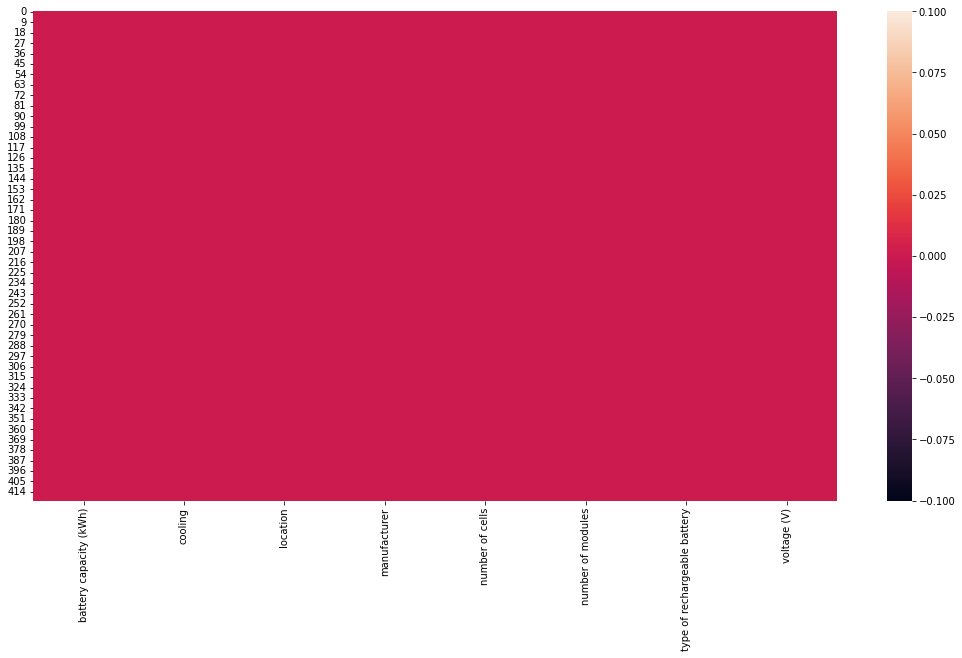

In [136]:
plt.figure(figsize=[18,9])
sns.heatmap(df['Battery']==0)

## Addressing the missing price data

### Extracting the relevant section of df to then clean and preprocess

In [137]:
# isolate the pricing data
df_price = df.loc[:, ('Brand, model, trim, price')].copy()

In [138]:
# how many missing values are there and for which vehicles
print("Total number of models is {}".format(df_price.shape[0]))

print("The number of missing prices is {}".format(df_price[df_price['price']==0].shape[0]))

Total number of models is 422
The number of missing prices is 204


In [139]:
# extract the valuation date
df_price['valuation date'] = df_price['price'].apply(lambda x: x.split('(')[1].split('\n')[0].split(',')[1] if x!=0 and '\n' in x else (x.split('(')[1].split(',')[1] if x!=0 else x)).str.replace(")", "")

# extract the currency
df_price['currency'] = df_price['price'].apply(lambda x: x.split()[0] if x!=0 else x)

# now extract just the price figure from the price column and overwrite
df_price['price'] = df_price['price'].apply(lambda x: x.split()[1] if x!=0 else x)

C:\Users\EDavey\AppData\Local\Temp/ipykernel_25420/4204690785.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_price['valuation date'] = df_price['price'].apply(lambda x: x.split('(')[1].split('\n')[0].split(',')[1] if x!=0 and '\n' in x else (x.split('(')[1].split(',')[1] if x!=0 else x)).str.replace(")", "")


In [140]:
# strip the valuation date column so there are no spaces at the front or behind
df_price['valuation date'] = df_price['valuation date'].str.strip()

In [141]:
# clean price column and format as number dtype
df_price['price'].replace(",","", regex=True, inplace=True)
df_price['price'] = pd.to_numeric(df_price['price'])

### Use requests to get data from an exchange rate API

In [142]:
def get_yearly_rates(amount, currency, converted_currency, end_date, start_date):
    
    # sets the start date
#     today_date = datetime.datetime.today()
#     date_1year = (today_date - datetime.timedelta(days=1 + amount_of_days))
    end_date = end_date
    start_date = start_date
    
    # Requests
    url = f'https://api.exchangerate.host/timeseries'
#     input_ = {'base': currency, 'amount':amount, 'start_date':date_1year.date(),
#                 'end_date':today_date.date()}
    input_ = {'base': currency, 'amount':amount, 'start_date':start_date.date(),
                 'end_date':end_date.date()}
    
    response = requests.get(url, params=input_)
    data = response.json()
    
    # create a dict to store data
    currency_history = {}
    rate_history_array = []
    
    for item in data['rates']:
        currency_date = item
        currency_rate = data['rates'][item][converted_currency]
        
        currency_history[currency_date] = [currency_rate]
        rate_history_array.append(currency_rate)
    
    # clean data
    df_currency = pd.DataFrame(currency_history).transpose()
    df_currency.columns = [currency+':'+converted_currency]
    pd.set_option('display.max_rows', None)
    return df_currency

### API request only responds with 1 years worth of data at a time. Create a for loop to extract the last 5 years for all respective currencies

In [143]:
df['Brand, model, trim, price']['price'].apply(lambda x: x.split()[0] if x!=0 else np.nan).value_counts().index.to_list()

['USD', 'EUR', 'GBP', 'CNY']

In [144]:
df_rates = pd.DataFrame()

# list of currencies contained in the data scraped from the website
currencies = ['EUR', 'GBP', 'USD', 'CNY']

for x in np.arange(12):
    end_date = datetime.today() - relativedelta(years=(1*x))
    start_date = datetime.today() - relativedelta(years=(1*x)+1)
    
    df_rates_i = pd.DataFrame()
    
    for currency in currencies:
        if currency=='GBP':
            continue
        else:
            df_rates_i = pd.concat([df_rates_i, get_yearly_rates(1, currency, 'GBP', end_date, start_date)], axis=1)
    
    df_rates=pd.concat([df_rates, df_rates_i])

C:\Python_Projects\virtual_environment_jupyter_MSX\lib\site-packages\cryptography\hazmat\backends\openssl\x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


### Clean df_rates and match the monthly format of df_price

In [145]:
# reset the index
df_rates.reset_index(inplace=True)

In [146]:
# clean rates df
df_rates.rename(columns={'index':'Date'}, inplace=True)

In [147]:
# convert date column from dtype object to datetime
df_rates['Date'] = pd.to_datetime(df_rates['Date'])

In [148]:
# sort by date column
df_rates.sort_values(['Date'], ascending=False, inplace=True)

In [149]:
# # create month number column and year column
# df_rates['Month'] = df_rates['Date'].apply(lambda x: x.month)
# df_rates['Year'] = df_rates['Date'].apply(lambda x: x.year)

In [150]:
# create breakdown by month
df_rates['Month & Year'] = df_rates['Date'].apply(lambda x: x.strftime("%b %Y"))

In [151]:
# group by month and take average
df_rates = df_rates.groupby(['Month & Year']).mean()
df_rates

,EUR:GBP,USD:GBP,CNY:GBP
Month & Year,,,
Apr 2011,0.882533,0.611617,0.093812
Apr 2012,0.822773,0.624906,0.099440
Apr 2013,0.850107,0.653230,0.105771
Apr 2014,0.824763,0.597311,0.096069
Apr 2015,0.723150,0.670170,0.108286
Apr 2016,0.793253,0.699694,0.108292
Apr 2017,0.848320,0.792113,0.115184
Apr 2018,0.872210,0.710295,0.112922
Apr 2019,0.862283,0.767877,0.114479


### Convert all prices to GBP and overwrite 'price' column in df

In [152]:
# create a function to convert all prices to GBP
def gbp_converter(price, valuation_date, currency):
    
    if currency in ['GBP', 0]:
        return price
    
    else:
        for x in df_rates.columns:
            if currency in x:
                col = x
            else:
                continue
        conversion = price * df_rates.loc[valuation_date, col]
        return conversion
                

In [153]:
# apply conversion function
df_price['Price (£)'] = df_price[['price', 'valuation date', 'currency']].apply(lambda x: gbp_converter(x[0], x[1], x[2]), axis=1)

In [154]:
# overwrite df 'price' column
df.loc[:, ('Brand, model, trim, price', 'price')] = df_price['Price (£)']

# change the column name
df.rename(columns={'price':'price (£)'}, inplace=True)

#### Now fill in the missing pricing data based on body type

In [155]:
# create two group by df's
# group by manufacturer
# group by body style
sub_df = df.loc[:, (['Brand, model, trim, price', 'Body style, dimensions, volumes, weights.'], ['body style', 'price (£)'])]
sub_df.columns = sub_df.columns.get_level_values(1)
sub_df
group = sub_df.groupby(['body style']).mean()

# replace missing data with average price of electric minivan and cabriolet
group.loc['Minivan', 'price (£)'] = 39000
group.loc['Cabriolet', 'price (£)'] = 31000

In [156]:
# fill in the missing data
df.loc[:, ('Brand, model, trim, price', 'price (£)')] = sub_df[['body style', 'price (£)']].apply(lambda x: group.loc[x[0], 'price (£)'] if x[1]==0 else x[1], axis=1)

<AxesSubplot:xlabel='None-None'>

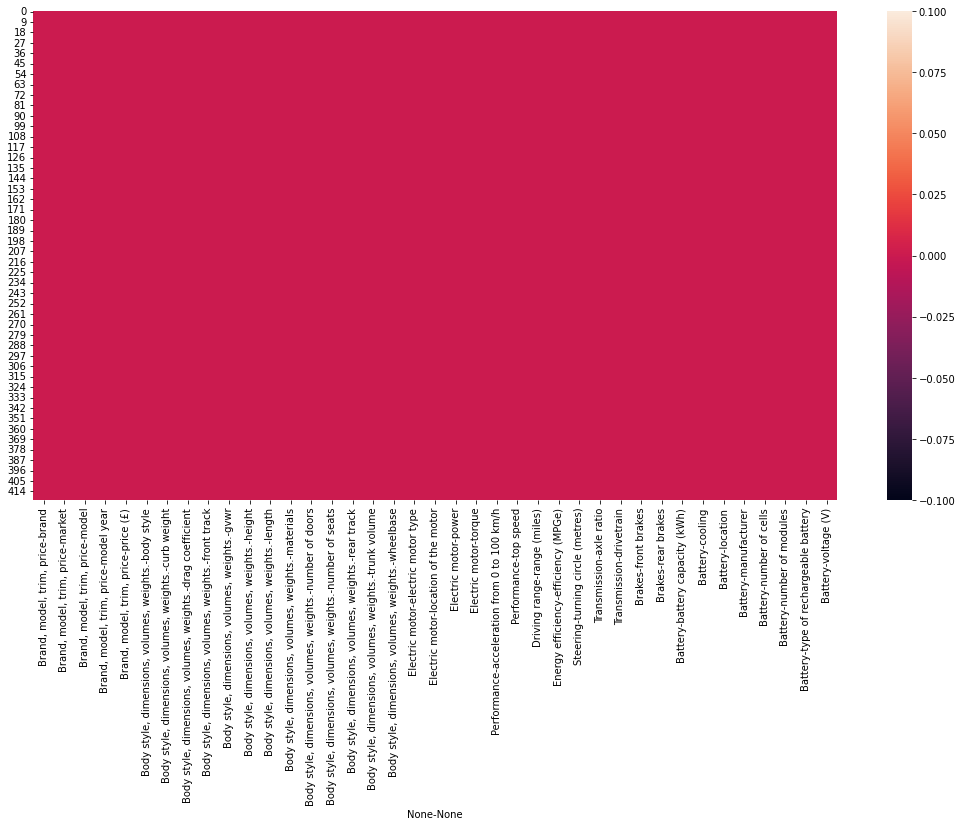

In [157]:
# check for missing data in the entire df
plt.figure(figsize=[18,9])
sns.heatmap(df==0)

In [158]:
# NOTE: this section has been added because an error was spotted in the website
# 3 VW ID3 models were given a price above 300,000 Euros which is obviously not correct
# hence these must be corrected before storing into SQL database
# if not changed these outliers will affect the machine learning model accuracy
# the errors makes them outliers so find them using mean and standard deviation
upper_limit = df['Brand, model, trim, price']['price (£)'].mean() + (df['Brand, model, trim, price']['price (£)'].std() * 3)
lower_limit = df['Brand, model, trim, price']['price (£)'].mean() - (df['Brand, model, trim, price']['price (£)'].std() * 3)


# locate where they are in the dataframe
indices = df[df['Brand, model, trim, price']['price (£)']>upper_limit][1:].index

# now replace them
df.loc[indices, ('Brand, model, trim, price', 'price (£)')] = df['Brand, model, trim, price'].loc[indices, 'price (£)']/10

# DATA CLEANING COMPLETED!!!

# Selenium to search for missing prices

Note that this approach was difficult becasue websites would not allow me to scrape data. Hence I took a more straightforward approach to save time for the project

In [ ]:
# # create a search column which you will enter into website for pricing data
# df_price.loc[:, 'Search'] = df_price.loc[:, 'brand'] + " " + df_price.loc[:, 'model']

In [ ]:
# price_search_list = list(df_price[df_price['price']==0]['Search'])

In [ ]:
# # url is an electric vehicle specification website
# # intended to be a structured database for all new electric car models
# driver_path = r'C:\Python_Projects\chromedriver.exe'
# url = 'https://ev-database.uk/#sort:path~type~order=.rank~number~desc|range-slider-range:prev~next=0~600|range-slider-towweight:prev~next=0~2500|range-slider-acceleration:prev~next=2~23|range-slider-fastcharge:prev~next=0~1100|range-slider-lease:prev~next=150~2500|range-slider-topspeed:prev~next=60~260|paging:currentPage=0|paging:number=9'

# service = Service("C:\Python_Projects\chromedriver.exe")

# # specify which browser
# driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

# # go to url
# driver.get(url)

In [ ]:
# # accept cookies
# driver.find_elements(By.XPATH, '/html/body/div[2]/div[2]/div[1]/div[2]/div[2]/button[1]')[0].click()

### Now create a for loop to iterate through all the missing models

##### V1

In [ ]:
# prices_dict = {}

# for model in price_search_list:
#     print(model)
#     prices_dict[model] = []
    
#     # input model into search bar
#     driver.find_elements(By.XPATH, '/html/body/header/div[1]/section/div[2]/div/div/input')[0].send_keys(model)
    
#     for link in driver.find_elements(By.TAG_NAME, 'a'):
#         try:
#             if model in link.text:
#                 link.click()
#                 prices_dict[model].append(driver.find_element(By.XPATH, '/html/body/main/div/div/section[2]/div[1]/div[1]/h2').text)
#                 driver.back()
#             else:
#                 continue
#         except StaleElementReferenceException:
#             continue
    
#     # clear search bar ready for next iteration
#     driver.find_elements(By.XPATH, '/html/body/header/div[1]/section/div[2]/div/div/input')[0].send_keys(Keys.CONTROL, 'a')
#     driver.find_elements(By.XPATH, '/html/body/header/div[1]/section/div[2]/div/div/input')[0].send_keys(Keys.BACKSPACE)
    

# prices_dict

##### V2

In [ ]:
# prices_dict = {}

# for model in price_search_list:
#     print(model)
#     prices_dict[model] = []
    
#     # input model into search bar
#     driver.find_elements(By.XPATH, '/html/body/header/div[1]/section/div[2]/div/div/input')[0].send_keys(model)
    
#     # see if the model is there
#     try:
#         driver.find_element(By.XPATH, ('//a/span[2][contains(translate(text(), "ABCDEFGHIJKLMNOPQRSTUVWXYZ", "abcdefghijklmnopqrstuvwxyz"), "{}")]'.format("".join(model.split()[1:]).split()[1:]))).click()
#         # extract price info
#         prices_dict[model].append(driver.find_element(By.XPATH, '/html/body/main/div/div/section[2]/div[1]/div[1]/h2').text)
#         driver.back()
#     except NoSuchElementException:
#         pass
    
#     try:
#         # clear search bar ready for next iteration
#         driver.find_elements(By.XPATH, '/html/body/header/div[1]/section/div[2]/div/div/input')[0].send_keys(Keys.CONTROL, 'a')
#         driver.find_elements(By.XPATH, '/html/body/header/div[1]/section/div[2]/div/div/input')[0].send_keys(Keys.BACKSPACE)
#     except IndexError:
#         driver.find_elements(By.XPATH, '/html/body/header/div[1]/section/div[2]/div/div/input').send_keys(Keys.CONTROL, 'a')
#         driver.find_elements(By.XPATH, '/html/body/header/div[1]/section/div[2]/div/div/input').send_keys(Keys.BACKSPACE)

    
    
# prices_dict

In [ ]:
# driver.find_element(By.XPATH, ('//a/span[2][contains(translate(text(), "ABCDEFGHIJKLMNOPQRSTUVWXYZ", "abcdefghijklmnopqrstuvwxyz"), "{}")]'.format("".join(price_search_list[30].split()[1:])))).click()

In [ ]:
# driver.find_element(By.PARTIAL_LINK_TEXT, "Fiat").click()

The data has now been cleaned. The next stage is to store the dataframe in an SQL database hosted on Amazon Web Services Cloud platform so allow for easy querying in the future.

# Data Engineering. Storing data in an SQL database hosted on AWS

### Connect to MySQL database

In [162]:
# connect to mysql database
# define credentials
server = 'edportfoliomysql.c0spjpahzq1i.eu-west-2.rds.amazonaws.com' 
database = 'edportfoliomysql' 
username = 'admin' 
password = '987654321' 

# connect to database
conn = pymysql.connect(user=username, password=password, host=server, database=database)

# create cursor
cursor = conn.cursor()

In [ ]:
# delete table from sql database
cursor.execute("DROP TABLE EV_SPEC;")

### Create empty table in MySQL database

In [ ]:
# define a function that creates the query string to create a table in mysql
def create_sql_table(dataframe, table_name):
    
    query_string = "CREATE TABLE {} (".format(table_name)
    
    # check if dataframe has multi index column structure
    if isinstance(dataframe.columns, pd.MultiIndex):
        dataframe.columns = dataframe.columns.get_level_values(1)
    else:
        pass
    
    for index, x in enumerate(zip(dataframe.dtypes, dataframe.columns)):
        
        feature = ""
        for word in x[1].split():
            word = word.replace("(", "")
            word = word.replace(")", "")
            word = word.replace(".", "")
            word = word.replace(",", "_")
            word = word.replace("strength", "str")
            feature = feature + word[0].upper() + word[1:]

        if x[0]=='object':
            if index!=len(dataframe.columns)-1:
                query_string = query_string + " " + feature + " " + "VARCHAR(255),"
            else:
                query_string = query_string + " " + feature + " " + "VARCHAR(255));"

        elif x[0]=='int32' or x[0]=='int64':
            if index!=len(dataframe.columns)-1:
                query_string = query_string + " " + feature + " " + "INT,"
            else:
                query_string = query_string + " " + feature + " " + "INT);"

        elif x[0]=='float64':
            if index!=len(dataframe.columns)-1:
                query_string = query_string + " " + feature + " " + "FLOAT,"
            else:
                query_string = query_string + " " + feature + " " + "FLOAT);"
            
        elif x[0]=='uint8':
            if index!=len(dataframe.columns)-1:
                query_string = query_string + " " + feature + " " + "INT,"
            else:
                query_string = query_string + " " + feature + " " + "INT);"


        else:
            print("There is another data type")
    
    query_string = query_string.replace("/", "per")

    return query_string

In [ ]:
# call function an execute with the cursor to create the table
cursor.execute(create_sql_table(df, 'EV_SPEC'))

# commit the changes
conn.commit()

### Insert scraped and pre-processed data into empty table in MySQL

In [ ]:
# create a function to insert data into specified SQL table
def insert_sql_data(dataframe, tablename):  
    query_insert = "INSERT INTO {} VALUES ".format(tablename)
    
    # check if the column structure is a multi index
    if isinstance(dataframe.columns, pd.MultiIndex):
        dataframe.columns = dataframe.columns.get_level_values(1)
    else:
        pass    

    for i in range(dataframe.shape[0]):
        query_insert += "("

        for dtype, col in zip(dataframe.dtypes, dataframe.columns):
            if dtype=='object':
                data = "'" + str(dataframe[col][i]) + "'"
                data = data.replace("(", "").replace(")", "").replace("-","").replace("\n"," ").replace("/","")
                data = data.replace("!","").replace("%","").replace("&","")
                query_insert += data + ', '

            else:
                data = str(dataframe[col][i])
                query_insert += data + ', '

        query_insert = query_insert[:-2] + '), '

    query_insert = query_insert[:-2] + ';'
    
    return query_insert

In [ ]:
# call function to create sql query to insert data into specified table
cursor.execute(insert_sql_data(df, "EV_SPEC"))

# commit the changes
conn.commit()

### Use pandas to create dataframe from sql query of the data that has just been stored

In [ ]:
# select data from sql table
cursor.execute("SELECT * FROM EV_SPEC;")

In [163]:
# define the sql query
query = "SELECT * FROM EV_SPEC;"

# query the database
df = pd.read_sql(query, conn)

In [ ]:
# close connection
conn.close()

#### Next step is to analyse the data before building a machine learning model on price

# Data Analysis

In [164]:
# look at the info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422 entries, 0 to 421
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Brand                         422 non-null    object 
 1   Market                        422 non-null    object 
 2   Model                         422 non-null    object 
 3   ModelYear                     422 non-null    int64  
 4   Price£                        422 non-null    float64
 5   BodyStyle                     422 non-null    object 
 6   CurbWeight                    422 non-null    float64
 7   DragCoefficient               422 non-null    float64
 8   FrontTrack                    422 non-null    float64
 9   Gvwr                          422 non-null    float64
 10  Height                        422 non-null    float64
 11  Length                        422 non-null    float64
 12  Materials                     422 non-null    object 
 13  Numbe

In [165]:
# look at statistical metrics of the dataframe
df.describe()

,ModelYear,Price£,CurbWeight,DragCoefficient,FrontTrack,Gvwr,Height,Length,RearTrack,TrunkVolume,...,AccelerationFrom0To100Kmperh,TopSpeed,RangeMiles,EfficiencyMPGe,TurningCircleMetres,AxleRatio,BatteryCapacityKWh,NumberOfCells,NumberOfModules,VoltageV
count,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,...,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000
mean,2019.151659,34112.564692,1886.987227,0.280711,1571.054242,2316.983389,1549.095118,4582.077156,1575.560308,511.556564,...,6.865345,180.785886,227.082526,104.269708,11.030813,6.463880,65.981299,2066.514100,95.749525,379.602953
std,2.814238,17564.755898,423.776506,0.069148,121.726570,515.179855,143.171696,469.107352,118.746639,267.911026,...,2.502827,38.473280,74.029532,24.457937,1.287910,2.664157,25.744854,2771.909154,595.998061,90.853784
min,2008.000000,11785.100000,921.000000,0.200000,847.000000,1204.800000,160.000000,2695.000000,986.000000,140.000000,...,2.200000,109.786000,51.000000,8.687780,6.950000,3.069000,14.500000,16.000000,2.000000,234.000000
25%,2017.000000,22883.600000,1538.000000,0.240000,1539.000000,1966.000000,1454.750000,4261.000000,1525.000000,340.000000,...,5.200000,150.000000,189.500000,93.528925,10.200000,3.483650,45.000000,200.000000,12.000000,327.000000
50%,2020.000000,29838.200000,1885.660000,0.270000,1585.000000,2265.000000,1568.000000,4588.000000,1575.000000,479.500000,...,6.800000,167.521000,238.500000,105.328000,10.900000,7.412000,66.500000,384.000000,16.000000,360.000000
75%,2021.000000,39053.250000,2175.000000,0.290000,1661.000000,2660.000000,1617.500000,4963.000000,1672.000000,645.600000,...,8.275000,209.000000,270.000000,118.324000,11.827000,9.205000,84.000000,4062.000000,48.000000,400.000000
max,2023.000000,148699.000000,2783.000000,0.680000,1730.000000,3500.000000,1905.000000,5911.000000,1735.000000,2831.700000,...,13.500000,320.000000,500.200000,164.908000,14.500000,9.734000,135.000000,8256.000000,7104.000000,800.000000


<AxesSubplot:xlabel='Price£', ylabel='Count'>

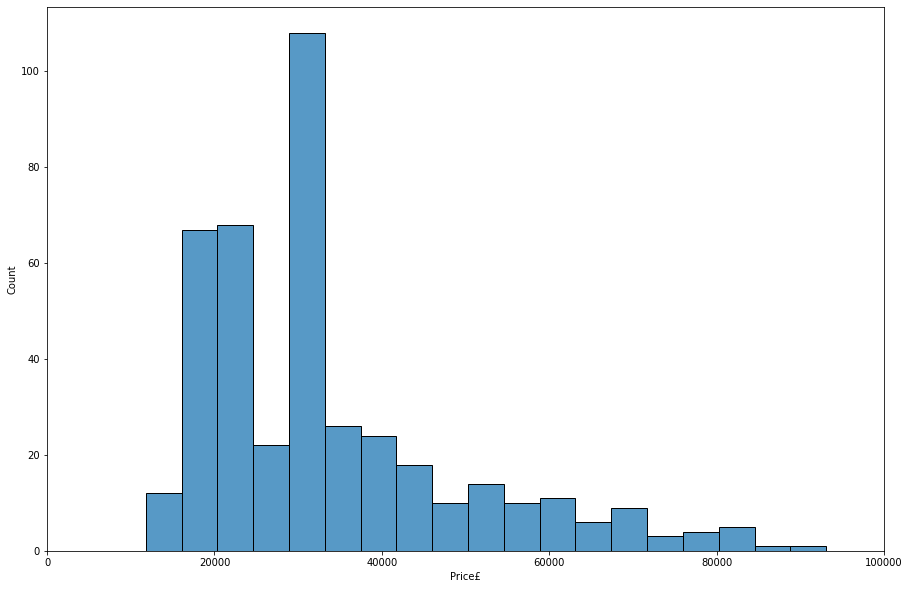

In [166]:
# look at the distribution of price (£)
plt.figure(figsize=[15,10])
plt.xlim(0, 100000)
sns.histplot(df['Price£'])
# lack of data is evident in the graph with extremely concentrated price bins

<AxesSubplot:>

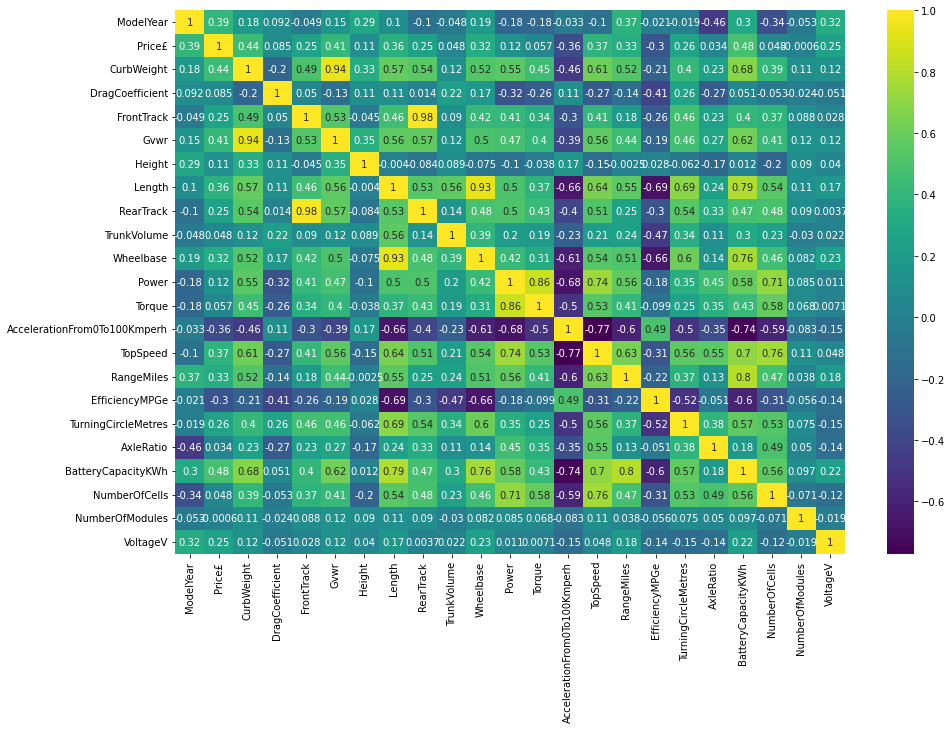

In [167]:
# show a correlation matrix of all variables
plt.figure(figsize=[15,10])
sns.heatmap(df.corr(), annot=True, cmap='viridis')

## A dashboard has been made using power bi and has been posted publically online to view using the following link:

https://app.powerbi.com/view?r=eyJrIjoiYzcwYTZiNWQtYWFkNS00Mjk5LTljMDQtNGFjODVlMzRjNWZjIiwidCI6IjRkMWZhZjhhLTliNGYtNDExNS1iYWY4LWYzMTA2MjdmYzFmNyIsImMiOjh9

# Preparing the dataset for a machine learning model

This is a personal note to consider reading some articles on data leakage if some variables are repeated somewhat. For example Gross Vehicle Weight (Gvwr) and curb weight reflect similar variables; or front track and rear track???

## Feature Engineering

In [168]:
# drop the model column because the intended use for the model is to predict price of new vehicles
df.drop('Model', axis=1, inplace=True)

### outliers

C:\Python_Projects\virtual_environment_jupyter_MSX\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Price£', ylabel='Density'>

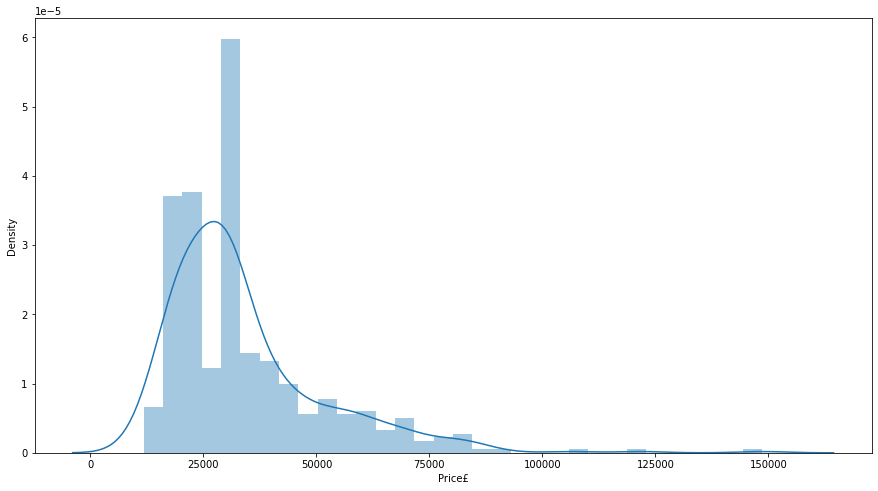

In [169]:
# see if there are any price outliers
plt.figure(figsize=[15,8])
sns.distplot(df['Price£'])

In [170]:
# it looks like there are a few outliers
# use standard deviation to identify upper and lower limits for outliers
# we will go for any vehicle with a price that is 3 std's above the mean
# and 3 std's below the mean for a lower limit
upper_limit = df['Price£'].mean() + (df['Price£'].std() * 3)
lower_limit = df['Price£'].mean() - (df['Price£'].std() * 3)

In [171]:
# have a look to see what the outliers are before filtering the dataframe
df[df['Price£']>upper_limit]

,Brand,Market,ModelYear,Price£,BodyStyle,CurbWeight,DragCoefficient,FrontTrack,Gvwr,Height,...,FrontBrakes,RearBrakes,BatteryCapacityKWh,Cooling,Location,Manufacturer,NumberOfCells,NumberOfModules,TypeOfRechargeableBattery,VoltageV
244,Porsche,"North America, Europe",2020,89555.6,Sedan,2220.0,0.22,1709.0,2880.0,1379.0,...,Ventilated discs,Ventilated discs,93.4000,Waterbased coolant circulation,"Under the floor, middle",LG Chem,396.00,12.0000,LithiumIon,800.000
245,Porsche,"North America, Europe",2020,148699.0,Sedan,2295.0,0.25,1690.0,2870.0,1378.0,...,Ventilated discs,Ventilated discs,93.4000,Waterbased coolant circulation,"Under the floor, middle",LG Chem,396.00,33.0000,LithiumIon,800.000
246,Porsche,"North America, Europe",2020,121672.0,Sedan,2305.0,0.22,1702.0,2880.0,1381.0,...,Ventilated discs,Ventilated discs,93.4000,Waterbased coolant circulation,"Under the floor, middle",LG Chem,396.00,33.0000,LithiumIon,800.000
273,Tesla,North America,2022,105960.0,Sedan,2241.0,0.24,1661.0,2720.0,1435.0,...,Ventilated discs,Ventilated discs,80.4634,Waterbased coolant circulation,"Under the floor, middle",Panasonic,5329.01,12.0964,LithiumIon,368.536


In [172]:
# now filter the df
df = df[df['Price£']<upper_limit]

# reset the index
df.reset_index(drop=True, inplace=True)

### Categorical Variables and Dummy Variables

In [173]:
# use pd.get_dummies to convert categorical variables to dummy variables
# remember to use drop_first = True so that there is no data leakage
# concatenate get_dummies dataframe to df
# also remove the original columns
df = pd.concat([df, pd.get_dummies(df.select_dtypes('object'), drop_first=True)], axis=1)
df.drop(df.select_dtypes('object').columns, axis=1, inplace=True)

## Save adjusted machine learning dataframe to sql server database on amazon web services

In [ ]:
# create connection again incase the connection has already been closed
# connect to mysql database
# define credentials
server = 'edportfoliomysql.c0spjpahzq1i.eu-west-2.rds.amazonaws.com' 
database = 'edportfoliomysql' 
username = 'admin' 
password = '987654321' 

# connect to database
conn = pymysql.connect(user=username, password=password, host=server, database=database)

# create cursor
cursor = conn.cursor()

In [ ]:
# use the functions previously defined when saving the origional dataframe to sql server
# first drop the table if it already exists
cursor.execute("DROP TABLE EV_SPEC_NN;")

In [ ]:
# call function an execute with the cursor to create the table
cursor.execute(create_sql_table(df, "EV_SPEC_NN"))

# commit the changes
conn.commit()

In [ ]:
# call function an execute with the cursor to create the table
cursor.execute(insert_sql_data(df, "EV_SPEC_NN"))

# commit the changes
conn.commit()

In [ ]:
# create the option to extract the table from the sql database
query = "SELECT * FROM EV_SPEC_NN;"

df = pd.read_sql(query, conn)

In [ ]:
# close connection
conn.close()

### Scaling and splitting the data into training set and testing set

Artificial Neural Nets will not accept dataframe structures; hence, the values need to be extracted.

In [174]:
# split the data into 'X' and 'Y'
# 'Y' is the predictor variable which in this case is car price
# 'X' will be the entire dataset apart from the price variable
X = df.drop('Price£', axis=1).values
y = df['Price£'].values

In [175]:
# now split the data into a training set and a testing set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [176]:
# train the scaler using x_train
# onced trained...scale both x_train and x_test datasets
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
# save the scaler using pickle
with open('ev_regression_scaler', 'wb') as file:
    pickle.dump(scaler, file)

In [ ]:
# this is the code to load the scaler file using pickle
# with open('ev_regression_scaler', 'rb') as scaler_file:
#     scaler = pickle.load(scaler_file)

# Building the Artificial Neural Network Model

The neural net will resemble the following construction: 145--> 72--> 36--> 18--> 1.

A rectified linear unit (ReLU) activation function will be used for the input and hidden layers of the net. Furthermore, for the output layer a rectified linear unit will also be used because this is not a binary classification and the results must not be a number between 0 and 1.

The loss function will be mean squared error (MSE) seeing as it is a regression model. Furthermore, the optimizer used will be Adam seeing as this is generally the best performing optimizer.

Dropout layers help against overfitting on the training data. This involves a random percentage of nodes being switched off in a given layer each epoch. Dropout layers will be added to the input and the hidden layer but obviously not the output layer.

Lastly, early stopping will be implemented so that the model will stop as soon as the loss function reaches a minimum. This will save time on training the model.

In [177]:
# how many inputs does the data have?
x_train.shape[1]

145

In [178]:
# creating an instance of Sequential()
model = Sequential()

# input layer
model.add(Dense(units=145, activation='relu'))
model.add(Dropout(0.2))

# hidden layer 1
model.add(Dense(units=72, activation='relu'))
model.add(Dropout(0.2))

# hidden layer 2
model.add(Dense(units=36, activation='relu'))
model.add(Dropout(0.2))

# hidden layer 3
model.add(Dense(units=18, activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=1, activation='relu'))


# now compile the model
# it is a regression model so the loss function will be mean squared error
model.compile(loss='mse', optimizer='adam')

In [179]:
# creating an early_stop variable to add into the model
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=25, verbose=1)

In [180]:
# fit the model
model.fit(x_train, y_train, batch_size=3, epochs=500, verbose=1, callbacks=early_stop, validation_data=(x_test,y_test))

Epoch 1/500
112/112 [==============================] - 2s 5ms/step - loss: 1359797888.0000 - val_loss: 1203130496.0000
Epoch 2/500
112/112 [==============================] - 0s 3ms/step - loss: 673835776.0000 - val_loss: 250776752.0000
Epoch 3/500
112/112 [==============================] - 0s 3ms/step - loss: 247668320.0000 - val_loss: 164401104.0000
Epoch 4/500
112/112 [==============================] - 0s 3ms/step - loss: 217013248.0000 - val_loss: 113684136.0000
Epoch 5/500
112/112 [==============================] - 0s 3ms/step - loss: 172769184.0000 - val_loss: 96893656.0000
Epoch 6/500
112/112 [==============================] - 0s 3ms/step - loss: 194883824.0000 - val_loss: 84824760.0000
Epoch 7/500
112/112 [==============================] - 0s 3ms/step - loss: 162863264.0000 - val_loss: 78226616.0000
Epoch 8/500
112/112 [==============================] - 0s 3ms/step - loss: 138278240.0000 - val_loss: 62452828.0000
Epoch 9/500
112/112 [==============================] - 0s 4ms/step

112/112 [==============================] - 0s 3ms/step - loss: 81867552.0000 - val_loss: 41329760.0000
Epoch 72/500
112/112 [==============================] - ETA: 0s - loss: 96298176.000 - 0s 3ms/step - loss: 102379064.0000 - val_loss: 38789752.0000
Epoch 73/500
112/112 [==============================] - 0s 3ms/step - loss: 76307240.0000 - val_loss: 36583796.0000
Epoch 74/500
112/112 [==============================] - 0s 3ms/step - loss: 102137744.0000 - val_loss: 65133892.0000
Epoch 75/500
112/112 [==============================] - 0s 3ms/step - loss: 81582728.0000 - val_loss: 33367754.0000
Epoch 76/500
112/112 [==============================] - 0s 3ms/step - loss: 79825960.0000 - val_loss: 43165408.0000
Epoch 77/500
112/112 [==============================] - 0s 3ms/step - loss: 80219232.0000 - val_loss: 34707560.0000
Epoch 78/500
112/112 [==============================] - 0s 3ms/step - loss: 74397456.0000 - val_loss: 32429290.0000
Epoch 79/500
112/112 [==============================

In [ ]:
# save the neural network model
model.save('EV ANN Regression Model.h5')

In [ ]:
# option to load the model
#model = load_model('EV ANN Regression Model.h5')

# Evaluate Model Performance

In [181]:
# save both the training loss and the validation loss and put them into a dataframe
df_loss = pd.DataFrame(model.history.history)
df_loss.head()

,loss,val_loss
0,1.359798e+09,1.203130e+09
1,6.738358e+08,2.507768e+08
2,2.476683e+08,1.644011e+08
3,2.170132e+08,1.136841e+08
4,1.727692e+08,9.689366e+07


<AxesSubplot:>

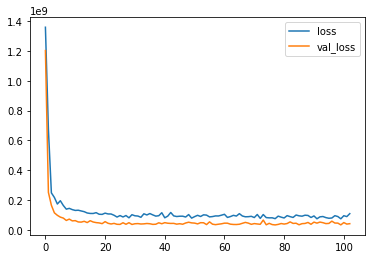

In [182]:
# visualise the loss results
df_loss.plot()

In [183]:
# extracting predictions using x_test from the model
yhat = model.predict(x_test)
yhat

array([[21256.715],
       [34030.52 ],
       [17854.23 ],
       [19805.963],
       [16504.04 ],
       [15776.023],
       [21361.88 ],
       [38058.293],
       [32761.01 ],
       [39286.88 ],
       [17194.156],
       [34962.355],
       [39998.31 ],
       [17884.959],
       [26790.04 ],
       [16724.49 ],
       [27052.877],
       [26839.803],
       [34889.484],
       [33918.95 ],
       [36355.32 ],
       [17705.732],
       [16020.827],
       [17475.225],
       [23724.615],
       [18430.486],
       [25160.363],
       [31898.615],
       [28938.555],
       [45866.137],
       [23181.455],
       [35000.41 ],
       [27297.549],
       [54208.027],
       [21479.658],
       [27711.314],
       [27063.234],
       [18824.49 ],
       [10446.367],
       [47040.   ],
       [28941.553],
       [29111.479],
       [32289.287],
       [16224.946],
       [31779.707],
       [17145.924],
       [29070.08 ],
       [34686.05 ],
       [36178.46 ],
       [35873.09 ],


In [184]:
# caculating mean absolute error
mean_absolute_error(y_test, yhat)

4099.928264508929

In [185]:
# calculate square root of mean squared error
np.sqrt(mean_squared_error(y_test, yhat))

6384.571431562032

In [186]:
# calculate explained variance score
explained_variance_score(y_test, yhat)

0.820699783834585

In [187]:
# compare these values with the mean of the price column
df['Price£'].mean()

33324.43947368421

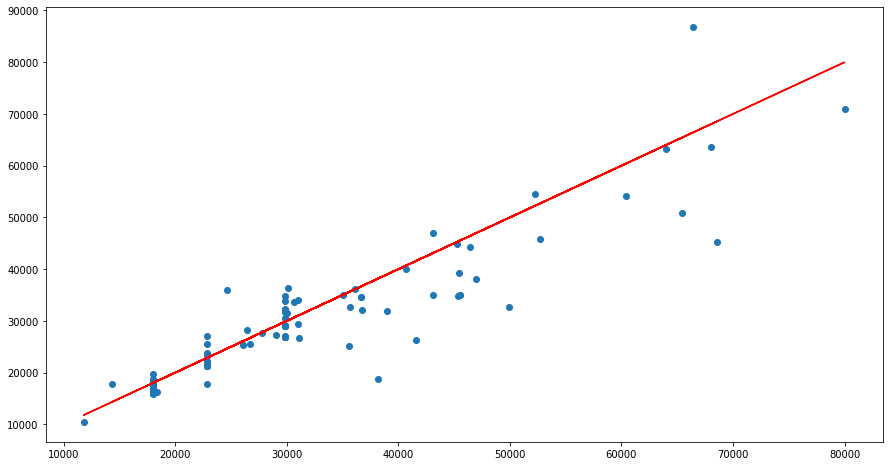

In [188]:
# visualise the predictions against perfect predictions
plt.figure(figsize=[15,8])
plt.scatter(y_test, yhat)

# perfect predictions
plt.plot(y_test, y_test, 'r')

C:\Python_Projects\virtual_environment_jupyter_MSX\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

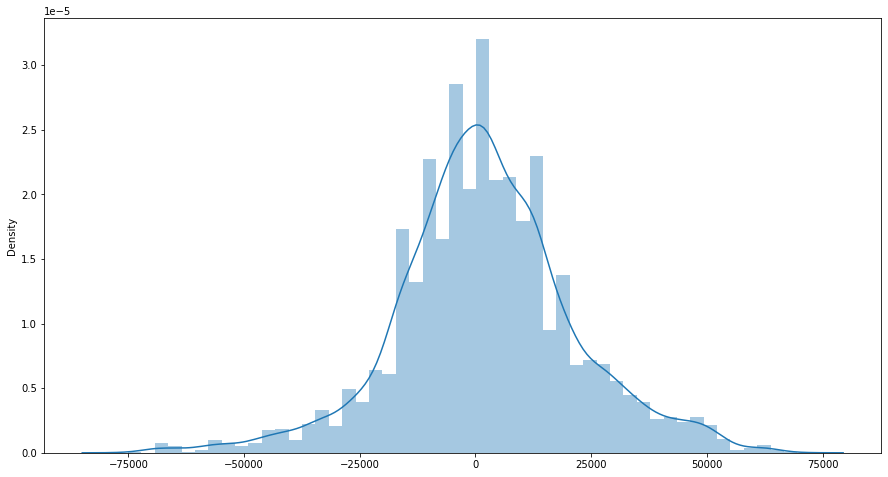

In [189]:
# calculate difference between true values and predictions
errors = y_test.reshape(1, -1) - yhat

# visualise with a distribution
plt.figure(figsize=[15, 8])
sns.distplot(errors)

## Predicting a brand new vehicle

In [190]:
# pick a single row of data from df
single_car = df.drop('Price£', axis=1).iloc[62].values.reshape(1,-1)
single_car

array([[2.0180e+03, 1.2650e+03, 3.2000e-01, 1.5720e+03, 1.6900e+03,
        1.5900e+03, 4.0060e+03, 1.5570e+03, 2.6000e+02, 2.5700e+03,
        1.3500e+02, 2.7000e+02, 6.9000e+00, 1.6000e+02, 1.0700e+02,
        1.1235e+02, 1.0310e+01, 9.6650e+00, 3.3200e+01, 9.6000e+01,
        8.0000e+00, 3.5300e+02, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.00

In [191]:
# scale the inputs
single_car = scaler.transform(single_car)
single_car

array([[-0.43005033, -1.3994872 ,  0.48116144, -0.00786949, -1.17360001,
         0.27634916, -1.17358512, -0.17087166, -0.88913541, -0.93655668,
        -0.30947168, -0.66698433, -0.03083435, -0.51275437, -1.55576736,
         0.32597778, -0.58138166,  1.20047478, -1.22189894, -0.70090464,
        -0.15099182, -0.28323329,  5.41882241, -0.09520212, -0.20124225,
        -0.05479966, -0.07761505, -0.19304684, -0.07761505, -0.09520212,
        -0.22430886, -0.07761505, -0.21684544, -0.07761505, -0.07761505,
        -0.11009638, -0.2905436 , -0.09520212, -0.27824334, -0.14631038,
        -0.05479966,  0.        , -0.05479966, -0.18454194, -0.13525045,
        -0.05479966, -0.57504547, -0.33111109, -0.05479966, -0.07761505,
        -0.07761505, -0.05479966, -0.48215384, -0.07761505, -0.05479966,
        -0.05479966, -0.12327842, -0.47269781, -0.4046765 , -0.05479966,
         1.76733041, -0.09520212, -0.14631038, -0.23157668, -0.24559613,
        -0.25237723, -0.05479966, -0.07761505,  0. 

In [192]:
# use the model to predict the vehicle price
model.predict(single_car)[0][0]

28565.615

In [193]:
# check the prediction against the real value
df.iloc[62]['Price£']

22883.6

In [194]:
# percentage error
(1 - model.predict(single_car)[0][0] / df.iloc[62]['Price£']) * 100

-24.83007583760861

# Appendix

## Create an app to integrate the machine learning model into a webpage using Flask

#### Remember Flask cannot interact with Jupyter Notebook so it must be saved in as a .py file and ran from there.

In [ ]:
app = Flask(__name__)


@app.route('/')

def home():
    return "<h1>hello</h1>"

if __name__ == "__main__":
    app.run(debug=True)

## figuring out how to convert web app input to machine learning dataframe

The input dataframe to the machine learning input uses get dummies to remove categorical variables, hence need to figure out how to convert to this.

In [4]:
# define a dataframe that will have the same input as the webpage html
df_input = pd.DataFrame(columns=['Brand', 'Market', 'ModelYear', 'BodyStyle', 'CurbWeight', 'DragCoefficient', 'FrontTrack', 
                        'Gvwr', 'Height', 'Length', 'Materials', 'NumberOfDoors', 'NumberOfSeats', 'RearTrack', 'TrunkVolume', 'Wheelbase', 
                        'ElectricMotorType', 'LocationOfTheMotor', 'Power', 'Torque', 'AccelerationFrom0To100Kmperh', 'TopSpeed', 'RangeMiles', 
                        'EfficiencyMPGe', 'TurningCircleMetres', 'AxleRatio', 'Drivetrain', 'FrontBrakes', 'RearBrakes', 'BatteryCapacityKWh', 
                        'Cooling', 'Location', 'Manufacturer', 'NumberOfCells', 'NumberOfModules', 'TypeOfRechargeableBattery', 'VoltageV'])

In [5]:
# assign a single row of data to work with from the original dataframe
df_input.loc[0] = df.drop(['Price£', 'Model'], axis=1).loc[207]

# convert model year to int
df_input['ModelYear'] = pd.to_numeric(df_input['ModelYear'])

In [6]:
# define a dataframe that matches the input for the machine learning model
df_nn_input = pd.DataFrame(columns = ['ModelYear', 'CurbWeight', 'DragCoefficient', 'FrontTrack', 'Gvwr', 'Height', 'Length', 'RearTrack', 'TrunkVolume',
                'Wheelbase', 'Power', 'Torque', 'AccelerationFrom0To100Kmperh', 'TopSpeed', 'RangeMiles', 'EfficiencyMPGe', 'TurningCircleMetres', 'AxleRatio',
                'BatteryCapacityKWh', 'NumberOfCells', 'NumberOfModules', 'VoltageV', 'Brand_BMW', 'Brand_Byton', 'Brand_Chevrolet', 'Brand_Dacia', 'Brand_FIAT',
                'Brand_Ford', 'Brand_Genesis', 'Brand_Honda', 'Brand_Hyundai', 'Brand_Jaguar', 'Brand_KIA', 'Brand_MG', 'Brand_MINI', 'Brand_Mazda',
                'Brand_MercedesBenz', 'Brand_NIO', 'Brand_Nissan', 'Brand_Opel', 'Brand_Peugeot', 'Brand_Polestar', 'Brand_Porsche', 'Brand_Renault',
                'Brand_Rivian', 'Brand_SEAT', 'Brand_Tesla', 'Brand_Volkswagen', 'Brand_Volvo', 'Brand_e.GO', 'Brand_smart', 'Brand_ŠKODA', 'Market_Europe',
                'Market_Europe, Australia', 'Market_Europe, China, Australia', 'Market_Europe, South Korea', 'Market_Europe, South Korea, India',
                'Market_Global', 'Market_North America', 'Market_North America, China', 'Market_North America, Europe', 'Market_North America, Europe, Australia',
                'Market_North America, Europe, China', 'Market_North America, Europe, China, Australia', 'Market_North America, Europe, China, Australia, Japan',
                'Market_North America, Europe, South Korea', 'Market_North America, Japan', 'Market_North America, South America, Europe',
                'Market_North America, South Korea', 'BodyStyle_Coupe', 'BodyStyle_Crossover', 'BodyStyle_Hatchback', 'BodyStyle_Minivan', 'BodyStyle_Pickup',
                'BodyStyle_Sedan', 'BodyStyle_Sport utility vehicle SUV', 'Materials_93 aluminium 4 boron steel 3 steel',
                'Materials_Advanced High Strength Steel Aluminium', 'Materials_Advanced HighStrength Steel High Tensile Steel',
                'Materials_Aluminium High tensile strength steel', 'Materials_Aluminium highstrength boron steel',
                'Materials_Carbon fiber reinforced polymer Aluminium', 'Materials_Carbon fibrereinforced plastic CFRP Aluminium',
                'Materials_Carbonfiber Highstrength steel 7075 aluminium alloy', 'Materials_Corrosionresistant high strength steel',
                'Materials_Extruded aluminium with boron steel', 'Materials_Highstrength steel',
                'Materials_Mild steel Highstrength steel Ultrahighstrength steel Aluminium','Materials_Plastic Aluminium Highstrength steel',
                'Materials_Steal Aluminium', 'Materials_Steel', 'Materials_Steel Aluminium', 'Materials_Steel Aluminium Alloy', 'Materials_Steel Carbonfiber',
                'Materials_Steel Carbonfiber Aluminium', 'NumberOfDoors_3', 'NumberOfDoors_4', 'NumberOfDoors_5', 'NumberOfDoors_nan', 'NumberOfSeats_4',
                'NumberOfSeats_4  5', 'NumberOfSeats_5', 'NumberOfSeats_5  6  7', 'NumberOfSeats_5  7', 'NumberOfSeats_6', 'NumberOfSeats_6  7',
                'NumberOfSeats_6  8', 'NumberOfSeats_7', 'NumberOfSeats_nan', 'ElectricMotorType_AC synchronous', 'ElectricMotorType_Brushless DC',
                'ElectricMotorType_Permanent magnet synchronous', 'ElectricMotorType_Switched reluctance', 'LocationOfTheMotor_Front  Rear',
                'LocationOfTheMotor_Rear', 'Drivetrain_Fourwheel drive 4WD4x4', 'Drivetrain_Frontwheel drive FWD', 'Drivetrain_Rearwheel drive RWD',
                'FrontBrakes_Ventilated discs', 'RearBrakes_Drums', 'RearBrakes_Ventilated discs', 'Cooling_Air convection',
                'Cooling_Air convection Waterbased coolant circulation', 'Cooling_Air convection active', 'Cooling_Air convection passive',
                'Cooling_Passive cooling', 'Cooling_Waterbased coolant circulation', 'Cooling_Waterbased coolant circulation Heat pipe',
                'Cooling_Waterbased coolant circulation Heat pipe Battery Heating System', 'Cooling_Waterbased coolant circulation Heat pump',
                'Cooling_Waterbased coolant circulation Heat pump optional', 'Location_Under the floor, midrear', 'Manufacturer_AESC', 'Manufacturer_CATL',
                'Manufacturer_Deutsche Accumotive', 'Manufacturer_LG Chem', 'Manufacturer_LG Chem and Deutsche ACCUMOTIVE', 'Manufacturer_Panasonic',
                'Manufacturer_PanasonicSanyo', 'Manufacturer_Renault and LG Chem', 'Manufacturer_SK Innovation', 'Manufacturer_Samsung SDI',
                'Manufacturer_Tesla and Panasonic', 'Manufacturer_Tesla and Panasonic, LG Chem','TypeOfRechargeableBattery_LithiumIon'])

In [7]:
# all numerical values can be copied straight from one dataframe to the other
for col in df_input.select_dtypes(include='number').columns:
    df_nn_input.loc[0, col] = df_input.loc[0, col]

In [8]:
# categorical variable columns present a challenge
df_input.select_dtypes(include='object')

,Brand,Market,BodyStyle,Materials,NumberOfDoors,NumberOfSeats,ElectricMotorType,LocationOfTheMotor,Drivetrain,FrontBrakes,RearBrakes,Cooling,Location,Manufacturer,TypeOfRechargeableBattery
0,Nissan,"North America, Europe",Hatchback,Corrosionresistant high strength steel,5,5,AC synchronous,Front,Frontwheel drive FWD,Ventilated discs,Ventilated discs,Air convection active,"Under the floor, middle",AESC,LithiumIon


In [9]:
# iterate through each object column and assign the correct dummie column a 1
for col in df_input.select_dtypes(include='object'):
    dummy_col = col + "_" + df_input.loc[0,col]
    df_nn_input.loc[0, dummy_col] = 1

In [10]:
# replace all other nan dummy columns with 0
df_nn_input.replace(np.nan, 0, inplace=True)

In [11]:
pd.options.display.max_columns=None
df_nn_input

,ModelYear,CurbWeight,DragCoefficient,FrontTrack,Gvwr,Height,Length,RearTrack,TrunkVolume,Wheelbase,Power,Torque,AccelerationFrom0To100Kmperh,TopSpeed,RangeMiles,EfficiencyMPGe,TurningCircleMetres,AxleRatio,BatteryCapacityKWh,NumberOfCells,NumberOfModules,VoltageV,Brand_BMW,Brand_Byton,Brand_Chevrolet,Brand_Dacia,Brand_FIAT,Brand_Ford,Brand_Genesis,Brand_Honda,Brand_Hyundai,Brand_Jaguar,Brand_KIA,Brand_MG,Brand_MINI,Brand_Mazda,Brand_MercedesBenz,Brand_NIO,Brand_Nissan,Brand_Opel,Brand_Peugeot,Brand_Polestar,Brand_Porsche,Brand_Renault,Brand_Rivian,Brand_SEAT,Brand_Tesla,Brand_Volkswagen,Brand_Volvo,Brand_e.GO,Brand_smart,Brand_ŠKODA,Market_Europe,"Market_Europe, Australia","Market_Europe, China, Australia","Market_Europe, South Korea","Market_Europe, South Korea, India",Market_Global,Market_North America,"Market_North America, China","Market_North America, Europe","Market_North America, Europe, Australia","Market_North America, Europe, China","Market_North America, Europe, China, Australia","Market_North America, Europe, China, Australia, Japan","Market_North America, Europe, South Korea","Market_North America, Japan","Market_North America, South America, Europe","Market_North America, South Korea",BodyStyle_Coupe,BodyStyle_Crossover,BodyStyle_Hatchback,BodyStyle_Minivan,BodyStyle_Pickup,BodyStyle_Sedan,BodyStyle_Sport utility vehicle SUV,Materials_93 aluminium 4 boron steel 3 steel,Materials_Advanced High Strength Steel Aluminium,Materials_Advanced HighStrength Steel High Tensile Steel,Materials_Aluminium High tensile strength steel,Materials_Aluminium highstrength boron steel,Materials_Carbon fiber reinforced polymer Aluminium,Materials_Carbon fibrereinforced plastic CFRP Aluminium,Materials_Carbonfiber Highstrength steel 7075 aluminium alloy,Materials_Corrosionresistant high strength steel,Materials_Extruded aluminium with boron steel,Materials_Highstrength steel,Materials_Mild steel Highstrength steel Ultrahighstrength steel Aluminium,Materials_Plastic Aluminium Highstrength steel,Materials_Steal Aluminium,Materials_Steel,Materials_Steel Aluminium,Materials_Steel Aluminium Alloy,Materials_Steel Carbonfiber,Materials_Steel Carbonfiber Aluminium,NumberOfDoors_3,NumberOfDoors_4,NumberOfDoors_5,NumberOfDoors_nan,NumberOfSeats_4,NumberOfSeats_4 5,NumberOfSeats_5,NumberOfSeats_5 6 7,NumberOfSeats_5 7,NumberOfSeats_6,NumberOfSeats_6 7,NumberOfSeats_6 8,NumberOfSeats_7,NumberOfSeats_nan,ElectricMotorType_AC synchronous,ElectricMotorType_Brushless DC,ElectricMotorType_Permanent magnet synchronous,ElectricMotorType_Switched reluctance,LocationOfTheMotor_Front Rear,LocationOfTheMotor_Rear,Drivetrain_Fourwheel drive 4WD4x4,Drivetrain_Frontwheel drive FWD,Drivetrain_Rearwheel drive RWD,FrontBrakes_Ventilated discs,RearBrakes_Drums,RearBrakes_Ventilated discs,Cooling_Air convection,Cooling_Air convection Waterbased coolant circulation,Cooling_Air convection active,Cooling_Air convection passive,Cooling_Passive cooling,Cooling_Waterbased coolant circulation,Cooling_Waterbased coolant circulation Heat pipe,Cooling_Waterbased coolant circulation Heat pipe Battery Heating System,Cooling_Waterbased coolant circulation Heat pump,Cooling_Waterbased coolant circulation Heat pump optional,"Location_Under the floor, midrear",Manufacturer_AESC,Manufacturer_CATL,Manufacturer_Deutsche Accumotive,Manufacturer_LG Chem,Manufacturer_LG Chem and Deutsche ACCUMOTIVE,Manufacturer_Panasonic,Manufacturer_PanasonicSanyo,Manufacturer_Renault and LG Chem,Manufacturer_SK Innovation,Manufacturer_Samsung SDI,Manufacturer_Tesla and Panasonic,"Manufacturer_Tesla and Panasonic, LG Chem",TypeOfRechargeableBattery_LithiumIon,LocationOfTheMotor_Front,"Location_Under the floor, middle"
0,2019,1729.0,0.28,1539.0,2155.0,1565.0,4481.0,1555.0,668.0,2700.0,160.0,340.0,6.93952,159.0,215.0,97.5837,11.0,8.193,62.0,288.0,3.0,291.511,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,

In [12]:
# reorder columns correctly for the model
df_nn_input = df_nn_input[['ModelYear', 'CurbWeight', 'DragCoefficient', 'FrontTrack', 'Gvwr', 'Height', 'Length', 'RearTrack', 'TrunkVolume',
                'Wheelbase', 'Power', 'Torque', 'AccelerationFrom0To100Kmperh', 'TopSpeed', 'RangeMiles', 'EfficiencyMPGe', 'TurningCircleMetres', 'AxleRatio',
                'BatteryCapacityKWh', 'NumberOfCells', 'NumberOfModules', 'VoltageV', 'Brand_BMW', 'Brand_Byton', 'Brand_Chevrolet', 'Brand_Dacia', 'Brand_FIAT',
                'Brand_Ford', 'Brand_Genesis', 'Brand_Honda', 'Brand_Hyundai', 'Brand_Jaguar', 'Brand_KIA', 'Brand_MG', 'Brand_MINI', 'Brand_Mazda',
                'Brand_MercedesBenz', 'Brand_NIO', 'Brand_Nissan', 'Brand_Opel', 'Brand_Peugeot', 'Brand_Polestar', 'Brand_Porsche', 'Brand_Renault',
                'Brand_Rivian', 'Brand_SEAT', 'Brand_Tesla', 'Brand_Volkswagen', 'Brand_Volvo', 'Brand_e.GO', 'Brand_smart', 'Brand_ŠKODA', 'Market_Europe',
                'Market_Europe, Australia', 'Market_Europe, China, Australia', 'Market_Europe, South Korea', 'Market_Europe, South Korea, India',
                'Market_Global', 'Market_North America', 'Market_North America, China', 'Market_North America, Europe', 'Market_North America, Europe, Australia',
                'Market_North America, Europe, China', 'Market_North America, Europe, China, Australia', 'Market_North America, Europe, China, Australia, Japan',
                'Market_North America, Europe, South Korea', 'Market_North America, Japan', 'Market_North America, South America, Europe',
                'Market_North America, South Korea', 'BodyStyle_Coupe', 'BodyStyle_Crossover', 'BodyStyle_Hatchback', 'BodyStyle_Minivan', 'BodyStyle_Pickup',
                'BodyStyle_Sedan', 'BodyStyle_Sport utility vehicle SUV', 'Materials_93 aluminium 4 boron steel 3 steel',
                'Materials_Advanced High Strength Steel Aluminium', 'Materials_Advanced HighStrength Steel High Tensile Steel',
                'Materials_Aluminium High tensile strength steel', 'Materials_Aluminium highstrength boron steel',
                'Materials_Carbon fiber reinforced polymer Aluminium', 'Materials_Carbon fibrereinforced plastic CFRP Aluminium',
                'Materials_Carbonfiber Highstrength steel 7075 aluminium alloy', 'Materials_Corrosionresistant high strength steel',
                'Materials_Extruded aluminium with boron steel', 'Materials_Highstrength steel',
                'Materials_Mild steel Highstrength steel Ultrahighstrength steel Aluminium','Materials_Plastic Aluminium Highstrength steel',
                'Materials_Steal Aluminium', 'Materials_Steel', 'Materials_Steel Aluminium', 'Materials_Steel Aluminium Alloy', 'Materials_Steel Carbonfiber',
                'Materials_Steel Carbonfiber Aluminium', 'NumberOfDoors_3', 'NumberOfDoors_4', 'NumberOfDoors_5', 'NumberOfDoors_nan', 'NumberOfSeats_4',
                'NumberOfSeats_4  5', 'NumberOfSeats_5', 'NumberOfSeats_5  6  7', 'NumberOfSeats_5  7', 'NumberOfSeats_6', 'NumberOfSeats_6  7',
                'NumberOfSeats_6  8', 'NumberOfSeats_7', 'NumberOfSeats_nan', 'ElectricMotorType_AC synchronous', 'ElectricMotorType_Brushless DC',
                'ElectricMotorType_Permanent magnet synchronous', 'ElectricMotorType_Switched reluctance', 'LocationOfTheMotor_Front  Rear',
                'LocationOfTheMotor_Rear', 'Drivetrain_Fourwheel drive 4WD4x4', 'Drivetrain_Frontwheel drive FWD', 'Drivetrain_Rearwheel drive RWD',
                'FrontBrakes_Ventilated discs', 'RearBrakes_Drums', 'RearBrakes_Ventilated discs', 'Cooling_Air convection',
                'Cooling_Air convection Waterbased coolant circulation', 'Cooling_Air convection active', 'Cooling_Air convection passive',
                'Cooling_Passive cooling', 'Cooling_Waterbased coolant circulation', 'Cooling_Waterbased coolant circulation Heat pipe',
                'Cooling_Waterbased coolant circulation Heat pipe Battery Heating System', 'Cooling_Waterbased coolant circulation Heat pump',
                'Cooling_Waterbased coolant circulation Heat pump optional', 'Location_Under the floor, midrear', 'Manufacturer_AESC', 'Manufacturer_CATL',
                'Manufacturer_Deutsche Accumotive', 'Manufacturer_LG Chem', 'Manufacturer_LG Chem and Deutsche ACCUMOTIVE', 'Manufacturer_Panasonic',
                'Manufacturer_PanasonicSanyo', 'Manufacturer_Renault and LG Chem', 'Manufacturer_SK Innovation', 'Manufacturer_Samsung SDI',
                'Manufacturer_Tesla and Panasonic', 'Manufacturer_Tesla and Panasonic, LG Chem','TypeOfRechargeableBattery_LithiumIon']]

In [13]:
df_nn_input

,ModelYear,CurbWeight,DragCoefficient,FrontTrack,Gvwr,Height,Length,RearTrack,TrunkVolume,Wheelbase,Power,Torque,AccelerationFrom0To100Kmperh,TopSpeed,RangeMiles,EfficiencyMPGe,TurningCircleMetres,AxleRatio,BatteryCapacityKWh,NumberOfCells,NumberOfModules,VoltageV,Brand_BMW,Brand_Byton,Brand_Chevrolet,Brand_Dacia,Brand_FIAT,Brand_Ford,Brand_Genesis,Brand_Honda,Brand_Hyundai,Brand_Jaguar,Brand_KIA,Brand_MG,Brand_MINI,Brand_Mazda,Brand_MercedesBenz,Brand_NIO,Brand_Nissan,Brand_Opel,Brand_Peugeot,Brand_Polestar,Brand_Porsche,Brand_Renault,Brand_Rivian,Brand_SEAT,Brand_Tesla,Brand_Volkswagen,Brand_Volvo,Brand_e.GO,Brand_smart,Brand_ŠKODA,Market_Europe,"Market_Europe, Australia","Market_Europe, China, Australia","Market_Europe, South Korea","Market_Europe, South Korea, India",Market_Global,Market_North America,"Market_North America, China","Market_North America, Europe","Market_North America, Europe, Australia","Market_North America, Europe, China","Market_North America, Europe, China, Australia","Market_North America, Europe, China, Australia, Japan","Market_North America, Europe, South Korea","Market_North America, Japan","Market_North America, South America, Europe","Market_North America, South Korea",BodyStyle_Coupe,BodyStyle_Crossover,BodyStyle_Hatchback,BodyStyle_Minivan,BodyStyle_Pickup,BodyStyle_Sedan,BodyStyle_Sport utility vehicle SUV,Materials_93 aluminium 4 boron steel 3 steel,Materials_Advanced High Strength Steel Aluminium,Materials_Advanced HighStrength Steel High Tensile Steel,Materials_Aluminium High tensile strength steel,Materials_Aluminium highstrength boron steel,Materials_Carbon fiber reinforced polymer Aluminium,Materials_Carbon fibrereinforced plastic CFRP Aluminium,Materials_Carbonfiber Highstrength steel 7075 aluminium alloy,Materials_Corrosionresistant high strength steel,Materials_Extruded aluminium with boron steel,Materials_Highstrength steel,Materials_Mild steel Highstrength steel Ultrahighstrength steel Aluminium,Materials_Plastic Aluminium Highstrength steel,Materials_Steal Aluminium,Materials_Steel,Materials_Steel Aluminium,Materials_Steel Aluminium Alloy,Materials_Steel Carbonfiber,Materials_Steel Carbonfiber Aluminium,NumberOfDoors_3,NumberOfDoors_4,NumberOfDoors_5,NumberOfDoors_nan,NumberOfSeats_4,NumberOfSeats_4 5,NumberOfSeats_5,NumberOfSeats_5 6 7,NumberOfSeats_5 7,NumberOfSeats_6,NumberOfSeats_6 7,NumberOfSeats_6 8,NumberOfSeats_7,NumberOfSeats_nan,ElectricMotorType_AC synchronous,ElectricMotorType_Brushless DC,ElectricMotorType_Permanent magnet synchronous,ElectricMotorType_Switched reluctance,LocationOfTheMotor_Front Rear,LocationOfTheMotor_Rear,Drivetrain_Fourwheel drive 4WD4x4,Drivetrain_Frontwheel drive FWD,Drivetrain_Rearwheel drive RWD,FrontBrakes_Ventilated discs,RearBrakes_Drums,RearBrakes_Ventilated discs,Cooling_Air convection,Cooling_Air convection Waterbased coolant circulation,Cooling_Air convection active,Cooling_Air convection passive,Cooling_Passive cooling,Cooling_Waterbased coolant circulation,Cooling_Waterbased coolant circulation Heat pipe,Cooling_Waterbased coolant circulation Heat pipe Battery Heating System,Cooling_Waterbased coolant circulation Heat pump,Cooling_Waterbased coolant circulation Heat pump optional,"Location_Under the floor, midrear",Manufacturer_AESC,Manufacturer_CATL,Manufacturer_Deutsche Accumotive,Manufacturer_LG Chem,Manufacturer_LG Chem and Deutsche ACCUMOTIVE,Manufacturer_Panasonic,Manufacturer_PanasonicSanyo,Manufacturer_Renault and LG Chem,Manufacturer_SK Innovation,Manufacturer_Samsung SDI,Manufacturer_Tesla and Panasonic,"Manufacturer_Tesla and Panasonic, LG Chem",TypeOfRechargeableBattery_LithiumIon
0,2019,1729.0,0.28,1539.0,2155.0,1565.0,4481.0,1555.0,668.0,2700.0,160.0,340.0,6.93952,159.0,215.0,97.5837,11.0,8.193,62.0,288.0,3.0,291.511,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,

In [14]:
# this is the code to load the scaler file using pickle
with open('ev_regression_scaler', 'rb') as scaler_file:
     scaler = pickle.load(scaler_file)

# load the model
model = load_model('EV ANN Regression Model.h5')

In [15]:
# isolate the values
model_input = df_nn_input.values.reshape(1,-1)
model_input

array([[2.01900e+03, 1.72900e+03, 2.80000e-01, 1.53900e+03, 2.15500e+03,
        1.56500e+03, 4.48100e+03, 1.55500e+03, 6.68000e+02, 2.70000e+03,
        1.60000e+02, 3.40000e+02, 6.93952e+00, 1.59000e+02, 2.15000e+02,
        9.75837e+01, 1.10000e+01, 8.19300e+00, 6.20000e+01, 2.88000e+02,
        3.00000e+00, 2.91511e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

In [16]:
# use the scaler to transform the input
scaled_model_input = scaler.transform(model_input)
scaled_model_input

array([[-0.06641284, -0.32984597, -0.0634884 , -0.29547962, -0.28997637,
         0.08089075, -0.19577939, -0.18844275,  0.54929001, -0.40480776,
         0.01923798,  0.01449987, -0.01530685,  2.03487204, -0.13314008,
        -0.2464573 , -0.05763115,  0.64510652, -0.13567065, -0.631954  ,
        -0.15847701, -1.06577315, -0.18454194, -0.09520212, -0.20124225,
        -0.05479966, -0.07761505, -0.19304684, -0.07761505, -0.09520212,
        -0.22430886, -0.07761505, -0.21684544, -0.07761505, -0.07761505,
        -0.11009638, -0.2905436 , -0.09520212,  3.59397644, -0.14631038,
        -0.05479966,  0.        , -0.05479966, -0.18454194, -0.13525045,
        -0.05479966, -0.57504547, -0.33111109, -0.05479966, -0.07761505,
        -0.07761505, -0.05479966, -0.48215384, -0.07761505, -0.05479966,
        -0.05479966, -0.12327842, -0.47269781, -0.4046765 , -0.05479966,
         1.76733041, -0.09520212, -0.14631038, -0.23157668, -0.24559613,
        -0.25237723, -0.05479966, -0.07761505,  0. 

In [17]:
# use the model to predict price
model.predict(scaled_model_input)[0][0]

29794.148

In [18]:
"{:,}".format(int(round(df.loc[207, 'Price£'], 0)))

'30,811'